<a href="https://colab.research.google.com/github/jake-wittman/DiabetesML/blob/main/DiabetesML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/DiabetesML'

# Install necessary libraries, excluding pmdarima for now due to compatibility issues
!pip install pandas prophet statsmodels torch joblib scipy xgboost[gpu] keras_tuner

import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
import pickle
import os
from itertools import combinations
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
# pmdarima import is removed due to persistent compatibility issues

warnings.filterwarnings('ignore')
#import cache_magic

Mounted at /content/drive
/content/drive/My Drive/DiabetesML
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00


In [ ]:
     import pandas as pd
     import numpy as np
     file_path = '/content/drive/MyDrive/reorganized_ts.parquet' # Replace with your file path
     df = pd.read_parquet(file_path)
     # Identify columns that start with "source"
columns_to_drop = [col for col in df.columns if col.startswith('source')]

# Drop these columns from the DataFrame
# axis=1 indicates that we are dropping columns, not rows
# inplace=True modifies the DataFrame directly
df.drop(columns=columns_to_drop, axis=1, inplace=True)



In [3]:
# prompt: Create a code chunk that subsets the data by uuid. Give me a random subset of 200 UUIDs and overwrite the original df
random.seed(314)
np.random.seed(314)
# Get a random subset of unique UUIDs
subset_uuids = np.random.choice(df['uuid'].unique(), size=20, replace=False)

# Get another subset that's larger for some other EDA type stuff
subset_uuids2 = np.random.choice(df['uuid'].unique(), size=100, replace=False)

df_full = df.copy()
# Subset the DataFrame to include only rows with the selected UUIDs
df_larger_sample = df[df['uuid'].isin(subset_uuids2)].copy()
# Subset the DataFrame to include only rows with the selected UUIDs
df = df[df['uuid'].isin(subset_uuids)].copy()

# EDA

Plot some random time series to see what we have

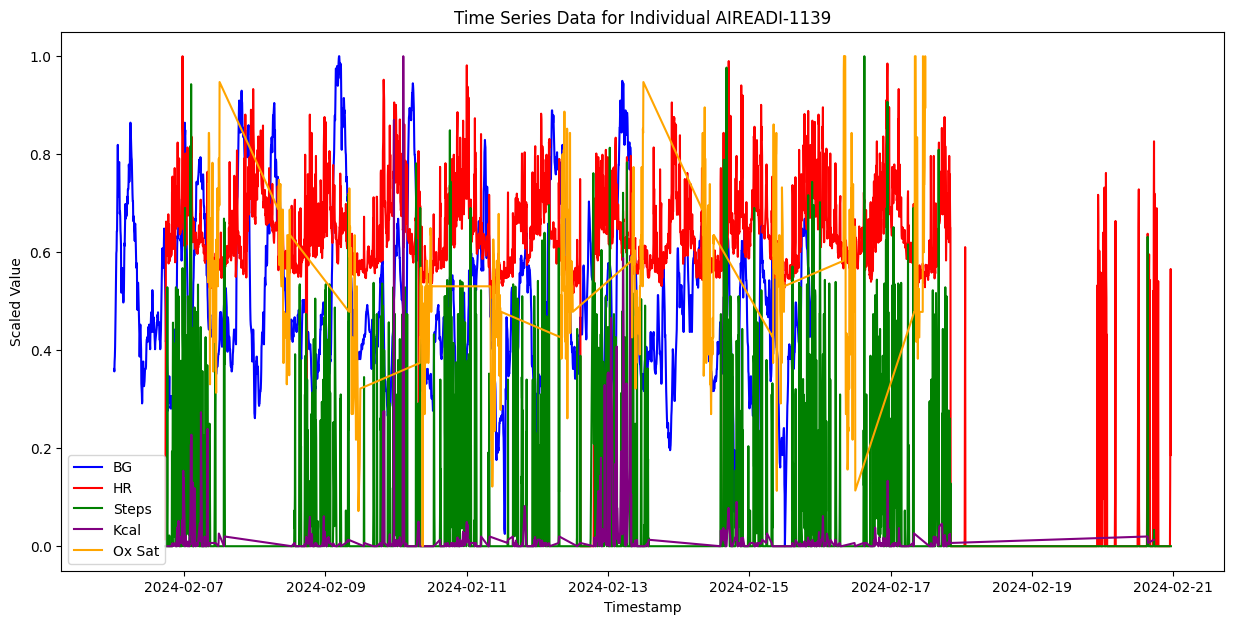

In [4]:
# Prompt: This data is a time series data for a bunch of people (uuid identifies the people). It contains time series of blood glucose (bg), heart rate (hr), steps, calories burned (kcal) and oxygen saturation (ox_sat_percent). Give me a way to plot a random individuals time series for each of these variables so I can inspect the  data. Rescale the variables so they can all be put on one plot and map them to different colors. Provide sparing code comments


# Select a random UUID
random_uuid = np.random.choice(df_larger_sample['uuid'].unique())
random_individual_df = df_larger_sample[df_larger_sample['uuid'] == random_uuid].copy()

# Define columns to plot
cols_to_plot = ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']

# Normalize the data for plotting on a single axis
for col in cols_to_plot:
  if col in random_individual_df.columns:
    # Check if the column contains non-null values
    if not random_individual_df[col].isnull().all():
        min_val = random_individual_df[col].min()
        max_val = random_individual_df[col].max()
        if max_val != min_val: # Avoid division by zero
            random_individual_df[f'{col}_scaled'] = (random_individual_df[col] - min_val) / (max_val - min_val)
        else:
             random_individual_df[f'{col}_scaled'] = 0.5 # Assign a mid-range value if all values are the same
    else:
        random_individual_df[f'{col}_scaled'] = np.nan # Assign NaN if the column is all null


# Plotting
plt.figure(figsize=(15, 7))
# Change 'ts' to 'timestamp' in the x argument
sns.lineplot(data=random_individual_df, x='timestamp', y='bg_scaled', label='BG', color='blue')
sns.lineplot(data=random_individual_df, x='timestamp', y='hr_scaled', label='HR', color='red')
sns.lineplot(data=random_individual_df, x='timestamp', y='steps_scaled', label='Steps', color='green')
sns.lineplot(data=random_individual_df, x='timestamp', y='kcal_scaled', label='Kcal', color='purple')
sns.lineplot(data=random_individual_df, x='timestamp', y='ox_sat_percent_scaled', label='Ox Sat', color='orange')

plt.title(f'Time Series Data for Individual {random_uuid}')
plt.xlabel('Timestamp')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

Some individuals have data far outside the 10 day range. This code attempts to extract only the 10 day range where all data are available

In [5]:
# Identify individuals with more than 10 days of data for any variable
# Assuming 'timestamp' is already in datetime format or can be easily converted
# Ensure 'timestamp' is datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'])

# List of measurement columns to check for duration
# Keep the check on all columns to identify which individuals need trimming
measurement_cols = ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']

long_duration_uuids_vars_list = []

# Iterate through each uuid and check duration for each measurement column
for uuid in df['uuid'].unique():
    df_uuid = df[df['uuid'] == uuid].copy()

    if df_uuid.empty:
        continue

    for col in measurement_cols:
        # Filter out rows where the measurement is missing for this column
        df_uuid_col = df_uuid[df_uuid[col].notna()]

        if not df_uuid_col.empty:
            # Calculate the duration in days for this variable and uuid
            duration_days = (df_uuid_col['timestamp'].max() - df_uuid_col['timestamp'].min()).days

            if duration_days > 10:
                long_duration_uuids_vars_list.append({'uuid': uuid, 'variable': col, 'duration_days': duration_days})

# Convert the list of dictionaries to a DataFrame
long_duration_uuids_vars = pd.DataFrame(long_duration_uuids_vars_list)

print("\nIndividuals and variables with more than 10 days of data:")
if not long_duration_uuids_vars.empty:
    print(long_duration_uuids_vars)

    # Identify unique uuids that need trimming for at least one variable
    # Add a check here to ensure the DataFrame is not empty before accessing 'uuid'
    uuids_to_trim = long_duration_uuids_vars['uuid'].unique()
    print(f"\nUnique UUIDs that need trimming: {uuids_to_trim}")
else:
    print("No individuals found with more than 10 days of data for any variable.")
    # If the DataFrame is empty, there are no uuids to trim
    uuids_to_trim = []
    print(f"\nUnique UUIDs that need trimming: {uuids_to_trim}")


# Function to trim data for a specific uuid based on the start and end of BG data
def trim_data_to_bg_window(df, uuid):
    individual_df = df[df['uuid'] == uuid].copy()
    if individual_df.empty:
        return individual_df # Return empty if no data for this uuid

    # Filter for non-null 'bg' values to find the start and end of the BG series
    bg_data = individual_df[individual_df['bg'].notna()].copy()

    if bg_data.empty:
        # If there is no BG data for this uuid, no trimming based on BG is possible
        print(f"Warning: No 'bg' data found for uuid {uuid}. Cannot trim based on BG.")
        return pd.DataFrame(columns=df.columns) # Return empty DataFrame if no BG data

    # Find the earliest and latest timestamp among non-null BG values
    min_timestamp_bg = bg_data['timestamp'].min()
    max_timestamp_bg = bg_data['timestamp'].max()

    # Filter the entire individual's data to include only timestamps within the BG window
    trimmed_individual_df = individual_df[(individual_df['timestamp'] >= min_timestamp_bg) &
                                          (individual_df['timestamp'] <= max_timestamp_bg)].copy()

    return trimmed_individual_df

# Create a new DataFrame with trimmed data for the identified uuids
# And keep original data for uuids that didn't need trimming
trimmed_df_list = []

# Process uuids that need trimming
# This loop will now correctly handle the case where uuids_to_trim is empty
for uuid in uuids_to_trim:
    # Use the new BG-focused trimming function
    trimmed_individual_df = trim_data_to_bg_window(df, uuid)
    if not trimmed_individual_df.empty:
        trimmed_df_list.append(trimmed_individual_df)


# Add data for uuids that do not need trimming
# This approach assumes that uuids_to_trim correctly identifies all UUIDs that need trimming.
# We can filter the original df to get the data for uuids not in uuids_to_trim.
# Convert arrays to sets before using the difference method
uuids_not_to_trim = set(df['uuid'].unique()).difference(set(uuids_to_trim))
df_not_trimmed = df[df['uuid'].isin(uuids_not_to_trim)].copy()
if not df_not_trimmed.empty:
    trimmed_df_list.append(df_not_trimmed)

# Concatenate all data back into a single DataFrame
# Handle the case where trimmed_df_list might be empty if no data exists after filtering/trimm ing
if trimmed_df_list:
    df_trimmed = pd.concat(trimmed_df_list, ignore_index=True)
    print("\nDataFrame after trimming long duration data:")
    print(df_trimmed)
else:
    df_trimmed = pd.DataFrame(columns=df.columns) # Create an empty DataFrame with original columns
    print("\nNo data remaining after processing and trimming.")

# Ensure df is updated to df_trimmed for subsequent cells
df = df_trimmed.copy()


Individuals and variables with more than 10 days of data:
            uuid        variable  duration_days
0   AIREADI-1062              hr             22
1   AIREADI-1062           steps             22
2   AIREADI-1072              hr             14
3   AIREADI-1072           steps             14
4   AIREADI-1094              hr             14
5   AIREADI-1094           steps             14
6   AIREADI-1094            kcal             11
7   AIREADI-1098              hr             14
8   AIREADI-1098           steps             14
9   AIREADI-1109              hr             12
10  AIREADI-1109           steps             12
11  AIREADI-1283              hr             15
12  AIREADI-1283           steps             15
13  AIREADI-1310              hr             17
14  AIREADI-1310           steps             17
15  AIREADI-1310            kcal             11
16  AIREADI-1322              hr             13
17  AIREADI-1322           steps             13
18  AIREADI-1344             

Visualize some of the trimmed data


Visualizing data for individuals whose data was trimmed:


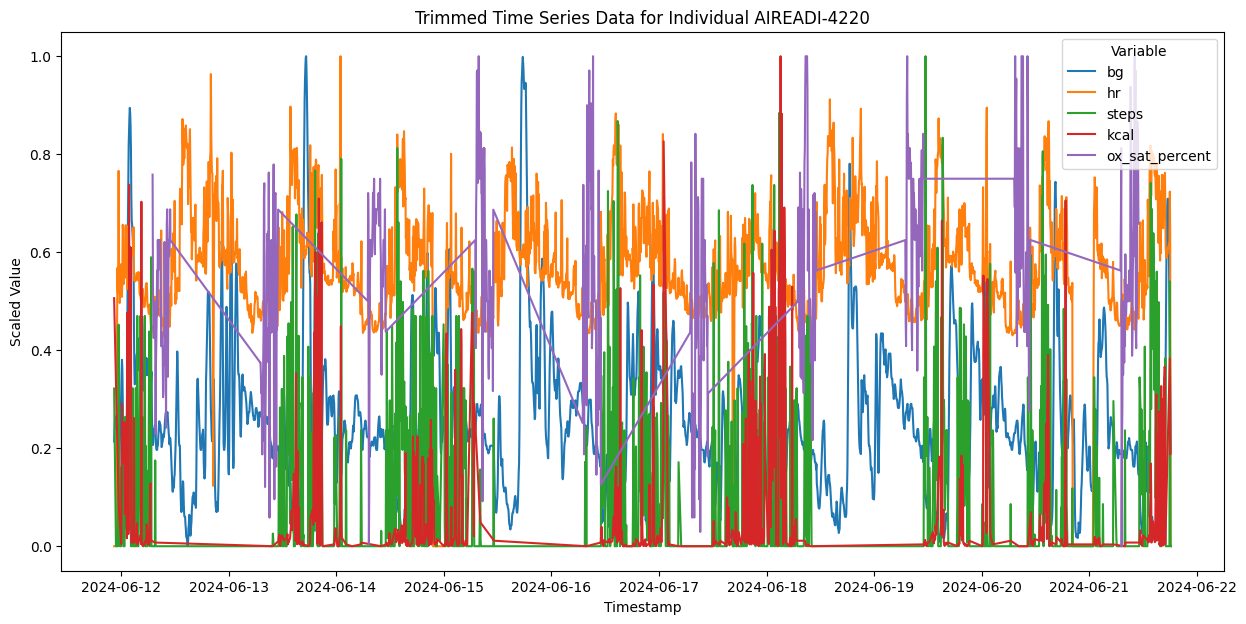

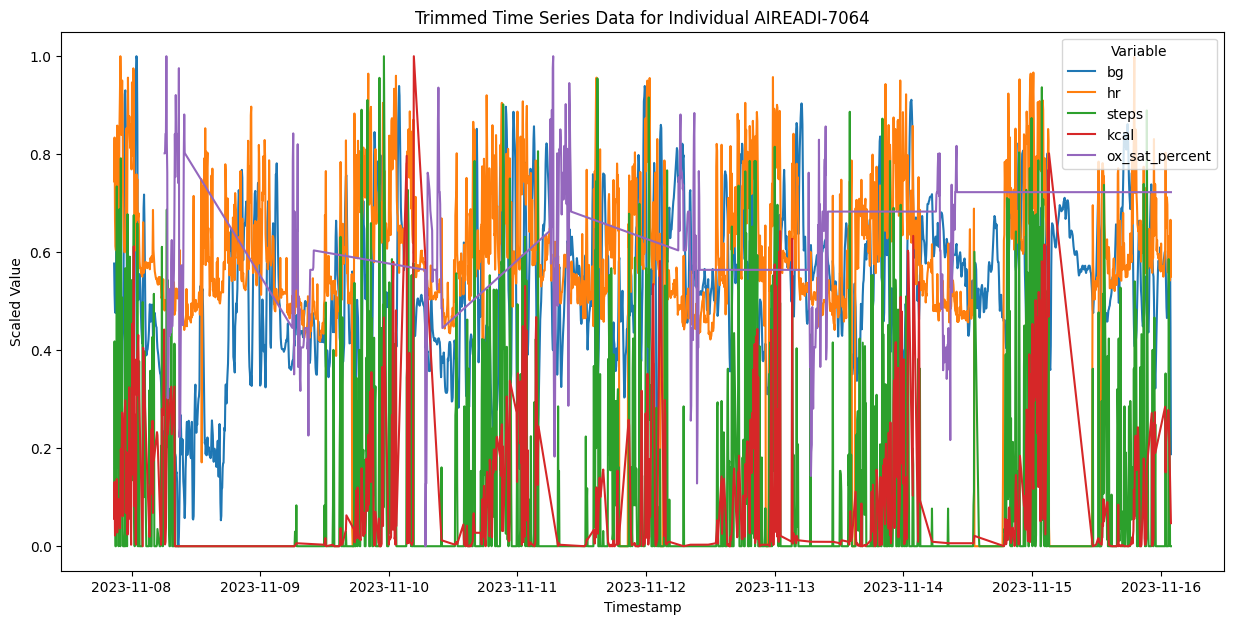

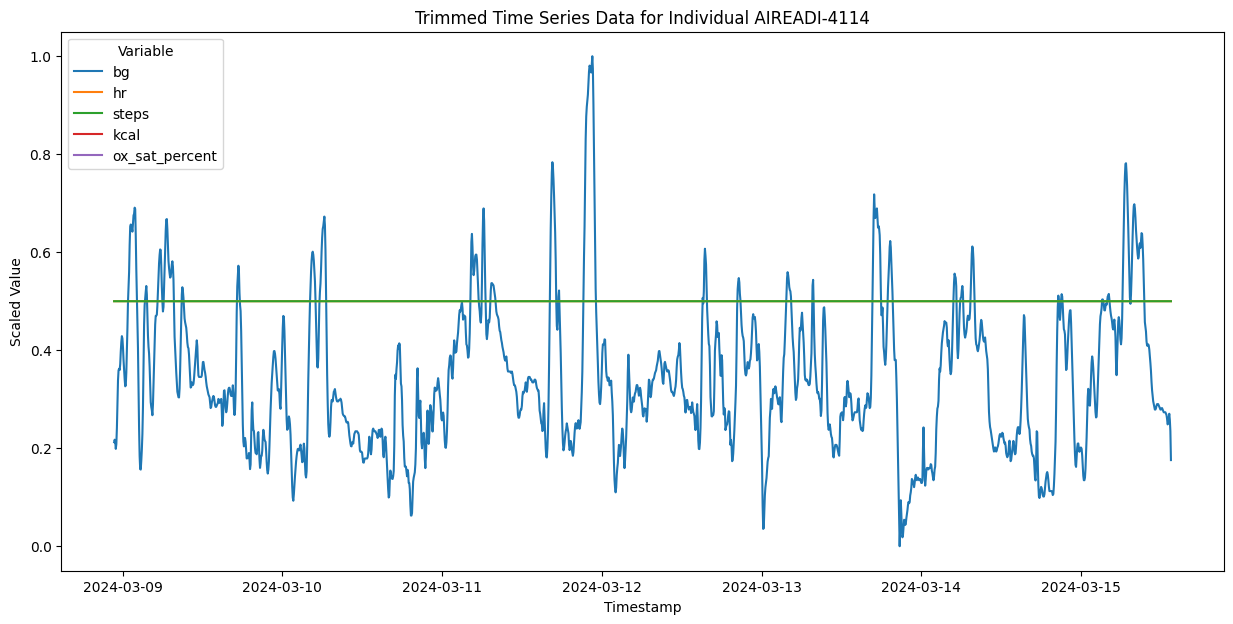

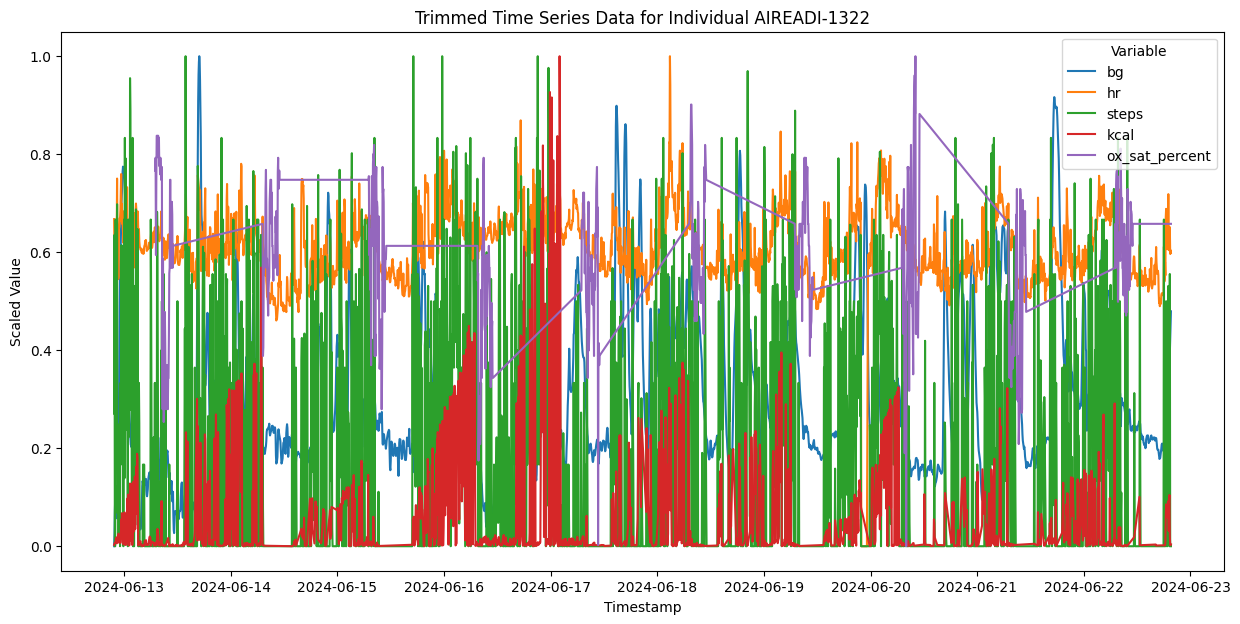

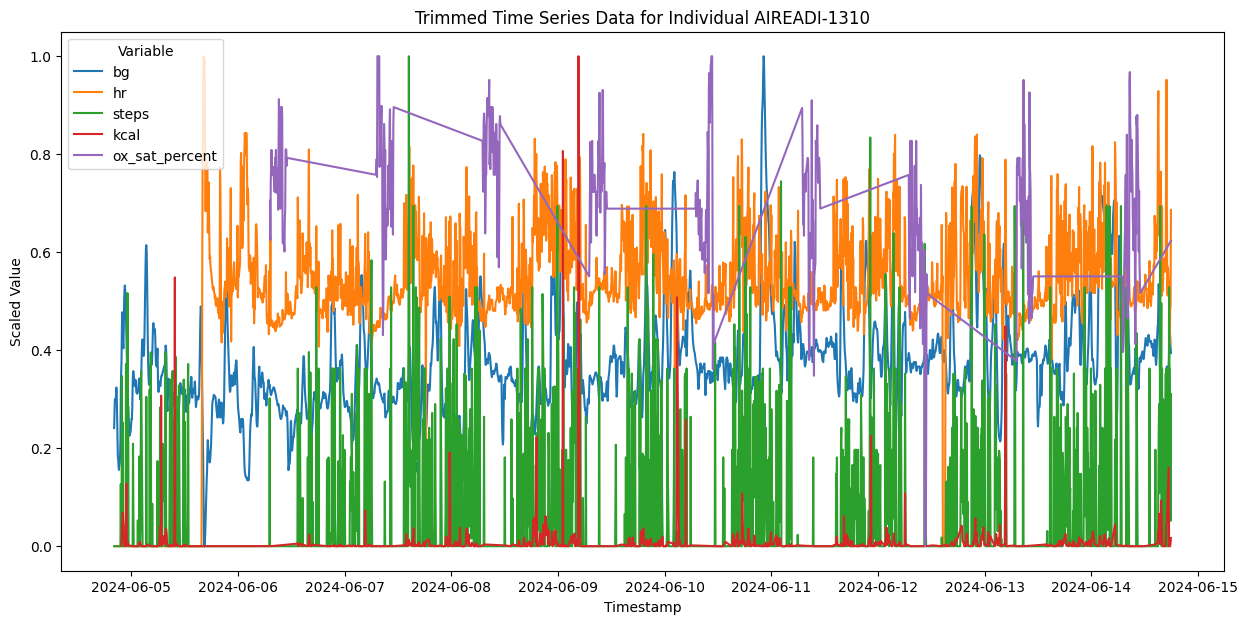

In [6]:


# Visualize the data for individuals whose data was trimmed
print("\nVisualizing data for individuals whose data was trimmed:")

# Define columns to plot
cols_to_plot = ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']

# Select a random subset of 5 UUIDs from the ones that were trimmed
# Ensure we only sample if there are enough uuids to trim
if len(uuids_to_trim) > 0:
    uuids_to_visualize = np.random.choice(uuids_to_trim, size=min(5, len(uuids_to_trim)), replace=False)
else:
    uuids_to_visualize = []
    print("No UUIDs needed trimming, skipping visualization of trimmed data.")


for uuid in uuids_to_visualize:
    # Use df_trimmed for visualization (df was updated to df_trimmed in the previous cell)
    individual_df = df[df['uuid'] == uuid].copy()

    if individual_df.empty:
        print(f"No data available for UUID {uuid} in the trimmed DataFrame. Skipping visualization.")
        continue

    # Melt the DataFrame for easier plotting with seaborn
    # Only melt the columns that exist in the individual_df and are in cols_to_plot
    cols_to_melt = [col for col in cols_to_plot if col in individual_df.columns]
    if not cols_to_melt:
        print(f"No relevant measurement columns found for UUID {uuid} in trimmed data. Skipping visualization.")
        continue

    individual_melted = individual_df.melt(id_vars=['uuid', 'timestamp'], value_vars=cols_to_melt, var_name='variable', value_name='value')

    # Normalize the data for plotting on a single axis for this individual
    # Apply normalization within the group for each variable
    def normalize_group(group):
        min_val = group['value'].min()
        max_val = group['value'].max()
        # Check for NaN values before calculating min/max and performing normalization
        if group['value'].isnull().all():
            group['value_scaled'] = np.nan
        elif max_val != min_val:
            group['value_scaled'] = (group['value'] - min_val) / (max_val - min_val)
        else:
            group['value_scaled'] = 0.5  # Assign a mid-range value if all values are the same and not all null
        return group

    # Apply normalization only if individual_melted is not empty
    if not individual_melted.empty:
         individual_melted = individual_melted.groupby('variable', group_keys=False).apply(normalize_group).reset_index(drop=True)
    else:
         print(f"Melted DataFrame is empty for UUID {uuid}. Skipping plotting.")
         continue


    plt.figure(figsize=(15, 7))
    # Use individual_melted for plotting
    sns.lineplot(data=individual_melted, x='timestamp', y='value_scaled', hue='variable')

    plt.title(f'Trimmed Time Series Data for Individual {uuid}')
    plt.xlabel('Timestamp')
    plt.ylabel('Scaled Value')
    plt.legend(title='Variable')
    plt.show()

ACF/ PACF Plots

ACF/PACF Analysis Summary
Dataset shape: (747279, 7)
Number of individuals: 100
Variables to analyze: ['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent']
Minimum observations per individual: 50

bg:
  - Total non-null observations: 275403
  - Overall mean: 138.9342
  - Overall std: 47.7416
  - Valid individuals: 100
  - Average observations per valid individual: 2754.0
  - Range of observations per individual: 813 - 2867
  - Range of individual std deviations: 13.1022 - 92.7926

hr:
  - Total non-null observations: 634511
  - Overall mean: 35.7337
  - Overall std: 39.4426
  - Valid individuals: 100
  - Average observations per valid individual: 6345.1
  - Range of observations per individual: 1730 - 41901
  - Range of individual std deviations: 13.6148 - 46.7105

steps:
  - Total non-null observations: 689910
  - Overall mean: 7.3115
  - Overall std: 21.6228
  - Valid individuals: 100
  - Average observations per valid individual: 6899.1
  - Range of observations per individual: 1730 - 419

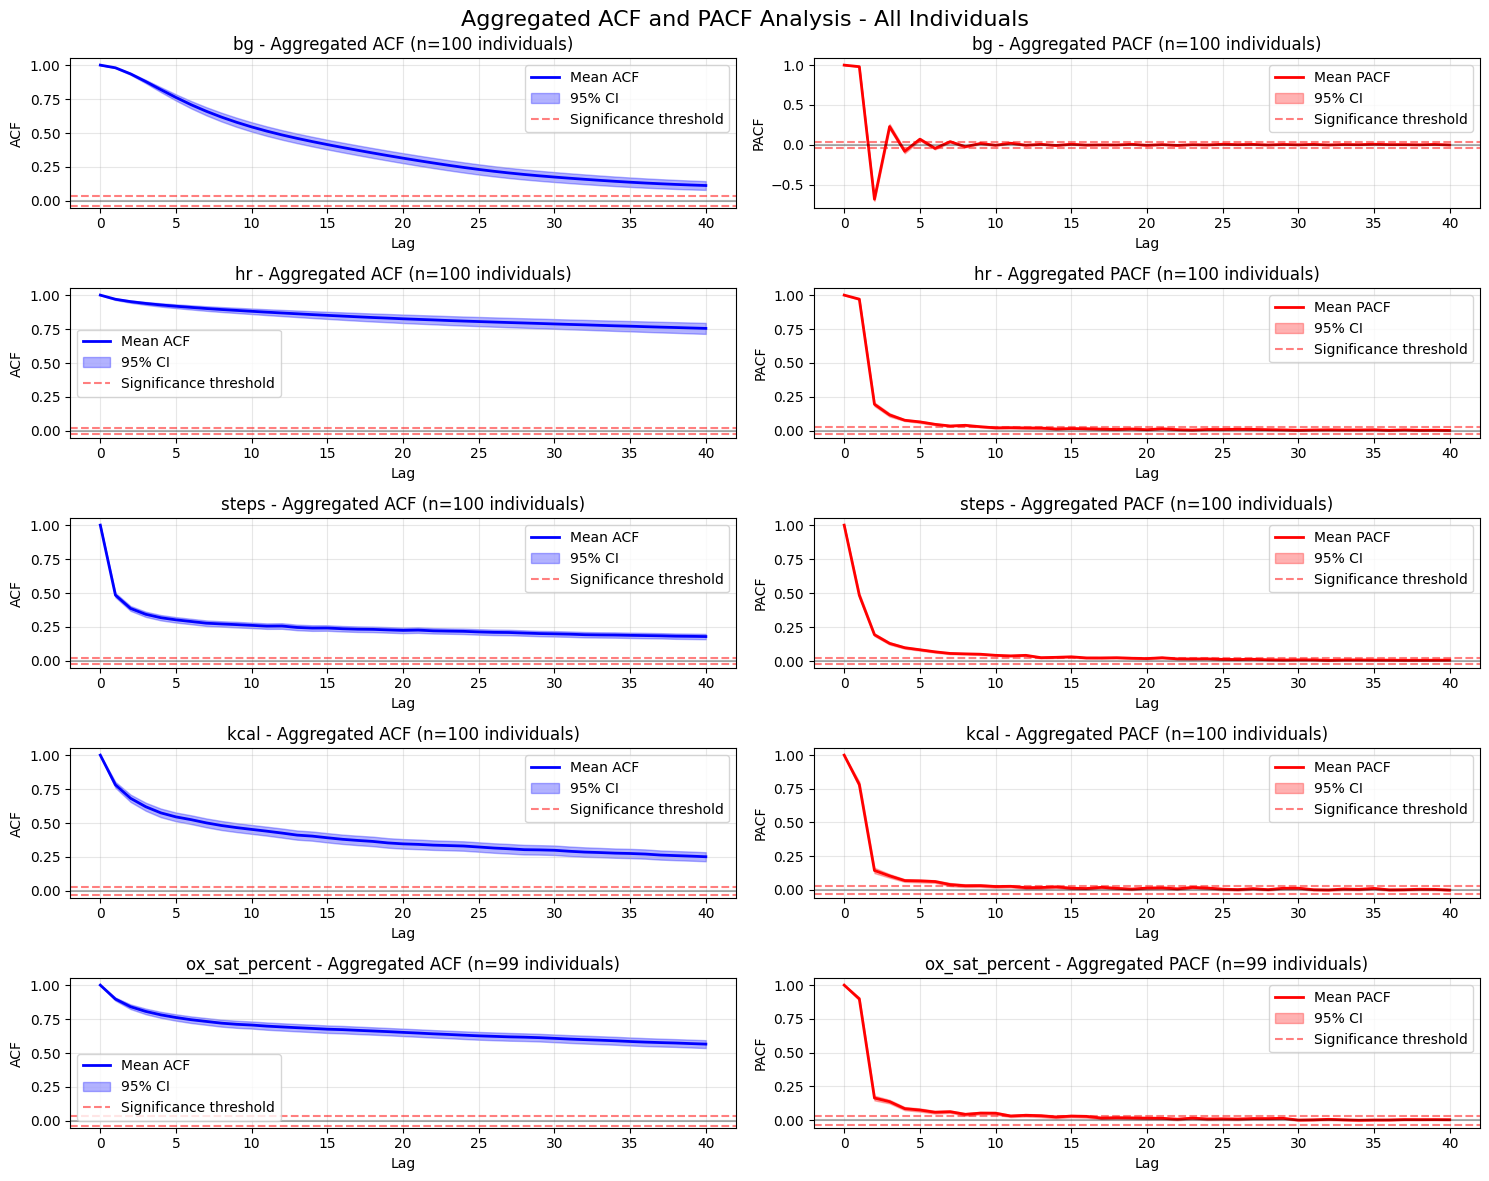

In [7]:



def preprocess_series(data, min_obs=50):
    """
    Preprocess time series data to handle common issues

    Parameters:
    -----------
    data : pandas.Series
        Time series data
    min_obs : int
        Minimum number of observations required

    Returns:
    --------
    pandas.Series or None
        Preprocessed data or None if invalid
    """
    # Remove NaN values
    clean_data = data.dropna()

    # Check minimum length
    if len(clean_data) < min_obs:
        return None

    # Check for constant values (no variation)
    if clean_data.nunique() <= 1:
        print(f"Warning: Series has constant values (std = {clean_data.std():.6f})")
        return None

    # Check for extremely low variation
    if clean_data.std() < 1e-10:
        print(f"Warning: Series has very low variation (std = {clean_data.std():.6f})")
        return None

    return clean_data

def safe_acf_pacf(data, max_lags=40):
    """
    Safely calculate ACF and PACF with error handling

    Parameters:
    -----------
    data : pandas.Series
        Time series data
    max_lags : int
        Maximum number of lags

    Returns:
    --------
    tuple : (acf_values, pacf_values) or (None, None) if calculation fails
    """
    try:
        # Adjust max_lags if data is too short
        effective_lags = min(max_lags, len(data) - 1, len(data) // 4)

        if effective_lags < 1:
            return None, None

        # Calculate ACF with different methods if needed
        try:
            acf_vals = acf(data, nlags=effective_lags, fft=True)
        except:
            # Fallback to non-FFT method
            acf_vals = acf(data, nlags=effective_lags, fft=False)

        # Calculate PACF with error handling
        try:
            pacf_vals = pacf(data, nlags=effective_lags, method='ols')
        except:
            try:
                # Try alternative method
                pacf_vals = pacf(data, nlags=effective_lags, method='ywm')
            except:
                print("Warning: PACF calculation failed, using zeros")
                pacf_vals = np.zeros(effective_lags + 1)

        return acf_vals, pacf_vals

    except Exception as e:
        print(f"Error in ACF/PACF calculation: {e}")
        return None, None

def plot_aggregated_acf_pacf(df, uuid_col='uuid', variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                            max_lags=40, figsize=(15, 12), min_obs_per_individual=50):
    """
    Plot aggregated ACF and PACF across all individuals with robust error handling

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing time series data with uuid column and variable columns
    uuid_col : str
        Name of the column containing individual identifiers
    variables : list
        List of variable names to analyze
    max_lags : int
        Maximum number of lags to compute
    figsize : tuple
        Figure size (width, height)
    min_obs_per_individual : int
        Minimum observations required per individual

    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """

    fig, axes = plt.subplots(len(variables), 2, figsize=figsize)
    if len(variables) == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Aggregated ACF and PACF Analysis - All Individuals', fontsize=16)

    for i, var in enumerate(variables):
        print(f"\nProcessing variable: {var}")

        if var not in df.columns:
            print(f"Warning: Variable '{var}' not found in dataframe")
            axes[i, 0].text(0.5, 0.5, f'Variable {var} not found',
                           transform=axes[i, 0].transAxes, ha='center', va='center')
            axes[i, 1].text(0.5, 0.5, f'Variable {var} not found',
                           transform=axes[i, 1].transAxes, ha='center', va='center')
            continue

        acf_values = []
        pacf_values = []
        valid_individuals = 0
        skipped_individuals = 0

        # Process each individual
        for uuid in df[uuid_col].unique():
            individual_data = df[df[uuid_col] == uuid][var]

            # Preprocess data
            clean_data = preprocess_series(individual_data, min_obs=min_obs_per_individual)

            if clean_data is None:
                skipped_individuals += 1
                continue

            # Calculate ACF/PACF
            acf_vals, pacf_vals = safe_acf_pacf(clean_data, max_lags)

            if acf_vals is not None and pacf_vals is not None:
                acf_values.append(acf_vals)
                pacf_values.append(pacf_vals)
                valid_individuals += 1
            else:
                skipped_individuals += 1

        print(f"  Valid individuals: {valid_individuals}")
        print(f"  Skipped individuals: {skipped_individuals}")

        if len(acf_values) > 0:
            # Find minimum length to align all series
            min_len = min(len(acf) for acf in acf_values)
            acf_values = [acf[:min_len] for acf in acf_values]
            pacf_values = [pacf[:min_len] for pacf in pacf_values]

            # Calculate statistics
            acf_mean = np.mean(acf_values, axis=0)
            acf_std = np.std(acf_values, axis=0)
            pacf_mean = np.mean(pacf_values, axis=0)
            pacf_std = np.std(pacf_values, axis=0)

            # Standard error for confidence intervals
            acf_se = acf_std / np.sqrt(len(acf_values))
            pacf_se = pacf_std / np.sqrt(len(pacf_values))

            lags = range(len(acf_mean))

            # Estimate average series length for significance bounds
            avg_n = np.mean([len(df[df[uuid_col] == uuid][var].dropna())
                           for uuid in df[uuid_col].unique()
                           if len(df[df[uuid_col] == uuid][var].dropna()) >= min_obs_per_individual])

            sig_bound = 1.96 / np.sqrt(avg_n) if avg_n > 0 else 0.1

            # Plot ACF
            axes[i, 0].plot(lags, acf_mean, 'b-', linewidth=2, label='Mean ACF')
            axes[i, 0].fill_between(lags, acf_mean - 1.96*acf_se,
                                   acf_mean + 1.96*acf_se,
                                   alpha=0.3, color='blue', label='95% CI')
            axes[i, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
            axes[i, 0].axhline(y=sig_bound, color='r', linestyle='--', alpha=0.5,
                              label='Significance threshold')
            axes[i, 0].axhline(y=-sig_bound, color='r', linestyle='--', alpha=0.5)
            axes[i, 0].set_title(f'{var} - Aggregated ACF (n={valid_individuals} individuals)')
            axes[i, 0].set_xlabel('Lag')
            axes[i, 0].set_ylabel('ACF')
            axes[i, 0].legend()
            axes[i, 0].grid(True, alpha=0.3)
            # Force integer ticks on x-axis
            axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            axes[i, 0].tick_params(axis='x', which='major')

            # Plot PACF
            axes[i, 1].plot(lags, pacf_mean, 'r-', linewidth=2, label='Mean PACF')
            axes[i, 1].fill_between(lags, pacf_mean - 1.96*pacf_se,
                                   pacf_mean + 1.96*pacf_se,
                                   alpha=0.3, color='red', label='95% CI')
            axes[i, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
            axes[i, 1].axhline(y=sig_bound, color='r', linestyle='--', alpha=0.5,
                              label='Significance threshold')
            axes[i, 1].axhline(y=-sig_bound, color='r', linestyle='--', alpha=0.5)
            axes[i, 1].set_title(f'{var} - Aggregated PACF (n={valid_individuals} individuals)')
            axes[i, 1].set_xlabel('Lag')
            axes[i, 1].set_ylabel('PACF')
            axes[i, 1].legend()
            axes[i, 1].grid(True, alpha=0.3)
            # Force integer ticks on x-axis
            axes[i, 1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            axes[i, 1].tick_params(axis='x', which='major')

        else:
            axes[i, 0].text(0.5, 0.5, f'No valid data for {var}\n({skipped_individuals} individuals skipped)',
                           transform=axes[i, 0].transAxes, ha='center', va='center')
            axes[i, 1].text(0.5, 0.5, f'No valid data for {var}\n({skipped_individuals} individuals skipped)',
                           transform=axes[i, 1].transAxes, ha='center', va='center')

    plt.tight_layout()
    return fig

def analyze_acf_pacf_summary(df, uuid_col='uuid', variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                            min_obs_per_individual=50):
    """
    Print detailed summary statistics about the ACF/PACF analysis
    """
    print("ACF/PACF Analysis Summary")
    print("=" * 50)
    print(f"Dataset shape: {df.shape}")
    print(f"Number of individuals: {df[uuid_col].nunique()}")
    print(f"Variables to analyze: {variables}")
    print(f"Minimum observations per individual: {min_obs_per_individual}")
    print()

    for var in variables:
        if var in df.columns:
            print(f"{var}:")

            # Overall statistics
            total_obs = df[var].notna().sum()
            print(f"  - Total non-null observations: {total_obs}")
            print(f"  - Overall mean: {df[var].mean():.4f}")
            print(f"  - Overall std: {df[var].std():.4f}")

            # Individual-level statistics
            valid_individuals = 0
            total_valid_obs = 0
            individual_stats = []

            for uuid in df[uuid_col].unique():
                individual_data = df[df[uuid_col] == uuid][var].dropna()

                if len(individual_data) >= min_obs_per_individual:
                    # Check for variation
                    if individual_data.std() > 1e-10:
                        valid_individuals += 1
                        total_valid_obs += len(individual_data)
                        individual_stats.append({
                            'uuid': uuid,
                            'n_obs': len(individual_data),
                            'mean': individual_data.mean(),
                            'std': individual_data.std()
                        })

            if valid_individuals > 0:
                avg_obs_per_individual = total_valid_obs / valid_individuals
                print(f"  - Valid individuals: {valid_individuals}")
                print(f"  - Average observations per valid individual: {avg_obs_per_individual:.1f}")

                # Show range of individual statistics
                obs_counts = [stats['n_obs'] for stats in individual_stats]
                stds = [stats['std'] for stats in individual_stats]
                print(f"  - Range of observations per individual: {min(obs_counts)} - {max(obs_counts)}")
                print(f"  - Range of individual std deviations: {min(stds):.4f} - {max(stds):.4f}")
            else:
                print(f"  - No valid individuals (insufficient data or no variation)")

        else:
            print(f"{var}: Variable not found in dataset")
        print()

# This takes a long time with all the data so just use a subsample

# Print detailed summary
analyze_acf_pacf_summary(df_larger_sample, uuid_col='uuid',
                        variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                        min_obs_per_individual=50)

# Create aggregated plots with robust error handling
fig = plot_aggregated_acf_pacf(df_larger_sample, uuid_col='uuid',
                              variables=['bg', 'hr', 'steps', 'kcal', 'ox_sat_percent'],
                              max_lags=40, min_obs_per_individual=50)
plt.show()



Based on the PACF plots, it looks like PACF drops to nothing around 5 time lags or less. I'm not sure if using a longer lag will be useful, so for now I'm going to generate one for the first 5 time steps and then one for something longer


# Clean data

Impute missing data and engineer useful features that may improve a RNN model.[link text](https://)


In [8]:
# prompt: I want to check the df_full data.frame for the overall % missing values for each variable and  average % of missing values for each variable by UUID. I also want code to drop any variables that have >25% missingness overall, except for bg, which should be retained always. Also remove these variables from the df_larger_sample and the df data.frames.

# Overall percentage of missing values for each variable in df_full
missing_overall = df_full.isnull().sum() / len(df_full) * 100
print("Overall % Missing Values:")
print(missing_overall)

# Average percentage of missing values for each variable by UUID in df_full
missing_by_uuid = df_full.groupby('uuid').apply(lambda x: x.isnull().sum() / len(x) * 100)
print("\nAverage % Missing Values by UUID:")
print(missing_by_uuid.mean())

# Identify columns to drop (missingness > 40% overall, excluding 'bg')
cols_to_drop = missing_overall[missing_overall > 40].index.tolist()

# Ensure 'bg' is not in the list of columns to drop, even if it exceeds the threshold
if 'bg' in cols_to_drop:
    cols_to_drop.remove('bg')

print(f"\nColumns to drop (overall missing > 40%, excluding 'bg'): {cols_to_drop}")

# Drop the identified columns from all three DataFrames
df_full.drop(columns=cols_to_drop, errors='ignore', inplace=True)
df_larger_sample.drop(columns=cols_to_drop, errors='ignore', inplace=True)
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

print("\nDataFrames after dropping columns:")
print("df_full shape:", df_full.shape)
print("df_larger_sample shape:", df_larger_sample.shape)
print("df shape:", df.shape)

Overall % Missing Values:
timestamp          0.000000
uuid               0.000000
bg                59.666938
hr                12.919123
kcal              39.076465
steps              6.445389
ox_sat_percent    53.173487
dtype: float64

Average % Missing Values by UUID:
timestamp          0.000000
uuid               0.000000
bg                40.401056
hr                 6.123740
kcal              29.452953
steps              3.682734
ox_sat_percent    39.102038
dtype: float64

Columns to drop (overall missing > 40%, excluding 'bg'): ['ox_sat_percent']

DataFrames after dropping columns:
df_full shape: (5411838, 6)
df_larger_sample shape: (747279, 6)
df shape: (55777, 6)


In [9]:
# prompt: Now I want to look at the % missingness of all variables for each UUID. Report the mean, median, min, max and standard deviation of the percent missingness for each variable by UUID. I want to drop any records for a UUID that has bg missingness > 25%, hr missingness > 10%, kcal missingness > 40%, and steps missingness > 10%. Tell me how many UUIDs were dropped for each variable threshold

# Calculate missingness percentage for each variable for each UUID
missingness_by_uuid_detailed = df_full.groupby('uuid').apply(lambda x: x.isnull().sum() / len(x) * 100)

# Report the mean, median, min, max and standard deviation
missingness_stats = missingness_by_uuid_detailed.agg(['mean', 'median', 'min', 'max', 'std'])

print("\nMissingness Statistics per Variable by UUID:")
print(missingness_stats)

# Define the missingness thresholds
thresholds = {
    'bg': 40,
    'hr': 10,
    'kcal': 40,
    'steps': 10
}

# Initialize a dictionary to store dropped UUID counts
dropped_uuids_count = {var: 0 for var in thresholds.keys()}

# Identify UUIDs to drop based on thresholds
uuids_to_drop_set = set() # Use a set to avoid adding the same UUID multiple times

for variable, threshold in thresholds.items():
    if variable in missingness_by_uuid_detailed.columns:
        # Find UUIDs where missingness for this variable exceeds the threshold
        uuids_exceeding_threshold = missingness_by_uuid_detailed[missingness_by_uuid_detailed[variable] > threshold].index.tolist()

        # Add these UUIDs to the set of UUIDs to drop
        uuids_to_drop_set.update(uuids_exceeding_threshold)

        # Count how many distinct UUIDs were added to the drop list *because of this specific variable*
        # This counts how many met *this* variable's criteria
        dropped_uuids_count[variable] = len(uuids_exceeding_threshold)

print("\nNumber of UUIDs dropped for exceeding threshold for each variable:")
for variable, count in dropped_uuids_count.items():
    print(f"- {variable}: {count}")

# Convert the set of UUIDs to drop to a list
uuids_to_drop_list = list(uuids_to_drop_set)

print(f"\nTotal unique UUIDs to drop based on all thresholds: {len(uuids_to_drop_list)}")

# Drop the identified records from df_full
initial_rows = len(df_full)
df_full_cleaned = df_full[~df_full['uuid'].isin(uuids_to_drop_list)].copy()
final_rows = len(df_full_cleaned)

print(f"\nInitial number of rows in df_full: {initial_rows}")
print(f"Final number of rows in df_full after dropping records: {final_rows}")
print(f"Number of rows dropped: {initial_rows - final_rows}")
print(f"Number of UUIDs remaining: {df_full_cleaned['uuid'].nunique()}")

# Update the df_full variable to the cleaned version
df_full = df_full_cleaned.copy()

# Note: The original task asks to drop records for a UUID if *any* variable exceeds its threshold.
# The code above implements this by collecting all UUIDs that fail *any* threshold
# into `uuids_to_drop_set` and then dropping all rows associated with those UUIDs.
# The count `dropped_uuids_count[variable]` shows how many UUIDs violated each *individual* threshold,
# but the final drop removes a UUID if it violated *at least one* threshold.



Missingness Statistics per Variable by UUID:
        timestamp  uuid          bg         hr       kcal      steps
mean          0.0   0.0   40.401056   6.123740  29.452953   3.682734
median        0.0   0.0   34.684217   0.080118  26.288363   0.000000
min           0.0   0.0    0.000000   0.000000   0.016706   0.000000
max           0.0   0.0  100.000000  97.258486  97.715405  97.258486
std           0.0   0.0   22.166922  17.282569  21.166092  13.156324

Number of UUIDs dropped for exceeding threshold for each variable:
- bg: 315
- hr: 98
- kcal: 180
- steps: 74

Total unique UUIDs to drop based on all thresholds: 363

Initial number of rows in df_full: 5411838
Final number of rows in df_full after dropping records: 1674913
Number of rows dropped: 3736925
Number of UUIDs remaining: 429


In [10]:
# prompt: Using the df data.frame, give me code that uses the prophet time series modeling library or PyMC and Stan (which is already loaded) to impute missing values. I want to fit time series models that pool information across UUIDs similar to a hierarchical or mixed-effects model to improve predictions for the imputed values. I'm getting errors that the time zone needs to be removed

# Ensure timestamp columns are timezone-naive before any operations that might conflict
# This is crucial for compatibility with Prophet and joining operations
# We will work with timezone-naive timestamps and add timezone back at the end if needed.
df['timestamp'] = df['timestamp'].dt.tz_localize(None)

# Reset the index of df to ensure it's a clean default integer index from 0
# This is crucial for aligning original_null_masks correctly after merges
df = df.reset_index(drop=True)

# Also ensure df_imputed (from previous steps) is timezone-naive if it's going to be used or compared
if 'df_imputed' in globals():
    df_imputed['timestamp'] = df_imputed['timestamp'].dt.tz_localize(None)


# Prepare data for Prophet - Global Model with UUID regressors
# Prophet requires columns named 'ds' for timestamp and 'y' for the value to be predicted/imputed.
# For a global model, we'll combine data from all UUIDs.

# Create a list to store imputed results
prophet_imputed_list = []

variables_to_impute = ['bg', 'hr', 'kcal', 'steps'] # Define the variables to impute

# Store original null masks for each variable BEFORE any imputation loop starts
# We will store the null mask along with the original index
original_null_masks_with_index = {}
for var in variables_to_impute:
    if var in df.columns:
        # Reset index when storing the null mask to capture the original row number
        original_null_masks_with_index[var] = df[var].isnull().reset_index(name=f'{var}_original_null')


# Prepare the combined DataFrame for Prophet
# We will train a separate global model for each variable to impute.
for var in variables_to_impute:
    if var not in df.columns:
        print(f"Warning: Variable '{var}' not found in dataframe. Skipping global Prophet imputation for {var}.")
        # If the variable is not in the dataframe, add the indicator column with all zeros
        df[f'is_{var}_prophet_imputed'] = 0
        # And add the imputed column as a copy of the original (which will be all NaNs if not present)
        df[f'{var}_prophet_imputed'] = df.get(var, pd.Series(np.nan, index=df.index))
        continue


    print(f"Applying Global Prophet for imputation on variable: {var}")

    # Create a DataFrame with 'ds', 'y', and 'uuid' from the original df
    # We are working with the original df state (after trimming and initial drops, before first imputation)
    # to identify where the true missing values were.
    global_prophet_df = df[['timestamp', 'uuid', var]].copy()
    global_prophet_df.rename(columns={'timestamp': 'ds', var: 'y'}, inplace=True)

    # Drop rows where 'y' is still NaN in the original df before fitting the global model
    # Prophet cannot handle NaNs in the 'y' column for fitting.
    global_prophet_df_train = global_prophet_df.dropna(subset=['y']).copy()

    # Check if there's enough data to train the global model
    if global_prophet_df_train.empty or len(global_prophet_df_train['uuid'].unique()) < 2:
        print(f"Skipping Global Prophet for variable {var}: Insufficient non-missing data across individuals.")
        # If global Prophet fails, we should ensure the original data for this variable is kept
        # and the indicator column is all zeros.
        df[f'is_{var}_prophet_imputed'] = 0
        df[f'{var}_prophet_imputed'] = df[var].copy() # Keep original values/NaNs
        continue


    # Create dummy variables for UUIDs to use as regressors
    # This allows Prophet to learn a baseline effect for each UUID, effectively pooling information.
    uuid_dummies = pd.get_dummies(global_prophet_df_train['uuid'], prefix='uuid')
    # Add the dummy variables to the training data
    global_prophet_df_train = pd.concat([global_prophet_df_train, uuid_dummies], axis=1)

    # Initialize and fit Prophet model
    # Add seasonality if not already present (daily, weekly) - can be added once or inside loop
    # Let's add them inside the loop to be explicit for each model fit.
    m = Prophet(daily_seasonality=True, weekly_seasonality=True)


    # Add dummy variable regressors
    for col in uuid_dummies.columns:
        m.add_regressor(col)

    try:
        print(f"Fitting global Prophet model for {var}...")
        m.fit(global_prophet_df_train)
        print(f"Global Prophet model for {var} fitted successfully.")
    except Exception as e:
        print(f"Global Prophet fit failed for variable {var}: {e}")
        # If global Prophet fit fails, ensure original data for this variable is kept
        # and the indicator column is all zeros.
        df[f'is_{var}_prophet_imputed'] = 0
        df[f'{var}_prophet_imputed'] = df[var].copy() # Keep original values/NaNs
        continue


    # --- Make Predictions for all potential data points ---
    # We need to predict for all timestamps and UUIDs that were in the original df,
    # including where 'y' was originally missing.

    # Create the full future DataFrame based on the original df structure
    future = df[['timestamp', 'uuid']].copy()
    future.rename(columns={'timestamp': 'ds'}, inplace=True)

    # Create dummy variables for UUIDs in the future DataFrame as well
    future_uuid_dummies = pd.get_dummies(future['uuid'], prefix='uuid')
    future = pd.concat([future, future_uuid_dummies], axis=1)

    # Ensure that the dummy columns in 'future' match those in 'global_prophet_df_train'
    # This is important if some UUIDs only appear in the full data but not the training data (less likely after initial filtering)
    # Or if the dummy variables cover all UUIDs in the full df but not all were in the training subset.
    # Align columns - add missing dummy columns to future and fill with 0
    train_dummy_cols = set(uuid_dummies.columns)
    future_dummy_cols = set(future_uuid_dummies.columns)

    for col in train_dummy_cols - future_dummy_cols:
        future[col] = 0
    # Drop extra dummy columns in future if any (shouldn't happen with get_dummies on the same set of UUIDs)
    # future = future[list(train_dummy_cols) + ['ds', 'uuid']] # Reorder if necessary

    # Ensure future has the same columns as the training data (including all dummy regressors)
    # Create a template DataFrame from training data regressors and align future to it.
    train_regressor_cols = [col for col in global_prophet_df_train.columns if col.startswith('uuid_')]
    future_aligned = future[['ds'] + train_regressor_cols].copy() # Select ds and the required dummy columns
    # Add back 'uuid' from the original future for merging later
    future_aligned['uuid'] = future['uuid']


    # Make predictions using the global model
    print(f"Making predictions with global Prophet model for {var}...")
    try:
        forecast = m.predict(future_aligned) # Use the aligned future DataFrame for prediction
        print(f"Predictions made successfully for {var}.")
    except Exception as e:
        print(f"Prophet prediction failed for variable {var}: {e}")
        # If global Prophet prediction fails, ensure original data for this variable is kept
        # and the indicator column is all zeros.
        df[f'is_{var}_prophet_imputed'] = 0
        df[f'{var}_prophet_imputed'] = df[var].copy() # Keep original values/NaNs
        continue


    # --- Integrate predictions back into the original data structure ---
    # Merge the forecast ('yhat') back into the original df, aligned by 'timestamp' and 'uuid'.

    # Merge the forecast results back to the future dataframe to align by 'ds' and get 'uuid' back
    # Ensure both dataframes have timezone-naive timestamps before merging
    future_aligned['ds'] = future_aligned['ds'].dt.tz_localize(None) # Ensure future is naive
    forecast['ds'] = forecast['ds'].dt.tz_localize(None) # Ensure forecast is naive

    # Merge forecast with the original 'future_aligned' DataFrame (which contains 'uuid') on 'ds', using left merge to keep all future rows
    # This merge should bring the 'uuid' column alongside the 'yhat' predictions, aligned by timestamp.
    # Use future_aligned as the base for merging forecast results.
    forecast_with_uuid = future_aligned[['ds', 'uuid']].merge(forecast[['ds', 'yhat']], on='ds', how='left')


    # Select relevant columns from the merged DataFrame
    forecast_subset = forecast_with_uuid[['ds', 'uuid', 'yhat']].copy()
    forecast_subset.rename(columns={'ds': 'timestamp', 'yhat': f'{var}_prophet_imputed'}, inplace=True)

    # Merge with the original df
    # Use a left merge on df to keep all original rows
    # Ensure both dataframes have timezone-naive timestamps before merging
    df['timestamp'] = df['timestamp'].dt.tz_localize(None) # Already done at the start, but double-check
    forecast_subset['timestamp'] = forecast_subset['timestamp'].dt.tz_localize(None) # Ensure forecast is also naive

    # Merge based on 'timestamp' and 'uuid'
    df = df.merge(forecast_subset[['timestamp', 'uuid', f'{var}_prophet_imputed']], on=['timestamp', 'uuid'], how='left', suffixes=('', '_prophet'))

    # Create an indicator column for Prophet imputed values for THIS variable
    # A value is Prophet imputed if it was originally null in 'var' column of the *original* df
    # and now has a non-null value in the Prophet imputed column.
    # Use the stored original null mask for this variable.
    if var in original_null_masks_with_index:
        # Merge the original null mask back into the df using the index
        # Use left_index=True (referring to the current df's default integer index)
        # and right_on='index' (referring to the 'index' column in original_null_masks_with_index[var])
        original_null_mask_df = original_null_masks_with_index[var]
        # Corrected merge: merge df (left_index=True) with original_null_mask_df (right_on='index')
        df = df.merge(original_null_mask_df, left_index=True, right_on='index', how='left') # .set_index('index') is not needed here after merge

        df[f'is_{var}_prophet_imputed'] = (df[f'{var}_original_null'] & df[f'{var}_prophet_imputed'].notna()).astype(int)
        # Drop the temporary original null column and the 'index' column from original_null_mask_df
        df = df.drop(columns=[f'{var}_original_null', 'index'])
    else:
        # If original null mask is not available (shouldn't happen with the initial storing),
        # create indicator based on current nulls relative to the original 'var' column state
        # This is less reliable but a fallback.
        print(f"Warning: Original null mask not found for {var}. Creating indicator based on current state.")
        df[f'is_{var}_prophet_imputed'] = (df[var].isnull() & df[f'{var}_prophet_imputed'].notna()).astype(int)


    # Use combine_first to prioritize original non-null values over imputed ones for the imputed column
    # This ensures that if an original value existed, we keep it in the imputed column.
    df[f'{var}_prophet_imputed'] = df[var].combine_first(df[f'{var}_prophet_imputed'])


# After processing all variables, df will contain original columns,
# new prophet_imputed columns, and new is_prophet_imputed indicator columns.

# At the end of the loop, df contains all variables, original and Prophet imputed.
# We should now handle the imputation for the original columns using the new Prophet imputed columns.
# For each variable that was imputed, replace its original nulls with the Prophet imputed values.
# This is the final step of imputation.

for var in variables_to_impute:
    prophet_imputed_col = f'{var}_prophet_imputed'
    if prophet_imputed_col in df.columns:
        # Fill original NaN values in the 'var' column with values from the prophet_imputed_col
        df[var] = df[var].fillna(df[prophet_imputed_col])


# The df DataFrame now contains the original variables with missing values filled
# using the global Prophet model. It also contains the prophet_imputed columns
# and indicator columns, which you might want to keep or drop depending on
# subsequent steps. Let's keep them for now as they might be useful features.

# Ensure df is updated to the final imputed version for subsequent cells
df_prophet_imputed = df.copy()
# We need to make sure the main df variable is updated to this result
df = df_prophet_imputed.copy()


print("\nDataFrame after Global Prophet imputation:")
print(df.isnull().sum())
print(df.head()) # Display first few rows

# Print counts of Prophet imputed points per variable
print("\nCounts of Global Prophet imputed points by variable:")
for var in variables_to_impute:
    indicator_col = f'is_{var}_prophet_imputed'
    if indicator_col in df.columns:
        print(f"  {var}: {df[indicator_col].sum()} points imputed by Prophet")
    else:
        print(f"  {var}: Indicator column '{indicator_col}' not found.")


# --- Update Plotting Code (Cell: n7VCJifhWoQ0) ---
# This part needs to be executed after the Prophet imputation block.
# We will modify the plotting cell directly to show all imputed variables.

# Define the list of variables that were imputed by Prophet for plotting
variables_for_prophet_imputation_plotting = variables_to_impute

Applying Global Prophet for imputation on variable: bg
Fitting global Prophet model for bg...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/zf5doe8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/3698i8ui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78519', 'data', 'file=/tmp/tmpol9ujvuf/zf5doe8z.json', 'init=/tmp/tmpol9ujvuf/3698i8ui.json', 'output', 'file=/tmp/tmpol9ujvuf/prophet_modelusejczj1/prophet_model-20250627215943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:59:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:01:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for bg fitted successfully.
Making predictions with global Prophet model for bg...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Predictions made successfully for bg.
Applying Global Prophet for imputation on variable: hr
Fitting global Prophet model for hr...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/sackvwvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/ppy2khjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96314', 'data', 'file=/tmp/tmpol9ujvuf/sackvwvb.json', 'init=/tmp/tmpol9ujvuf/ppy2khjv.json', 'output', 'file=/tmp/tmpol9ujvuf/prophet_modelqzoh0iou/prophet_model-20250627220126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:01:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for hr fitted successfully.
Making predictions with global Prophet model for hr...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Predictions made successfully for hr.
Applying Global Prophet for imputation on variable: kcal
Fitting global Prophet model for kcal...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/y_jr331m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/ooytacib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34053', 'data', 'file=/tmp/tmpol9ujvuf/y_jr331m.json', 'init=/tmp/tmpol9ujvuf/ooytacib.json', 'output', 'file=/tmp/tmpol9ujvuf/prophet_model1slybciz/prophet_model-20250627220206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for kcal fitted successfully.
Making predictions with global Prophet model for kcal...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Predictions made successfully for kcal.
Applying Global Prophet for imputation on variable: steps
Fitting global Prophet model for steps...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/5gdy1wqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpol9ujvuf/bidlqzlv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83282', 'data', 'file=/tmp/tmpol9ujvuf/5gdy1wqk.json', 'init=/tmp/tmpol9ujvuf/bidlqzlv.json', 'output', 'file=/tmp/tmpol9ujvuf/prophet_modelrdwghosm/prophet_model-20250627220251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:03:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Global Prophet model for steps fitted successfully.
Making predictions with global Prophet model for steps...
Predictions made successfully for steps.

DataFrame after Global Prophet imputation:
timestamp                   0
uuid                        0
bg                          0
hr                          0
kcal                        0
steps                       0
bg_prophet_imputed          0
is_bg_prophet_imputed       0
hr_prophet_imputed          0
is_hr_prophet_imputed       0
kcal_prophet_imputed        0
is_kcal_prophet_imputed     0
steps_prophet_imputed       0
is_steps_prophet_imputed    0
dtype: int64
            timestamp          uuid     bg         hr      kcal  steps  \
0 2023-11-20 18:41:35  AIREADI-1062  83.00  57.033333  0.000000    0.0   
1 2023-11-20 18:46:35  AIREADI-1062  82.74  64.822222  0.000000    0.0   
2 2023-11-20 18:51:35  AIREADI-1062  81.74  53.066667  0.000000    0.0   
3 2023-11-20 18:56:35  AIREADI-1062  80.74  58.133333  0.037255  102.0   
4 


Visualizing Global Prophet imputed values for individual AIREADI-1094:


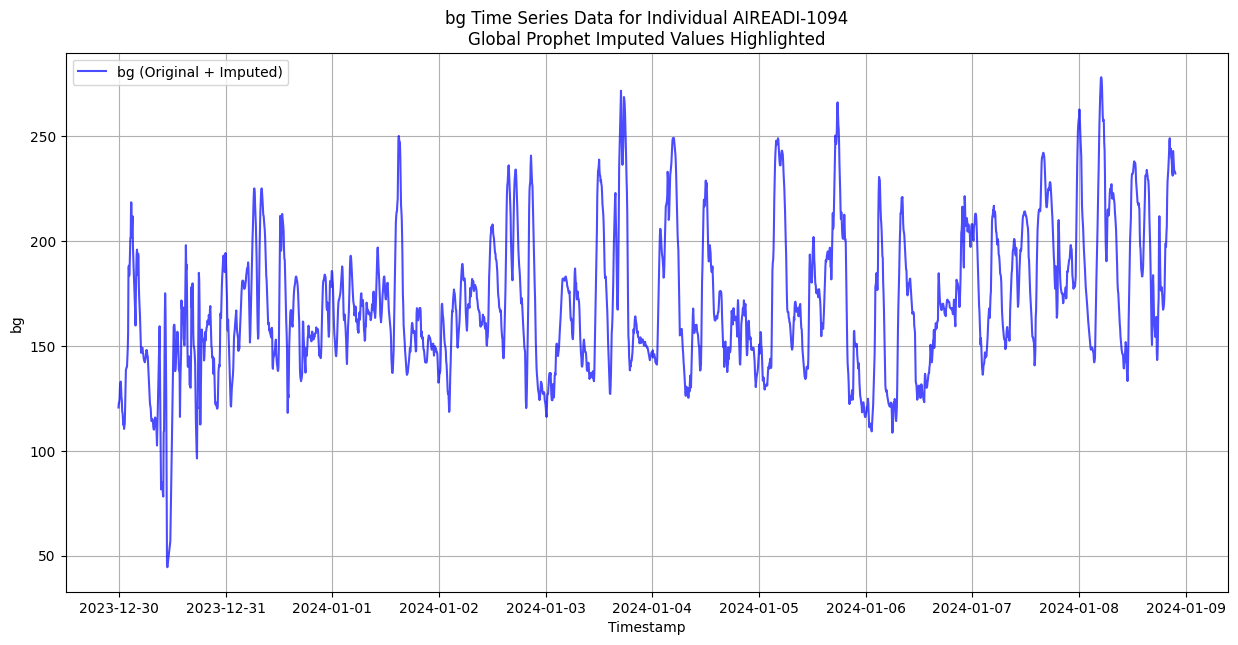

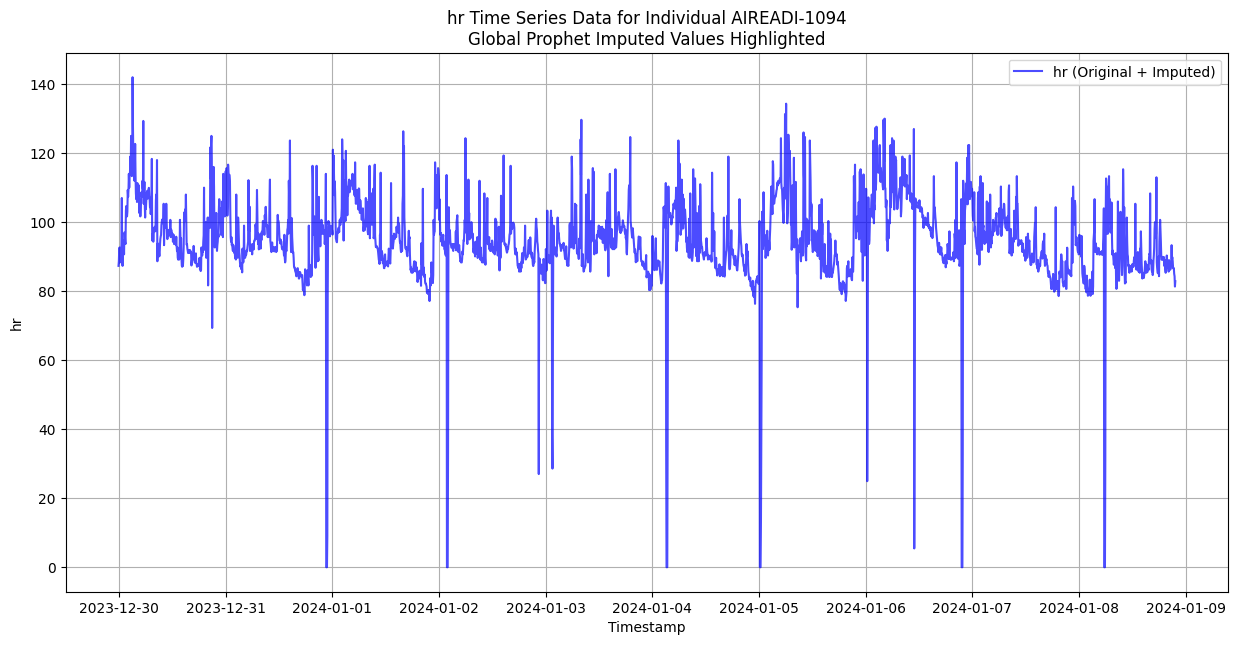

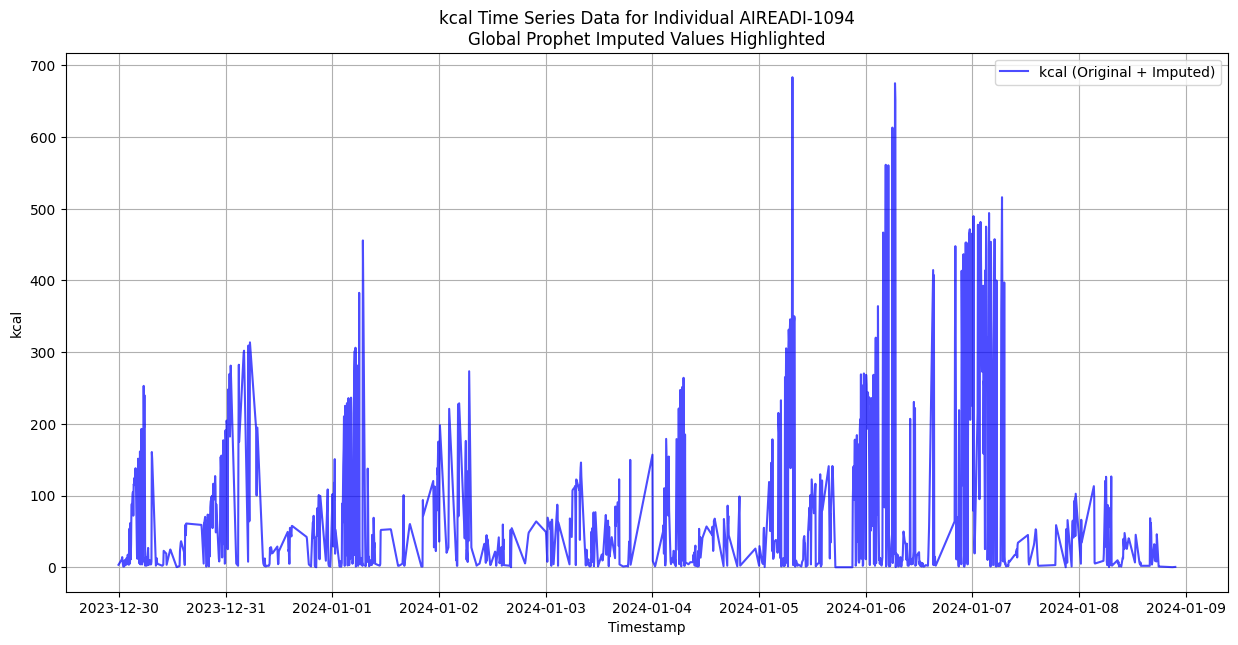

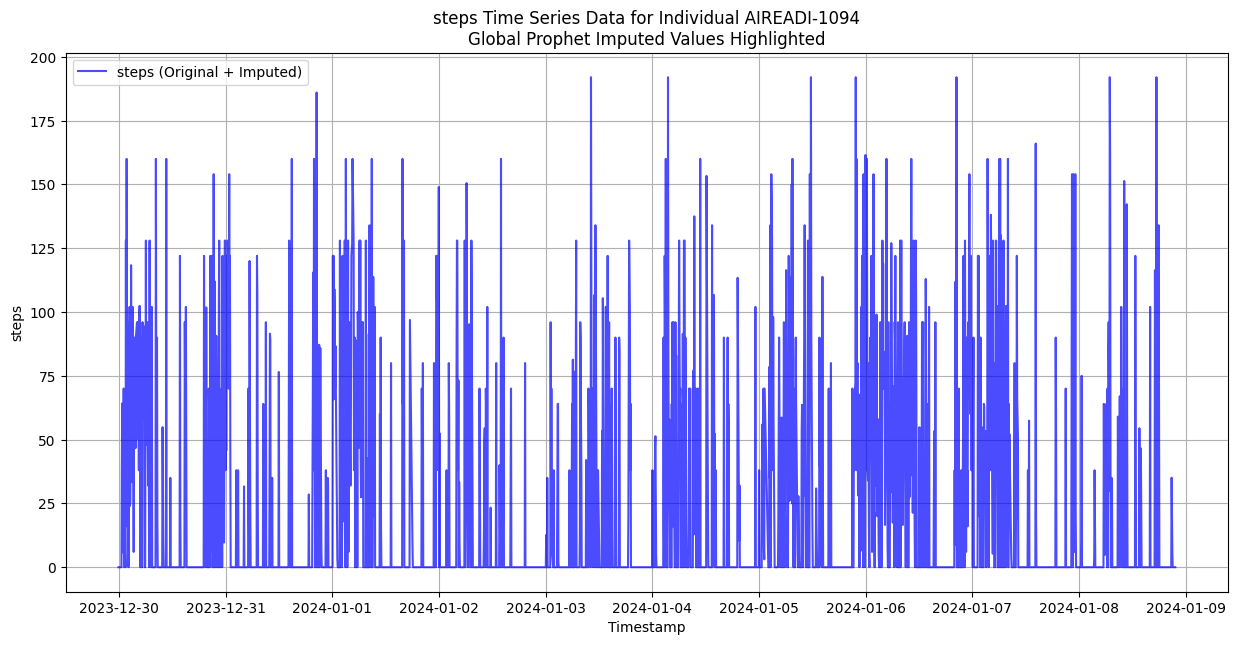

In [11]:
# prompt: Give me code to visualize the prophet imputed values for all variables for a random UUID from the previous code chunk

# Select a random UUID from the ones that had data processed by Prophet
# Ensure we only sample if there are any processed uuids in df
if not df['uuid'].empty:
    random_uuid_prophet = np.random.choice(df['uuid'].unique())
else:
    print("No data available after Prophet imputation to visualize.")
    random_uuid_prophet = None

if random_uuid_prophet:
    print(f"\nVisualizing Global Prophet imputed values for individual {random_uuid_prophet}:")

    # Get the data for this uuid from the final DataFrame (df)
    individual_df_prophet = df[df['uuid'] == random_uuid_prophet].copy()

    if individual_df_prophet.empty:
        print(f"Data not found for UUID {random_uuid_prophet} in the final DataFrame. Skipping visualization.")
    else:
        # Define columns to plot - the original variables now containing Prophet imputed values
        cols_to_plot = variables_for_prophet_imputation_plotting

        for col in cols_to_plot:
            # Check if the variable and its imputation indicator column exist
            indicator_col = f'is_{col}_prophet_imputed'
            if col in individual_df_prophet.columns and indicator_col in individual_df_prophet.columns:
                plt.figure(figsize=(15, 7))

                # Plot the entire time series for the variable (includes original and imputed)
                sns.lineplot(data=individual_df_prophet, x='timestamp', y=col, label=f'{col} (Original + Imputed)', color='blue', alpha=0.7, linewidth=1.5)

                # Highlight the Prophet imputed points using the indicator column
                # Filter rows where the indicator is 1
                prophet_imputed_points = individual_df_prophet[individual_df_prophet[indicator_col] == 1].copy()

                # Overlay the imputed points as scatter markers
                if not prophet_imputed_points.empty:
                     plt.scatter(prophet_imputed_points['timestamp'], prophet_imputed_points[col], color='red', zorder=5, label='Prophet Imputed Points', s=50, marker='o', edgecolor='black')

                plt.title(f'{col} Time Series Data for Individual {random_uuid_prophet}\nGlobal Prophet Imputed Values Highlighted')
                plt.xlabel('Timestamp')
                plt.ylabel(col)
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                 print(f"Variable '{col}' or indicator column '{indicator_col}' not found in DataFrame for UUID {random_uuid_prophet}. Skipping plot for this variable.")



In [12]:
def impute_time_series_data(df, imputation_vars, time_interval='5min'):
    """
    Cleans, imputes missing time series data, and engineers imputation-related features.

    Args:
        df (pd.DataFrame): The input DataFrame with 'uuid' and 'timestamp' columns.
        imputation_vars (list): A list of column names to impute.
        time_interval (str): The expected regular time interval of the data (e.g., '5min').

    Returns:
        pd.DataFrame: The DataFrame with missing values imputed and new features.
    """
    df_imputed_list = []
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['uuid', 'timestamp'])

    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek

    interval_td = pd.Timedelta(time_interval)
    short_gap_ffill_duration = pd.Timedelta('30 minutes')
    short_gap_interp_duration = pd.Timedelta('2 hours')

    for uuid in df['uuid'].unique():
        df_uuid = df[df['uuid'] == uuid].copy()
        if df_uuid.empty:
            continue

        df_uuid = df_uuid.drop_duplicates(subset=['timestamp']).sort_values(by='timestamp').set_index('timestamp')

        min_ts = df_uuid.index.min()
        max_ts = df_uuid.index.max()
        if pd.isnull(min_ts) or pd.isnull(max_ts):
             print(f"Warning: Invalid timestamp range for uuid {uuid}. Skipping imputation for this uuid.")
             df_uuid_reindexed = df_uuid
        else:
             full_index = pd.date_range(start=min_ts, end=max_ts, freq=time_interval)
             df_uuid_reindexed = df_uuid.reindex(full_index)

        # Feature: Indicator for any imputation
        df_uuid_reindexed['imputed_indicator'] = 0

        for var in imputation_vars:
            if var not in df_uuid_reindexed.columns:
                print(f"Warning: Variable '{var}' not found in reindexed data for uuid {uuid}. Skipping.")
                continue

            # Store original null mask before imputation
            original_null_mask = df_uuid_reindexed[var].isnull()

            if 'hour' not in df_uuid_reindexed.columns:
                 df_uuid_reindexed['hour'] = df_uuid_reindexed.index.hour
                 df_uuid_reindexed['dayofweek'] = df_uuid_reindexed.index.dayofweek

            # 1. Forward Fill with Decay (<= 30 mins)
            ffill_limit = int(short_gap_ffill_duration / interval_td)
            # Use ffill() instead of fillna(method='ffill')
            df_uuid_reindexed[var] = df_uuid_reindexed[var].ffill(limit=ffill_limit)

            # 2. Interpolation (<= 2 hours)
            interp_limit = int(short_gap_interp_duration / interval_td)
            df_uuid_reindexed[var] = df_uuid_reindexed[var].interpolate(method='linear', limit=interp_limit, limit_direction='both')

            # Exclude steps/kcal interpolation during likely sleep periods (e.g., 10 PM to 6 AM)
            if var in ['steps', 'kcal']:
                 sleep_hours = list(range(22, 24)) + list(range(6))
                 is_sleep_hour = df_uuid_reindexed.index.hour.isin(sleep_hours)
                 # Note: Remaining NaNs in sleep hours for steps/kcal are handled by contextual imputation

            # 3. Contextual Imputation for remaining NaNs
            nan_mask = df_uuid_reindexed[var].isnull()
            if nan_mask.any():
                if df_uuid_reindexed[var].notna().any():
                    hourly_avg = df_uuid_reindexed.groupby(df_uuid_reindexed.index.hour)[var].mean()
                    daily_avg = df_uuid_reindexed.groupby(df_uuid_reindexed.index.dayofweek)[var].mean()
                    individual_avg = df_uuid_reindexed[var].mean()
                else:
                    hourly_avg = pd.Series([], dtype='float64')
                    daily_avg = pd.Series([], dtype='float64')
                    individual_avg = np.nan

                for ts in df_uuid_reindexed.index[nan_mask]:
                    hour = ts.hour
                    dayofweek = ts.dayofweek
                    imputed_value = hourly_avg.get(hour)
                    if pd.isnull(imputed_value):
                        imputed_value = daily_avg.get(dayofweek)
                    if pd.isnull(imputed_value):
                        imputed_value = individual_avg
                    if pd.isnull(imputed_value):
                        global_avg = df[var].mean() # Use original df for global mean
                        imputed_value = global_avg if not pd.isnull(global_avg) else 0
                    df_uuid_reindexed.loc[ts, var] = imputed_value

        df_uuid_reindexed = df_uuid_reindexed.reset_index().rename(columns={'index': 'timestamp'})
        df_imputed_list.append(df_uuid_reindexed)

    if df_imputed_list:
        df_imputed = pd.concat(df_imputed_list, ignore_index=True)
    else:
        df_imputed = pd.DataFrame(columns=df.columns)

    if 'hour' in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=['hour', 'dayofweek'])

    return df_imputed

# List of variables to impute
variables_to_impute = ['bg', 'hr', 'kcal', 'steps']

df_imputed = impute_time_series_data(df, variables_to_impute)

print("\nDataFrame nulls after imputation and feature engineering:")
print(df_imputed.isnull().sum())
print(df_imputed.head()) # Display first few rows to see new features


DataFrame nulls after imputation and feature engineering:
timestamp                   0
uuid                        0
bg                          0
hr                          0
kcal                        0
steps                       0
bg_prophet_imputed          0
is_bg_prophet_imputed       0
hr_prophet_imputed          0
is_hr_prophet_imputed       0
kcal_prophet_imputed        0
is_kcal_prophet_imputed     0
steps_prophet_imputed       0
is_steps_prophet_imputed    0
imputed_indicator           0
dtype: int64
            timestamp          uuid     bg         hr      kcal  steps  \
0 2023-11-20 18:41:35  AIREADI-1062  83.00  57.033333  0.000000    0.0   
1 2023-11-20 18:46:35  AIREADI-1062  82.74  64.822222  0.000000    0.0   
2 2023-11-20 18:51:35  AIREADI-1062  81.74  53.066667  0.000000    0.0   
3 2023-11-20 18:56:35  AIREADI-1062  80.74  58.133333  0.037255  102.0   
4 2023-11-20 19:01:35  AIREADI-1062  80.00  49.066667  0.625490    0.0   

   bg_prophet_imputed  is_bg_prop

Select a random UUID to plot to see how imputation went



Visualizing original data with imputed points for individual AIREADI-1310:


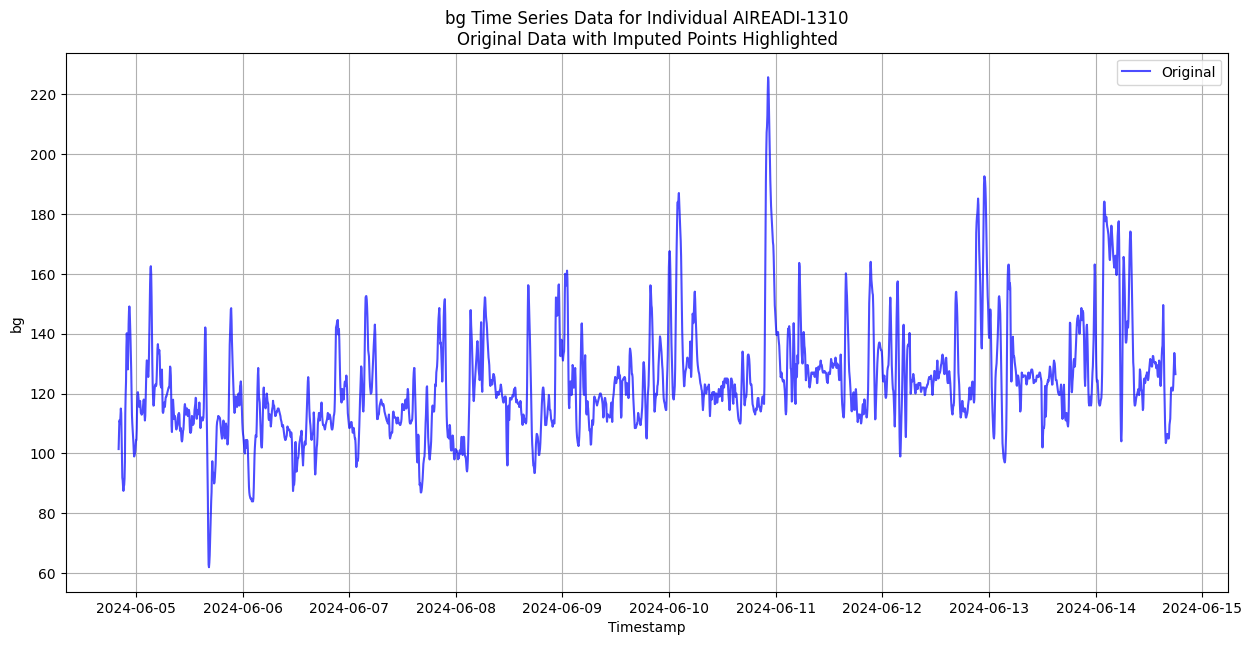

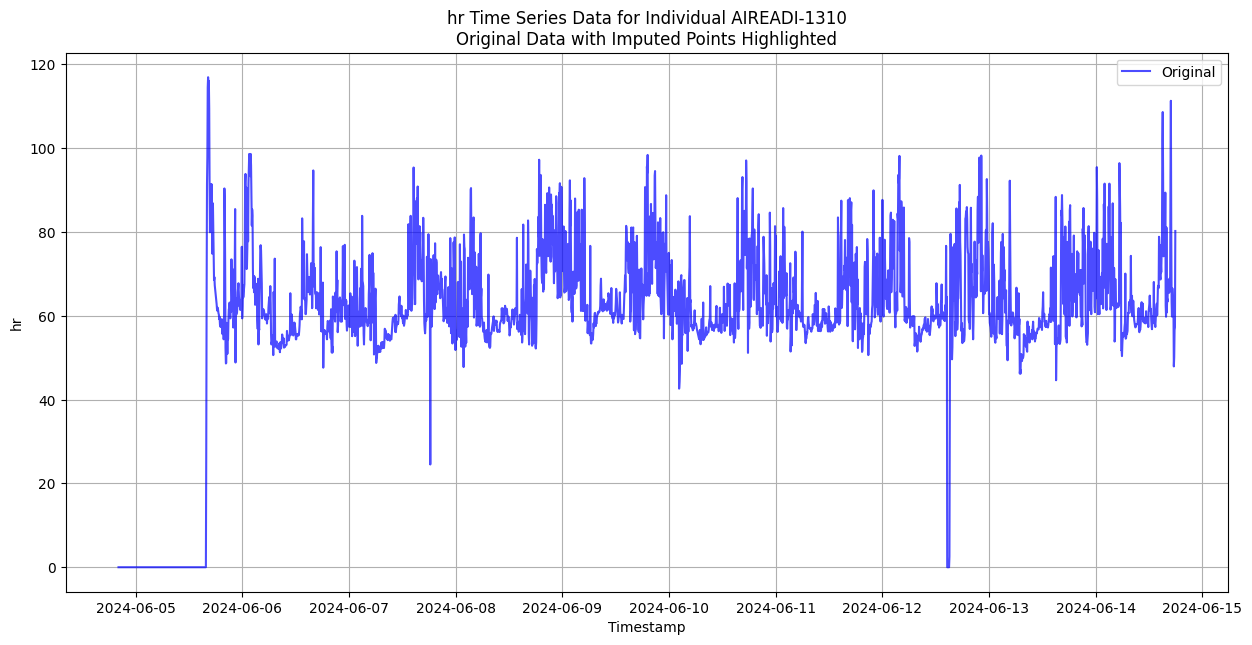

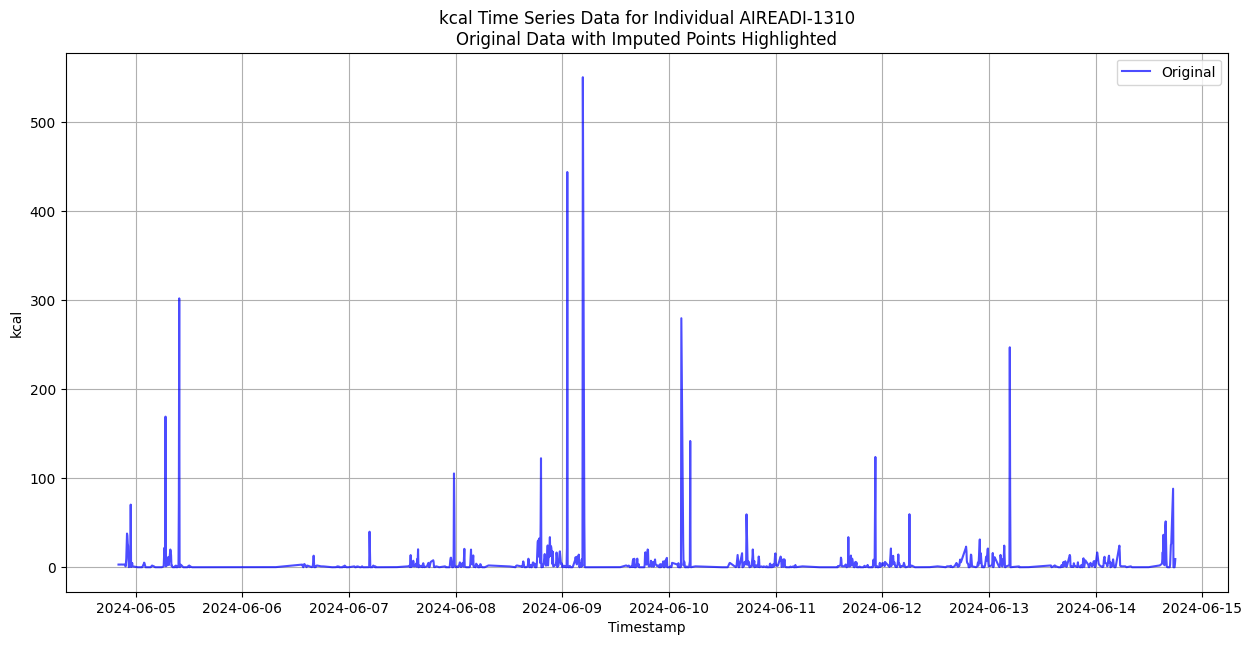

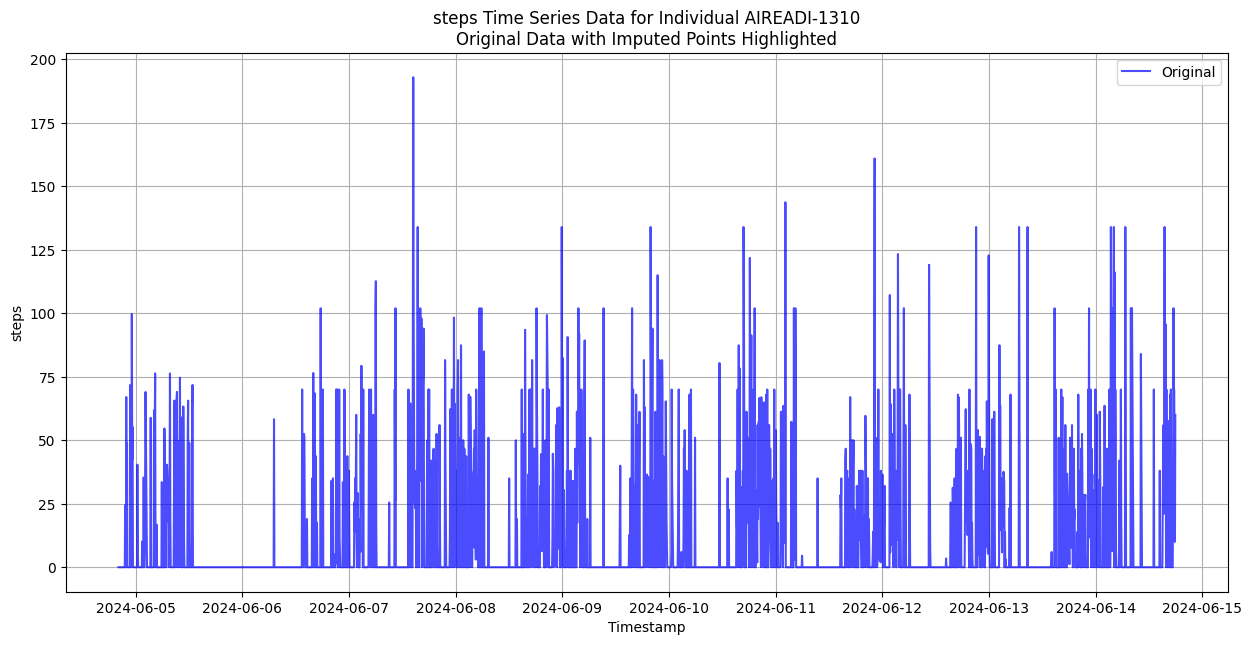

In [13]:


# Select a random UUID from the ones that had data processed
# Ensure we only sample if there are any processed uuids in df_imputed
if not df_imputed['uuid'].empty:
    random_uuid = np.random.choice(df_imputed['uuid'].unique())
else:
    print("No imputed data available to visualize.")
    random_uuid = None # Set to None if no uuids found

if random_uuid:
    print(f"\nVisualizing original data with imputed points for individual {random_uuid}:")

    # Get the original data for this uuid
    # Assuming the original df before imputation is still available as 'df'
    original_individual_df = df[df['uuid'] == random_uuid].copy()

    # Get the imputed data for this uuid
    imputed_individual_df = df_imputed[df_imputed['uuid'] == random_uuid].copy()

    if original_individual_df.empty or imputed_individual_df.empty:
        print(f"Data not found for UUID {random_uuid} in either original or imputed DataFrame. Skipping visualization.")
    else:
        # Define columns to plot (the ones that were imputed)
        cols_to_plot = variables_to_impute # Using the list from the imputation step

        for col in cols_to_plot:
            if col in original_individual_df.columns and col in imputed_individual_df.columns:
                plt.figure(figsize=(15, 7))

                # Plot the original data as the main line
                sns.lineplot(data=original_individual_df, x='timestamp', y=col, label='Original', color='blue', alpha=0.7, linewidth=1.5)

                # Highlight the imputed points
                # To find imputed points, align the original and imputed dataframes by timestamp
                # and check where original was null and imputed is not null.

                # Temporarily set timestamp as index for both for easy comparison
                original_indexed = original_individual_df.set_index('timestamp')
                imputed_indexed = imputed_individual_df.set_index('timestamp')

                # Create the mask using the aligned, time-indexed dataframes
                # This mask is True at timestamps where the original data was null
                imputed_points_mask = original_indexed[col].isnull() & imputed_indexed[col].notna()

                # Select the imputed points from the imputed_indexed dataframe
                imputed_points_to_plot = imputed_indexed.loc[imputed_points_mask].reset_index()

                # Overlay the imputed points as scatter markers
                if not imputed_points_to_plot.empty:
                     plt.scatter(imputed_points_to_plot['timestamp'], imputed_points_to_plot[col], color='red', zorder=5, label='Imputed Points', s=50, marker='o', edgecolor='black') # Use scatter for points


                plt.title(f'{col} Time Series Data for Individual {random_uuid}\nOriginal Data with Imputed Points Highlighted')
                plt.xlabel('Timestamp')
                plt.ylabel(col)
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                 print(f"Variable '{col}' not found in both original and imputed DataFrames for UUID {random_uuid}. Skipping plot for this variable.")

If there are still NaN values remaining, use this to fill them in.

In [14]:
def fill_nan_values(df, group_col='uuid', timestamp_col='timestamp'):
    """
    Fill NaN values in DataFrame using forward fill, then backward fill as fallback.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing NaN values
    group_col : str, default 'uuid'
        Column name to group by (e.g., person/patient identifier)
    timestamp_col : str, default 'timestamp'
        Column name for timestamp to ensure proper ordering

    Returns:
    --------
    pandas.DataFrame
        DataFrame with NaN values filled
    dict
        Summary of NaN filling operations
    """

    # Create a copy to avoid modifying original data
    df_filled = df.copy()

    # Initialize summary dictionary
    fill_summary = {
        'total_nans_before': df.isnull().sum().sum(),
        'columns_with_nans': {},
        'total_nans_after': 0,
        'rows_dropped': 0
    }

    print("NaN Filling Summary:")
    print("=" * 50)

    # Check NaN counts before filling
    nan_counts_before = df.isnull().sum()
    columns_with_nans = nan_counts_before[nan_counts_before > 0]

    if len(columns_with_nans) == 0:
        print("No NaN values found in the data.")
        return df_filled, fill_summary

    print(f"Total NaN values before filling: {fill_summary['total_nans_before']}")
    print("\nNaN counts by column before filling:")
    for col, count in columns_with_nans.items():
        print(f"  {col}: {count}")
        fill_summary['columns_with_nans'][col] = {
            'before': count,
            'filled_forward': 0,
            'filled_backward': 0,
            'remaining': 0
        }

    # Sort by group and timestamp to ensure proper order for forward/backward fill
    df_filled = df_filled.sort_values([group_col, timestamp_col])

    # Process each group separately
    filled_groups = []

    for group_id in df_filled[group_col].unique():
        print(f"\nProcessing group: {group_id}")

        # Get data for this group
        group_data = df_filled[df_filled[group_col] == group_id].copy()

        # Store original NaN positions for tracking
        original_nans = {}
        for col in columns_with_nans.index:
            if col in group_data.columns:
                original_nans[col] = group_data[col].isnull()

        # Forward fill first
        group_data_ffill = group_data.fillna(method='ffill')

        # Count what was filled by forward fill
        for col in columns_with_nans.index:
            if col in group_data.columns:
                filled_by_ffill = original_nans[col] & ~group_data_ffill[col].isnull()
                fill_summary['columns_with_nans'][col]['filled_forward'] += filled_by_ffill.sum()

        # Backward fill for remaining NaNs
        group_data_filled = group_data_ffill.fillna(method='bfill')

        # Count what was filled by backward fill
        for col in columns_with_nans.index:
            if col in group_data.columns:
                still_nan_after_ffill = group_data_ffill[col].isnull()
                filled_by_bfill = still_nan_after_ffill & ~group_data_filled[col].isnull()
                fill_summary['columns_with_nans'][col]['filled_backward'] += filled_by_bfill.sum()

        # Count remaining NaNs
        for col in columns_with_nans.index:
            if col in group_data.columns:
                remaining_nans = group_data_filled[col].isnull().sum()
                fill_summary['columns_with_nans'][col]['remaining'] += remaining_nans

        # Check if there are still NaNs in this group
        remaining_nans_in_group = group_data_filled.isnull().sum().sum()
        if remaining_nans_in_group > 0:
            print(f"  Warning: {remaining_nans_in_group} NaN values remain in group {group_id}")
            print("  These might be columns that are entirely NaN for this group")

        filled_groups.append(group_data_filled)

    # Combine all groups back together
    df_filled = pd.concat(filled_groups, ignore_index=True)

    # Final NaN count
    fill_summary['total_nans_after'] = df_filled.isnull().sum().sum()

    # Print summary
    print("\n" + "=" * 50)
    print("FILLING SUMMARY:")
    print(f"Total NaN values before: {fill_summary['total_nans_before']}")
    print(f"Total NaN values after:  {fill_summary['total_nans_after']}")
    print(f"Total NaN values filled: {fill_summary['total_nans_before'] - fill_summary['total_nans_after']}")

    print("\nDetailed summary by column:")
    for col, stats in fill_summary['columns_with_nans'].items():
        print(f"  {col}:")
        print(f"    Before: {stats['before']}")
        print(f"    Filled by forward fill: {stats['filled_forward']}")
        print(f"    Filled by backward fill: {stats['filled_backward']}")
        print(f"    Remaining: {stats['remaining']}")

    # Handle any remaining NaNs
    if fill_summary['total_nans_after'] > 0:
        print(f"\nWarning: {fill_summary['total_nans_after']} NaN values still remain!")
        print("Options to handle remaining NaNs:")
        print("1. Drop rows with remaining NaNs")
        print("2. Fill with mean/median values")
        print("3. Use interpolation")

        # Show which columns still have NaNs
        remaining_nans = df_filled.isnull().sum()
        remaining_nan_cols = remaining_nans[remaining_nans > 0]
        if len(remaining_nan_cols) > 0:
            print("\nColumns with remaining NaNs:")
            for col, count in remaining_nan_cols.items():
                print(f"  {col}: {count}")

    return df_filled, fill_summary

def handle_remaining_nans(df, strategy='drop', fill_value=None):
    """
    Handle any remaining NaN values after forward/backward fill.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame that may still contain NaN values
    strategy : str, default 'drop'
        Strategy to handle remaining NaNs:
        - 'drop': Drop rows with any NaN values
        - 'mean': Fill with column mean
        - 'median': Fill with column median
        - 'zero': Fill with zero
        - 'value': Fill with specified value
    fill_value : float, optional
        Value to use when strategy='value'

    Returns:
    --------
    pandas.DataFrame
        DataFrame with all NaN values handled
    dict
        Summary of operations performed
    """

    df_clean = df.copy()
    summary = {
        'nans_before': df.isnull().sum().sum(),
        'strategy_used': strategy,
        'rows_dropped': 0,
        'values_filled': 0
    }

    if summary['nans_before'] == 0:
        print("No remaining NaN values to handle.")
        return df_clean, summary

    print(f"\nHandling {summary['nans_before']} remaining NaN values using strategy: '{strategy}'")

    if strategy == 'drop':
        rows_before = len(df_clean)
        df_clean = df_clean.dropna()
        summary['rows_dropped'] = rows_before - len(df_clean)
        print(f"Dropped {summary['rows_dropped']} rows containing NaN values")

    elif strategy == 'mean':
        # Only fill numeric columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].isnull().any():
                fill_val = df_clean[col].mean()
                nan_count = df_clean[col].isnull().sum()
                df_clean[col] = df_clean[col].fillna(fill_val)
                summary['values_filled'] += nan_count
                print(f"Filled {nan_count} NaN values in '{col}' with mean: {fill_val:.4f}")

    elif strategy == 'median':
        # Only fill numeric columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_clean[col].isnull().any():
                fill_val = df_clean[col].median()
                nan_count = df_clean[col].isnull().sum()
                df_clean[col] = df_clean[col].fillna(fill_val)
                summary['values_filled'] += nan_count
                print(f"Filled {nan_count} NaN values in '{col}' with median: {fill_val:.4f}")

    elif strategy == 'zero':
        nan_count = df_clean.isnull().sum().sum()
        df_clean = df_clean.fillna(0)
        summary['values_filled'] = nan_count
        print(f"Filled {nan_count} NaN values with zero")

    elif strategy == 'value':
        if fill_value is None:
            raise ValueError("fill_value must be specified when strategy='value'")
        nan_count = df_clean.isnull().sum().sum()
        df_clean = df_clean.fillna(fill_value)
        summary['values_filled'] = nan_count
        print(f"Filled {nan_count} NaN values with: {fill_value}")

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    final_nans = df_clean.isnull().sum().sum()
    if final_nans > 0:
        print(f"Warning: {final_nans} NaN values still remain after {strategy} strategy")
    else:
        print("All NaN values successfully handled!")

    return df_clean, summary


df_filled, fill_summary = fill_nan_values(df, group_col='uuid', timestamp_col='timestamp')

#If there are still NaNs after forward/backward fill, handle them:
df_clean, clean_summary = handle_remaining_nans(df_filled, strategy='zero')




NaN Filling Summary:
No NaN values found in the data.
No remaining NaN values to handle.


# Feature engineering

Engineer some relevent time series features


In [15]:


# Feature Engineering Function
def engineer_time_series_features(df, variables, time_interval='5min'):
    """
    Engineers standard time series features and lag/rolling features
    for specified variables and their Prophet imputed versions.

    Args:
        df (pd.DataFrame): The input DataFrame with 'uuid' and 'timestamp'.
                           Assumes it includes original variables and
                           Prophet imputed variables (e.g., 'bg', 'bg_prophet_imputed').
        variables (list): A list of base variable names (e.g., ['bg', 'hr']).
        time_interval (str): The expected regular time interval (e.g., '5min').

    Returns:
        pd.DataFrame: The DataFrame with new engineered features.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by=['uuid', 'timestamp'])

    # --- Time-based Features ---
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    # Use isocalendar().week and handle potential multiple modes gracefully
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Optional: Sine/Cosine transformations for cyclic features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # --- Lagged Features and Rolling Statistics ---

    # Define common lag periods and rolling window sizes
    lags_min = [
        5,
        10,
        15,
        20,
        25, # Lag 5 - PACF should be close to 0 after this
        60   # 1 hour

    ]

    # Convert lag minutes to periods based on the dominant time interval
    def get_dominant_interval_minutes(df_uuid):
        if df_uuid.empty or len(df_uuid) < 2:
            return np.nan
        diffs = df_uuid['timestamp'].diff().dropna()
        # Calculate the mode, handle multiple modes by taking the first
        mode_diff = diffs.mode()
        if mode_diff.empty:
            return np.nan
        return mode_diff.iloc[0].total_seconds() / 60.0

    # Calculate dominant interval for each uuid and get the median
    dominant_intervals = df.groupby('uuid').apply(get_dominant_interval_minutes)
    median_dominant_interval = dominant_intervals.median()

    if pd.isnull(median_dominant_interval) or median_dominant_interval <= 0:
        print(f"Warning: Could not determine dominant time interval from data. Using provided time_interval: {time_interval}")
        interval_minutes = pd.Timedelta(time_interval).total_seconds() / 60.0
    else:
        interval_minutes = median_dominant_interval
        print(f"Estimated dominant time interval from data: {interval_minutes:.2f} minutes.")

    lag_periods = [max(1, round(lag / interval_minutes)) for lag in lags_min]
    lag_periods = sorted(list(set(lag_periods)))
    print(f"Generated lag periods based on estimated interval: {lag_periods}")

    rolling_windows_min = [
        15,
        30,
        60   # 1 hour
    ]

    rolling_window_periods = [max(1, round(window / interval_minutes)) for window in rolling_windows_min]
    rolling_window_periods = sorted(list(set(rolling_window_periods)))
    print(f"Generated rolling window periods based on estimated interval: {rolling_window_periods}")

    # Combine original variables and their Prophet imputed versions
    all_vars_to_process = []
    for var in variables:
        all_vars_to_process.append(var) # Original variable
        prophet_var = f'{var}_prophet_imputed'
        if prophet_var in df.columns:
            all_vars_to_process.append(prophet_var)
        indicator_var = f'is_{var}_prophet_imputed'
        if indicator_var in df.columns:
             all_vars_to_process.append(indicator_var)

    # Apply features per uuid
    df_features_list = []

    # Set timestamp as index for easier time-based operations within groups
    df = df.set_index('timestamp')

    for uuid, df_uuid in df.groupby('uuid'):
        if df_uuid.empty:
            continue

        # Ensure index is sorted for shift and rolling operations
        df_uuid = df_uuid.sort_index()

        # Create a list to hold new feature columns for this uuid's dataframe chunk
        new_cols_list = []

        # Apply Lagged Features
        for var in all_vars_to_process:
            if var in df_uuid.columns:
                for lag_p in lag_periods:
                    new_col_name = f'{var}_lag_{lag_p}p'
                    # Calculate the lagged series and add it to the list
                    lagged_series = df_uuid[var].shift(periods=lag_p)
                    new_cols_list.append(lagged_series.rename(new_col_name))

        # Apply Rolling Window Features (Mean, Median, Std Dev, Min, Max)
        # Also calculate Difference from Rolling Mean here
        for var in all_vars_to_process:
             if var in df_uuid.columns:
                for window_p in rolling_window_periods:
                     # Calculate rolling features and add them to the list
                     roll_mean = df_uuid[var].rolling(window=window_p, min_periods=1).mean()
                     roll_median = df_uuid[var].rolling(window=window_p, min_periods=1).median()
                     roll_std = df_uuid[var].rolling(window=window_p, min_periods=1).std()
                     roll_min = df_uuid[var].rolling(window=window_p, min_periods=1).min()
                     roll_max = df_uuid[var].rolling(window=window_p, min_periods=1).max()

                     new_cols_list.append(roll_mean.rename(f'{var}_roll_mean_{window_p}p'))
                     #new_cols_list.append(roll_median.rename(f'{var}_roll_median_{window_p}p'))
                     new_cols_list.append(roll_std.rename(f'{var}_roll_std_{window_p}p'))
                     #new_cols_list.append(roll_min.rename(f'{var}_roll_min_{window_p}p'))
                     #new_cols_list.append(roll_max.rename(f'{var}_roll_max_{window_p}p'))

                     # Feature: Difference from Rolling Mean (Deviation from average)
                     # Calculate using the just-calculated rolling mean and the original variable
                     new_cols_list.append((df_uuid[var] - roll_mean).rename(f'{var}_diff_roll_mean_{window_p}p'))


        # Concatenate the new feature columns to the original df_uuid chunk
        if new_cols_list:
            # Pass df_uuid as the first element to include original columns
            df_uuid_with_features = pd.concat([df_uuid] + new_cols_list, axis=1)
        else:
            df_uuid_with_features = df_uuid # No new features added

        df_features_list.append(df_uuid_with_features)

    # Concatenate all processed DataFrames from the list
    if df_features_list:
        df_featured = pd.concat(df_features_list)
    else:
        df_featured = pd.DataFrame(columns=df.columns) # Return empty if no data was processed

    # Reset index to make timestamp a column again
    df_featured = df_featured.reset_index()

    print("\nDataFrame after Feature Engineering:")
    print(df_featured.head())
    print("\nEngineered Features:")
    # Need a way to compare with the original columns to print only new ones
    # Assuming the input 'df' is the state before this function was called.
    # Let's get the columns of the input df (before setting index)
    original_cols_set = set(df.columns) # This is the df *after* setting index, but before adding features
    # Get columns from the final df_featured and subtract the ones that were in df before features
    engineered_cols = set(df_featured.columns) - original_cols_set
    print(sorted(list(engineered_cols)))


    return df_featured

# Apply the feature engineering function
variables_for_features = ['bg', 'hr', 'kcal', 'steps']

# Ensure df holds the Prophet-imputed data
# The previous cell updates df to df_prophet_imputed
# So, df here is the DataFrame resulting from Prophet imputation.
df_final_featured = engineer_time_series_features(df_clean, variables_for_features)

# Update df for any potential subsequent steps
df = df_final_featured.copy()

Estimated dominant time interval from data: 5.00 minutes.
Generated lag periods based on estimated interval: [1, 2, 3, 4, 5, 12]
Generated rolling window periods based on estimated interval: [3, 6, 12]

DataFrame after Feature Engineering:
            timestamp          uuid     bg         hr      kcal  steps  \
0 2023-11-20 18:41:35  AIREADI-1062  83.00  57.033333  0.000000    0.0   
1 2023-11-20 18:46:35  AIREADI-1062  82.74  64.822222  0.000000    0.0   
2 2023-11-20 18:51:35  AIREADI-1062  81.74  53.066667  0.000000    0.0   
3 2023-11-20 18:56:35  AIREADI-1062  80.74  58.133333  0.037255  102.0   
4 2023-11-20 19:01:35  AIREADI-1062  80.00  49.066667  0.625490    0.0   

   bg_prophet_imputed  is_bg_prophet_imputed  hr_prophet_imputed  \
0               83.00                      0           57.033333   
1               82.74                      0           64.822222   
2               81.74                      0           53.066667   
3               80.74                      

In [16]:
columns_without_prophet = [col for col in df.columns if 'prophet' not in col]
df = df[columns_without_prophet]
print(df)


                timestamp          uuid          bg         hr       kcal  \
0     2023-11-20 18:41:35  AIREADI-1062   83.000000  57.033333   0.000000   
1     2023-11-20 18:46:35  AIREADI-1062   82.740000  64.822222   0.000000   
2     2023-11-20 18:51:35  AIREADI-1062   81.740000  53.066667   0.000000   
3     2023-11-20 18:56:35  AIREADI-1062   80.740000  58.133333   0.037255   
4     2023-11-20 19:01:35  AIREADI-1062   80.000000  49.066667   0.625490   
...                   ...           ...         ...        ...        ...   
55772 2024-08-03 13:59:44  AIREADI-7343  115.000000  89.457271  84.323176   
55773 2024-08-03 14:04:44  AIREADI-7343  115.346667  89.452676  84.277726   
55774 2024-08-03 14:09:44  AIREADI-7343  116.346667  89.477498  84.405339   
55775 2024-08-03 14:14:44  AIREADI-7343  115.613333  89.472903  84.359890   
55776 2024-08-03 14:19:44  AIREADI-7343  108.146667  89.468308  84.314440   

            steps  hour  dayofweek  is_weekend  hour_sin  ...  \
0        0

# Variable selection

## Initial reduction
Attention-based and permutation-based feature selection to winnow down the initial variable set



In [17]:

# Helper function to create sequences for LSTM
def create_sequences(data, target_col, sequence_length=12, forecast_horizons=[1, 2, 3, 6, 12]):
    sequences = []
    targets = []

    max_horizon = max(forecast_horizons)

    # Ensure data is sorted by uuid and timestamp before creating sequences
    data = data.sort_values(by=['uuid', 'timestamp'])

    for uuid in data['uuid'].unique():
        person_data = data[data['uuid'] == uuid].copy()

        if len(person_data) < sequence_length + max_horizon:
            # print(f"Warning: Not enough data for uuid {uuid} for sequence creation. Skipping.")
            continue

        feature_cols = [col for col in person_data.columns if col not in ['uuid', 'timestamp', target_col]]
        person_features = person_data[feature_cols].values
        person_targets = person_data[target_col].values

        # Check for NaN values within the sequence and target window
        # This is a more robust check than the one inside the loop
        # It ensures that for each potential sequence and its corresponding targets
        # up to the max_horizon, there are no NaNs.
        for i in range(len(person_data) - sequence_length - max_horizon + 1):
             # Check features in the current sequence
             if np.any(np.isnan(person_features[i:i+sequence_length])):
                  # print(f"Warning: NaN values in features for sequence starting at index {i} for uuid {uuid}. Skipping.")
                  continue
             # Check targets up to max_horizon
             if np.any(np.isnan(person_targets[i+sequence_length : i+sequence_length+max_horizon])):
                  # print(f"Warning: NaN values in targets for sequence starting at index {i} for uuid {uuid} up to horizon {max_horizon}. Skipping.")
                  continue

             sequences.append(person_features[i:i+sequence_length])
             # Append targets for all specified horizons
             horizon_targets = [person_targets[i + sequence_length + h -1] for h in forecast_horizons]
             targets.append(horizon_targets)


    if len(sequences) == 0:
        print("No valid sequences created after checking for NaNs and minimum length.")
        # Return empty arrays with correct shapes to avoid errors later
        # Assuming feature_cols were successfully identified
        if 'feature_cols' in locals() and feature_cols:
             # Shape: (0, sequence_length, num_features)
             empty_sequences = np.array([], dtype=np.float32).reshape(0, sequence_length, len(feature_cols))
        else:
              # Fallback if feature_cols was not defined or empty
              empty_sequences = np.array([], dtype=np.float32).reshape(0, sequence_length, 0)

        # Shape: (0, num_horizons)
        empty_targets = np.array([], dtype=np.float32).reshape(0, len(forecast_horizons))
        return empty_sequences, empty_targets

    return np.array(sequences), np.array(targets)
# =============================================================================
# 1. ATTENTION-BASED FEATURE SELECTION FOR RNN/LSTM
# =============================================================================

class AttentionFeatureSelector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, attention_dim=64):
        super(AttentionFeatureSelector, self).__init__()
        self.hidden_size = hidden_size
        self.attention_dim = attention_dim

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.feature_attention = nn.Sequential(
            nn.Linear(hidden_size, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, input_size),
            nn.Softmax(dim=-1)
        )

        self.temporal_attention = nn.Sequential(
            nn.Linear(hidden_size, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, 1)
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, (hidden, _) = self.lstm(x)

        feature_weights = self.feature_attention(hidden[-1])

        attended_input = x * feature_weights.unsqueeze(1)

        lstm_out_attended, (final_hidden, _) = self.lstm(attended_input)

        temporal_scores = self.temporal_attention(lstm_out_attended)
        temporal_weights = torch.softmax(temporal_scores, dim=1)

        attended_output = torch.sum(lstm_out_attended * temporal_weights, dim=1)

        output = self.fc(attended_output)

        return output, feature_weights, temporal_weights

def attention_based_feature_selection(X, y, feature_names, top_k=None, epochs=100, lr=0.001):
    input_size = X.shape[2]
    hidden_size = min(64, input_size * 2)
    output_size = y.shape[1] if len(y.shape) > 1 else 1

    model = AttentionFeatureSelector(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output, feature_weights, temporal_weights = model(X)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        _, feature_weights, _ = model(X)

    avg_feature_weights = feature_weights.mean(dim=0).numpy()

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': avg_feature_weights
    }).sort_values('importance', ascending=False)

    if top_k:
        selected_features = feature_importance_df.head(top_k)['feature'].tolist()
        selected_indices = [feature_names.index(feat) for feat in selected_features]
    else:
        threshold = np.median(avg_feature_weights)
        selected_indices = np.where(avg_feature_weights > threshold)[0].tolist()
        selected_features = [feature_names[i] for i in selected_indices]

    return selected_indices, selected_features, feature_importance_df, model

# =============================================================================
# 2. PERMUTATION IMPORTANCE FOR RNN/LSTM
# =============================================================================

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='LSTM'):
        super(SimpleRNN, self).__init__()
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hidden, _) = self.rnn(x) if hasattr(self.rnn, 'bias_ih_l0') else (self.rnn(x)[0], self.rnn(x)[1])
        if isinstance(hidden, tuple):
            hidden = hidden[0]
        return self.fc(hidden[-1])

def train_rnn_model(X, y, input_size, hidden_size, output_size, rnn_type='LSTM', epochs=50):
    model = SimpleRNN(input_size, hidden_size, output_size, rnn_type)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return model

def permutation_importance_rnn(X, y, feature_names, rnn_type='LSTM', n_repeats=10):
    input_size = X.shape[2]
    hidden_size = min(64, input_size * 2)
    output_size = y.shape[1] if len(y.shape) > 1 else 1

    print("Training baseline model...")
    model = train_rnn_model(X, y, input_size, hidden_size, output_size, rnn_type)

    model.eval()
    with torch.no_grad():
        baseline_pred = model(X)
        baseline_mse = nn.MSELoss()(baseline_pred, y).item()

    print(f"Baseline MSE: {baseline_mse:.4f}")

    feature_importance = {}

    for feature_idx in range(input_size):
        if feature_idx % 10 == 0:
          print(f"Testing feature {feature_idx}: {feature_names[feature_idx]}")

        importance_scores = []

        for repeat in range(n_repeats):
            X_permuted = X.clone()

            perm_indices = torch.randperm(X.shape[0])
            X_permuted[:, :, feature_idx] = X_permuted[perm_indices, :, feature_idx]

            with torch.no_grad():
                permuted_pred = model(X_permuted)
                permuted_mse = nn.MSELoss()(permuted_pred, y).item()

            importance = permuted_mse - baseline_mse
            importance_scores.append(importance)

        avg_importance = np.mean(importance_scores)
        std_importance = np.std(importance_scores)

        feature_importance[feature_names[feature_idx]] = {
            'importance_mean': avg_importance,
            'importance_std': std_importance,
            'feature_idx': feature_idx
        }

    importance_df = pd.DataFrame.from_dict(feature_importance, orient='index')
    importance_df = importance_df.sort_values('importance_mean', ascending=False)

    return importance_df

# =============================================================================
# 5. USAGE EXAMPLE AND COMPARISON FUNCTION
# =============================================================================

def compare_feature_selection_methods(X, y, feature_names, methods=['attention', 'permutation'], top_k = None):
    results = {}

    if 'attention' in methods:
        print("\n" + "="*50)
        print("ATTENTION-BASED FEATURE SELECTION")
        print("="*50)
        selected_idx, selected_feat, importance_df, model = attention_based_feature_selection(
            X, y, feature_names, top_k = top_k
        )
        results['attention'] = {
            'selected_indices': selected_idx,
            'selected_features': selected_feat,
            'importance_df': importance_df,
            'model': model
        }

    if 'permutation' in methods:
        print("\n" + "="*50)
        print("PERMUTATION IMPORTANCE")
        print("="*50)
        importance_df = permutation_importance_rnn(X, y, feature_names, 'LSTM')
        top_features = importance_df
        selected_idx = [importance_df.loc[feat, 'feature_idx'] for feat in top_features.index]
        results['permutation'] = {
            'selected_indices': selected_idx,
            'selected_features': list(top_features.index),
            'importance_df': importance_df
        }

    return results

In [ ]:
# Define the directory in Google Drive where you want to save the cache
# Ensure this directory exists in your Google Drive
# Example: '/content/drive/My Drive/YourProjectFolder'
cache_dir_fs = '/content/drive/My Drive/DiabetesML' # Update this path if different from the previous cache

# Define the full path for the feature selection cache file
cache_filepath_fs = os.path.join(cache_dir_fs, 'feature_selection_cache.pkl')

# Ensure the cache directory exists
os.makedirs(cache_dir_fs, exist_ok=True)

# Check if the feature selection cache file exists
if os.path.exists(cache_filepath_fs):
    print(f"Loading cached feature selection results from {cache_filepath_fs}...")
    try:
        with open(cache_filepath_fs, 'rb') as f:
            results = pickle.load(f) # Load the entire results dictionary
        print("Feature selection cache loaded successfully.")

        # You would typically also load or regenerate your scaled X and y data (X_clean_scaled, y_clean_scaled)
        # and feature_names_clean here, as the rest of the code that *uses* 'results'
        # will likely depend on these variables being available.
        # Ensure X_clean_scaled, y_clean_scaled, and feature_names_clean are available
        # before the rest of the code that utilizes 'results'.
        # If they are not available, you must generate them from df *after* loading the cache.

    except Exception as e:
        print(f"Error loading feature selection cache file: {e}. Proceeding to re-run feature selection.")
        # If loading fails, delete the corrupted cache file and proceed to re-run
        os.remove(cache_filepath_fs)
        print(f"Removed potentially corrupted cache file: {cache_filepath_fs}")
        # Set 'results' to None to trigger the re-running of the feature selection
        results = None

else:
    print("No feature selection cache file found. Running feature selection methods...")
    # Set 'results' to None to trigger the re-running
    results = None


# --- Feature Selection Code (runs only if cache not loaded) ---
# This part contains your original feature selection logic

if results is None:
    print("Starting Feature Selection Comparison...")

    try:
        # Ensure X_clean_scaled, y_clean_scaled, and feature_names_clean are available
        # at this point. If they are generated by previous cells, make sure those
        # cells have been run. If they depend on 'df', ensure 'df' is available.
        if 'X_clean_scaled' not in globals() or 'y_clean_scaled' not in globals() or 'feature_names_clean' not in globals() or 'df' not in globals():
             print("Error: Required variables (X_clean_scaled, y_clean_scaled, feature_names_clean, or df) not found.")
             # You might need to regenerate them here if they are not globally available
             # Example:
             # X_clean, y_clean = create_sequences(df, 'bg', sequence_length=12)
             # ... scale X_clean and y_clean to get X_clean_scaled, y_clean_scaled ...
             # feature_names_clean = [col for col in df.columns if col not in ['uuid', 'timestamp', 'bg']]
             print("Attempting to regenerate data for feature selection...")
             # Assuming create_sequences and scaling functions are available
             # This is a simplified example; adjust based on your actual data pipeline
             try:
                  # create_sequences returns NumPy arrays
                  X_clean, y_clean = create_sequences(df, 'bg', sequence_length=12)

                  scaler_X_clean = StandardScaler()
                  scaler_y_clean = StandardScaler()

                  X_clean_shape_original = X_clean.shape
                  # Reshape NumPy array for scaling
                  X_clean_reshaped_for_scaling = X_clean.reshape(-1, X_clean_shape_original[-1])
                  X_clean_scaled_flat = scaler_X_clean.fit_transform(X_clean_reshaped_for_scaling)
                  # Reshape back to original 3D shape for PyTorch
                  X_clean_scaled = torch.FloatTensor(X_clean_scaled_flat.reshape(X_clean_shape_original))

                  y_clean_shape_original = y_clean.shape
                  if len(y_clean_shape_original) == 1:
                      y_clean_reshaped_for_scaling = y_clean.reshape(-1, 1) # Reshape NumPy array
                      y_scaled_reshaped = scaler_y_clean.fit_transform(y_clean_reshaped_for_scaling)
                      y_clean_scaled = torch.FloatTensor(y_scaled_reshaped).squeeze(1)
                  else:
                      y_reshaped_for_scaling = y_clean.reshape(-1, 1) # Reshape NumPy array
                      y_scaled_reshaped = scaler_y_clean.fit_transform(y_reshaped_for_scaling)
                      y_clean_scaled = torch.FloatTensor(y_scaled_reshaped.reshape(y_clean_shape_original))

                  feature_names_clean = [col for col in df.columns if col not in ['uuid', 'timestamp', 'bg']]
                  print("Data regenerated for feature selection.")

             except Exception as regen_error:
                  print(f"Failed to regenerate data for feature selection: {regen_error}")
                  raise RuntimeError("Data regeneration failed, cannot run feature selection.") from regen_error


        # Run the feature selection comparison methods
        results = compare_feature_selection_methods(X_clean_scaled, y_clean_scaled, feature_names_clean,
                                                    top_k = len(df.columns) - 3)

        print("\nFeature Selection Comparison Complete.") # Indicate completion

        # --- Save the results to a cache file ---
        # Before saving, ensure the Attention model (if included) is moved to CPU
        # and its state_dict is saved, not the model object directly, as pickling
        # PyTorch models directly can sometimes cause issues across environments/versions.
        # However, for simplicity here, we'll attempt to pickle the whole results dict.
        # If you encounter errors, consider saving model state_dict separately.
        if 'attention' in results and 'model' in results['attention']:
             try:
                  # Move model to CPU before saving
                  results['attention']['model'].to('cpu')
             except Exception as e:
                  print(f"Warning: Could not move Attention model to CPU before caching: {e}")


        with open(cache_filepath_fs, 'wb') as f:
            pickle.dump(results, f)
        print(f"Feature selection results cached to {cache_filepath_fs}")

    except Exception as e:
        print(f"\nAn error occurred during feature selection:") # Reduced error print
        import traceback
        traceback.print_exc() # Still print full traceback for debugging
        # No need for detailed suggestions, traceback provides more info

No feature selection cache file found. Running feature selection methods...
Starting Feature Selection Comparison...
Error: Required variables (X_clean_scaled, y_clean_scaled, feature_names_clean, or df) not found.
Attempting to regenerate data for feature selection...
Data regenerated for feature selection.

ATTENTION-BASED FEATURE SELECTION
Epoch 0, Loss: 1.0044
Epoch 20, Loss: 0.9722
Epoch 40, Loss: 0.6260
Epoch 60, Loss: 0.4738
Epoch 80, Loss: 0.2956

PERMUTATION IMPORTANCE
Training baseline model...
Baseline MSE: 0.2207
Testing feature 0: hr
Testing feature 10: bg_lag_1p
Testing feature 20: hr_lag_5p
Testing feature 30: steps_lag_3p


In [ ]:
results['attention']['importance_df']

In [ ]:
(results['permutation']['importance_df'] )

This chunk will report the intersection of the top 30 of each method, which is what I'll use to feed into the more computationally intensive BIC training method.

In [ ]:
# Convert the lists to top N sets to find the union
set_attention_features = set(results['attention']['selected_features'])
set_permutation_features = set(results['permutation']['selected_features'])

# Calculate the union of the two sets and convert back to a list
intersect_features_list = list(set_attention_features.intersection(set_permutation_features))

# Print the number of union features
print(f"Number of intersection features: {len(intersect_features_list)}")

# Print each union feature on a new line
print("Intersection of selected features:")
for feature in intersect_features_list:
    print(feature)

In [ ]:
# Visualize Feature Importance for Elbow Method

if 'attention' in results:
    print("\nPlotting Attention-Based Feature Importance for Elbow Method:")
    attention_importance_df = results['attention']['importance_df'].sort_values(by='importance', ascending=False)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(attention_importance_df)), attention_importance_df['importance'], marker='o', linestyle='-')
    plt.title('Attention-Based Feature Importance (Sorted)')
    plt.xlabel('Feature Rank')
    plt.ylabel('Importance (Mean Attention Weight)')
    plt.grid(True)
    plt.show()

if 'permutation' in results:
    print("\nPlotting Permutation Importance for Elbow Method:")
    permutation_importance_df = results['permutation']['importance_df'].sort_values(by='importance_mean', ascending=False)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(permutation_importance_df)), permutation_importance_df['importance_mean'], marker='o', linestyle='-')
    plt.title('Permutation Importance (Sorted)')
    plt.xlabel('Feature Rank')
    plt.ylabel('Importance (Increase in MSE)')
    plt.grid(True)
    plt.show()

In [ ]:
# --- Extract Top Features from Attention and Permutation Results ---

# Check if results from both methods are available
if 'results' in globals() and 'attention' in results and 'permutation' in results:
    print("Using intersection of top features from Attention and Permutation methods.")

    # Get the importance dataframes
    attention_importance_df = results['attention']['importance_df']
    permutation_importance_df = results['permutation']['importance_df']

    # Ensure dataframes are not empty
    if attention_importance_df.empty:
        print("Warning: Attention importance dataframe is empty. Cannot use intersection. Proceeding with all features.")
        use_filtered_features = False
    elif permutation_importance_df.empty:
        print("Warning: Permutation importance dataframe is empty. Cannot use intersection. Proceeding with all features.")
        use_filtered_features = False
    else:
        # Get the top N features from each method
        top_n = 30 # Define the number of top features to consider

        # Handle cases where there are less than top_n features available
        num_attention_features = min(top_n, len(attention_importance_df))
        num_permutation_features = min(top_n, len(permutation_importance_df))

        top_attention_features = set(attention_importance_df['feature'].head(num_attention_features).tolist())
        top_permutation_features = set(permutation_importance_df.index.tolist()[:num_permutation_features]) # Permutation index is feature name

        # Calculate the intersection
        intersect_features = list(top_attention_features.intersection(top_permutation_features))

        if not intersect_features:
            print("Warning: Intersection of top features is empty. Proceeding with all features.")
            use_filtered_features = False
            # Ensure initial_selected_indices is set to None if no intersection
            initial_selected_indices = None
        else:
            print(f"Identified {len(intersect_features)} features in the intersection of top {top_n}:")
            print(intersect_features)
            use_filtered_features = True
            # Get the indices of these intersection features in the original X_full feature list
            # Assuming feature_names_clean holds the full list of original feature names
            if 'feature_names_clean' not in globals():
                 print("Error: 'feature_names_clean' variable not found. Cannot map intersection features to indices. Proceeding with all features.")
                 use_filtered_features = False
                 initial_selected_indices = None
            else:
                 # Ensure feature_names_clean is a list
                 if not isinstance(feature_names_clean, list):
                     print("Error: 'feature_names_clean' is not a list. Cannot map intersection features to indices. Proceeding with all features.")
                     use_filtered_features = False
                     initial_selected_indices = None
                 else:
                    initial_selected_indices = [feature_names_clean.index(feat) for feat in intersect_features if feat in feature_names_clean]
                    print(f"Intersection feature indices: {initial_selected_indices}")

else:
    print("Attention or Permutation results not found. Proceeding with all features for BIC selection.")
    use_filtered_features = False
    initial_selected_indices = None # Ensure initial_selected_indices is set to None

First hypoglycemia threshold is < 70 mg/dl, threshold for hyperglycemia appears to be between 180 and 200 mg/dl. Going to use 180 for now, I guess?

# Fit baseline last value carried forward model

# Fit baseline RNN no predictors



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

class BaselineRNN:
    def __init__(self, sequence_length: int = 12):
        """
        Initialize Baseline RNN for blood glucose prediction (uses only BG values as input)

        Args:
            sequence_length: Number of time steps to look back (default 12 = 1 hour at 5-min intervals)
        """
        self.sequence_length = sequence_length
        self.forecast_horizons = [1, 2, 3, 6, 9, 12, 24]  # 5, 10, 15, 30, 45, 60, 120 minutes
        self.horizon_minutes = [5, 10, 15, 30, 45, 60, 120]
        self.n_horizons = len(self.forecast_horizons)

        # Scalers
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

        # Model
        self.model = None
        self.history = None

        # Thresholds for glycemic events
        self.hypo_threshold = 70
        self.hyper_threshold = 180

    def prepare_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[str]]:
        """
        Prepare data for Baseline RNN training (uses only BG values)

        Args:
            df: DataFrame with columns ['bg', 'uuid', 'timestamp']

        Returns:
            X, y, hypo_labels, hyper_labels, subject_ids
        """
        print("Preparing data for Baseline RNN...")

        # Sort by uuid and timestamp
        df = df.sort_values(['uuid', 'timestamp']).reset_index(drop=True)

        # Remove NaN/inf values in BG column
        df = df.dropna(subset=['bg'])
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['bg'])

        all_sequences = []
        all_targets = []
        all_hypo_labels = []
        all_hyper_labels = []
        all_subject_ids = []

        for uuid in df['uuid'].unique():
            user_data = df[df['uuid'] == uuid].copy()

            # Create sequences for this user (same logic as LSTM but only BG values)
            sequences, targets, hypo_labels, hyper_labels = self._create_sequences(user_data)

            if len(sequences) > 0:
                all_sequences.extend(sequences)
                all_targets.extend(targets)
                all_hypo_labels.extend(hypo_labels)
                all_hyper_labels.extend(hyper_labels)
                all_subject_ids.extend([uuid] * len(sequences))

        # Convert to numpy arrays and ensure 3D shape for RNN
        X = np.array(all_sequences, dtype=np.float32)
        # Reshape to (samples, timesteps, features) where features=1 for baseline
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], X.shape[1], 1)

        y = np.array(all_targets, dtype=np.float32)
        hypo_labels = np.array(all_hypo_labels)
        hyper_labels = np.array(all_hyper_labels)

        # Scale features (BG sequences)
        X_reshaped = X.reshape(-1, 1)  # Flatten for scaling
        X_scaled = self.feature_scaler.fit_transform(X_reshaped)
        X_scaled = np.clip(X_scaled, -10, 10)  # Clip extreme values
        X_scaled = X_scaled.reshape(X.shape)  # Reshape back to (samples, timesteps, 1)

        # Scale targets
        y_reshaped = y.reshape(-1, 1)
        y_scaled = self.target_scaler.fit_transform(y_reshaped)
        y_scaled = np.clip(y_scaled, -10, 10)  # Clip extreme values
        y_scaled = y_scaled.reshape(y.shape)

        print(f"Prepared {len(X_scaled)} sequences using only BG values")
        print(f"Target shape: {y_scaled.shape}")

        return X_scaled, y_scaled, hypo_labels, hyper_labels, all_subject_ids

    def _create_sequences(self, user_data: pd.DataFrame) -> Tuple[List, List, List, List]:
        """Create sequences for a single user using only BG values"""
        sequences = []
        targets = []
        hypo_labels = []
        hyper_labels = []

        # Extract BG values only
        bg_values = user_data['bg'].values

        # Create sequences
        max_horizon = max(self.forecast_horizons)
        for i in range(len(user_data) - self.sequence_length - max_horizon):
            # Input sequence (only BG values)
            seq = bg_values[i:i + self.sequence_length]
            sequences.append(seq)

            # Targets for all horizons
            horizon_targets = []
            horizon_hypo = []
            horizon_hyper = []

            for horizon in self.forecast_horizons:
                target_idx = i + self.sequence_length + horizon - 1
                if target_idx < len(bg_values):
                    bg_target = bg_values[target_idx]
                    horizon_targets.append(bg_target)
                    horizon_hypo.append(1 if bg_target < self.hypo_threshold else 0)
                    horizon_hyper.append(1 if bg_target > self.hyper_threshold else 0)
                else:
                    horizon_targets.append(bg_values[-1])
                    horizon_hypo.append(0)
                    horizon_hyper.append(0)

            targets.append(horizon_targets)
            hypo_labels.append(horizon_hypo)
            hyper_labels.append(horizon_hyper)

        return sequences, targets, hypo_labels, hyper_labels

    def build_model(self, input_shape: Tuple[int, int]) -> Sequential:
        """Build simple baseline RNN model"""
        model = Sequential([
            LSTM(32, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(16, return_sequences=False),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(self.n_horizons, activation='linear')
        ])

        optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )

        return model

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions for all forecast horizons"""
        if self.model is None:
            raise ValueError("Model not trained yet. Train model first.")

        # Get scaled predictions
        pred_scaled = self.model.predict(X, verbose=0)

        # Inverse transform to original scale
        pred_reshaped = pred_scaled.reshape(-1, 1)
        pred_original = self.target_scaler.inverse_transform(pred_reshaped)
        pred_original = pred_original.reshape(pred_scaled.shape)

        return pred_original

    def time_based_split(self, df: pd.DataFrame, test_ratio: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Split data based on time for each subject (same as LSTM)"""
        train_data = []
        test_data = []

        for uuid in df['uuid'].unique():
            user_data = df[df['uuid'] == uuid].sort_values('timestamp')
            n_samples = len(user_data)
            split_idx = int(n_samples * (1 - test_ratio))

            train_data.append(user_data.iloc[:split_idx])
            test_data.append(user_data.iloc[split_idx:])

        train_df = pd.concat(train_data, ignore_index=True)
        test_df = pd.concat(test_data, ignore_index=True)

        return train_df, test_df

    def holdout_subjects_validation(self, df: pd.DataFrame, test_ratio: float = 0.2,
                                  random_state: int = 42) -> Dict[str, Any]:
        """Holdout validation with separate subjects"""
        np.random.seed(random_state)
        subjects = df['uuid'].unique()
        np.random.shuffle(subjects)

        n_test_subjects = int(len(subjects) * test_ratio)
        test_subjects = subjects[:n_test_subjects]
        train_subjects = subjects[n_test_subjects:]

        print(f"Baseline RNN holdout: {len(train_subjects)} train subjects, {len(test_subjects)} test subjects")

        # Split data
        train_df = df[df['uuid'].isin(train_subjects)]
        test_df = df[df['uuid'].isin(test_subjects)]

        # Prepare data
        X_train, y_train, hypo_train, hyper_train, _ = self.prepare_data(train_df)
        X_test, y_test, hypo_test, hyper_test, _ = self.prepare_data(test_df)

        # Build and train model
        self.model = self.build_model((X_train.shape[1], X_train.shape[2]))

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6
        )

        self.history = self.model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=64,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        # Evaluate
        y_pred = self.predict(X_test)

        # Calculate metrics
        reg_scores = self._calculate_regression_metrics(y_test, y_pred)
        class_scores = self._calculate_classification_metrics(y_test, y_pred, hypo_test, hyper_test)

        results = {
            'regression_scores': reg_scores,
            'classification_scores': class_scores,
            'model': self,
            'test_data': {
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred,
                'hypo_test': hypo_test,
                'hyper_test': hyper_test
            }
        }

        return results

    def _calculate_regression_metrics(self, y_test: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate regression metrics for all horizons"""
        metrics = {}

        # Inverse transform
        y_true_orig = self.target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
        y_pred_orig = y_pred  # Already inverse transformed in predict()

        for i, horizon_min in enumerate(self.horizon_minutes):
            y_t = y_true_orig[:, i]
            y_p = y_pred_orig[:, i]

            rmse = np.sqrt(mean_squared_error(y_t, y_p))
            mae = mean_absolute_error(y_t, y_p)
            r2 = r2_score(y_t, y_p)
            mape = np.mean(np.abs((y_t - y_p) / y_t)) * 100

            metrics[f'RMSE_{horizon_min}min'] = rmse
            metrics[f'MAE_{horizon_min}min'] = mae
            metrics[f'R2_{horizon_min}min'] = r2
            metrics[f'MAPE_{horizon_min}min'] = mape

        return metrics

    def _calculate_classification_metrics(self, y_test: np.ndarray, y_pred: np.ndarray,
                                        hypo_test: np.ndarray, hyper_test: np.ndarray) -> Dict[str, float]:
        """Calculate classification metrics for glycemic events"""
        metrics = {}

        # y_pred is already in original scale
        y_pred_orig = y_pred

        for i, horizon_min in enumerate(self.horizon_minutes):
            y_p = y_pred_orig[:, i]

            # Predict events
            hypo_pred = (y_p < self.hypo_threshold).astype(int)
            hyper_pred = (y_p > self.hyper_threshold).astype(int)

            # Hypoglycemia metrics
            if len(np.unique(hypo_test[:, i])) > 1:
                hypo_auc = roc_auc_score(hypo_test[:, i], hypo_pred)
                hypo_report = classification_report(hypo_test[:, i], hypo_pred, output_dict=True)
                metrics[f'Hypo_AUC_{horizon_min}min'] = hypo_auc
                metrics[f'Hypo_F1_{horizon_min}min'] = hypo_report['1']['f1-score']
            else:
                metrics[f'Hypo_AUC_{horizon_min}min'] = 0
                metrics[f'Hypo_F1_{horizon_min}min'] = 0

            # Hyperglycemia metrics
            if len(np.unique(hyper_test[:, i])) > 1:
                hyper_auc = roc_auc_score(hyper_test[:, i], hyper_pred)
                hyper_report = classification_report(hyper_test[:, i], hyper_pred, output_dict=True)
                metrics[f'Hyper_AUC_{horizon_min}min'] = hyper_auc
                metrics[f'Hyper_F1_{horizon_min}min'] = hyper_report['1']['f1-score']
            else:
                metrics[f'Hyper_AUC_{horizon_min}min'] = 0
                metrics[f'Hyper_F1_{horizon_min}min'] = 0

        return metrics

    def plot_predictions(self, test_data: Dict[str, Any], n_samples: int = 200,
                        figsize: Tuple[int, int] = (15, 12)) -> None:
        """Plot predictions vs actual values for each horizon (same style as other models)"""
        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        y_test = self.target_scaler.inverse_transform(test_data['y_test'].reshape(-1, 1)).reshape(test_data['y_test'].shape)
        y_pred = test_data['y_pred']

        for i, horizon_min in enumerate(self.horizon_minutes):
            y_true = y_test[:, i]
            y_pred_h = y_pred[:, i]

            # Plot subset of data
            idx = np.random.choice(len(y_true), min(n_samples, len(y_true)), replace=False)

            axes[i].scatter(y_true[idx], y_pred_h[idx], alpha=0.5)
            axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            axes[i].set_xlabel('Actual BG')
            axes[i].set_ylabel('Predicted BG')
            axes[i].set_title(f'{horizon_min}-min Forecast')
            axes[i].grid(True)

            # Add R² score
            r2 = r2_score(y_true, y_pred_h)
            axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                       bbox=dict(boxstyle='round', facecolor='wheat'))

        # Remove empty subplot
        if len(axes) > len(self.horizon_minutes):
            fig.delaxes(axes[-1])

        plt.tight_layout()
        plt.show()

    def plot_forecast_example(self, df: pd.DataFrame, subject_id: str = None,
                             start_time: str = None, sequence_length_hours: int = 4,
                             figsize: Tuple[int, int] = (20, 15)) -> None:
        """Plot example forecast predictions for each horizon (matching LSTM/XGBoost style)"""
        if self.model is None:
            raise ValueError("Model not trained yet. Train model first.")

        # Select subject
        if subject_id is None:
            subject_id = np.random.choice(df['uuid'].unique())

        subject_data = df[df['uuid'] == subject_id].sort_values('timestamp').reset_index(drop=True)

        if len(subject_data) < self.sequence_length + max(self.forecast_horizons) + 50:
            print(f"Subject {subject_id} has insufficient data, selecting different subject...")
            valid_subjects = []
            for uuid in df['uuid'].unique():
                test_data = df[df['uuid'] == uuid]
                if len(test_data) >= self.sequence_length + max(self.forecast_horizons) + 50:
                    valid_subjects.append(uuid)
            if valid_subjects:
                subject_id = np.random.choice(valid_subjects)
                subject_data = df[df['uuid'] == subject_id].sort_values('timestamp').reset_index(drop=True)
            else:
                print("No subjects with sufficient data found")
                return

        # Select start time
        if start_time is None:
            valid_start = self.sequence_length + 50
            valid_end = len(subject_data) - max(self.forecast_horizons) - 50
            start_idx = np.random.randint(valid_start, valid_end)
        else:
            start_time = pd.to_datetime(start_time)
            start_idx = subject_data[subject_data['timestamp'] <= start_time].index[-1]

        # Extract sequence for prediction
        sequence_start = start_idx - self.sequence_length
        sequence_end = start_idx

        # Use only BG values for baseline model
        input_sequence = subject_data.iloc[sequence_start:sequence_end]['bg'].values
        input_sequence = input_sequence.reshape(1, self.sequence_length, 1)  # Shape: (1, timesteps, 1)

        # Scale input
        input_scaled = self.feature_scaler.transform(input_sequence.reshape(-1, 1))
        input_scaled = input_scaled.reshape(1, self.sequence_length, 1)

        # Make prediction
        predictions = self.predict(input_scaled)[0]  # Get first (only) sample

        # Get actual values for comparison
        actual_values = []
        actual_times = []
        for horizon in self.forecast_horizons:
            future_idx = start_idx + horizon - 1
            if future_idx < len(subject_data):
                actual_values.append(subject_data.iloc[future_idx]['bg'])
                actual_times.append(subject_data.iloc[future_idx]['timestamp'])
            else:
                actual_values.append(None)
                actual_times.append(None)

        # Create time arrays for plotting
        historical_times = subject_data.iloc[sequence_start - sequence_length_hours*12:sequence_end]['timestamp']
        historical_bg = subject_data.iloc[sequence_start - sequence_length_hours*12:sequence_end]['bg']
        sequence_times = subject_data.iloc[sequence_start:sequence_end]['timestamp']
        sequence_bg = subject_data.iloc[sequence_start:sequence_end]['bg']

        prediction_times = []
        for horizon in self.forecast_horizons:
            future_idx = start_idx + horizon - 1
            if future_idx < len(subject_data):
                prediction_times.append(subject_data.iloc[future_idx]['timestamp'])
            else:
                last_time = subject_data.iloc[-1]['timestamp']
                pred_time = last_time + pd.Timedelta(minutes=5*horizon)
                prediction_times.append(pred_time)

        # Create subplots
        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        for i, (horizon_min, pred_val, actual_val, pred_time) in enumerate(zip(
            self.horizon_minutes, predictions, actual_values, prediction_times)):

            ax = axes[i]

            # Plot historical data (context)
            ax.plot(historical_times, historical_bg, 'lightgray', alpha=0.7,
                   label='Historical BG', linewidth=1)

            # Plot sequence used for prediction (input)
            ax.plot(sequence_times, sequence_bg, 'blue', linewidth=2,
                   label='Input Sequence (BG only)')

            # Plot prediction
            ax.scatter(pred_time, pred_val, color='red', s=100, zorder=5,
                      label=f'Predicted: {pred_val:.1f}')

            # Plot actual if available
            if actual_val is not None:
                ax.scatter(pred_time, actual_val, color='green', s=100, zorder=5,
                          label=f'Actual: {actual_val:.1f}')

                # Calculate error
                error = abs(pred_val - actual_val)
                ax.text(0.02, 0.98, f'Error: {error:.1f}', transform=ax.transAxes,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

            # Add prediction line
            ax.plot([sequence_times.iloc[-1], pred_time], [sequence_bg.iloc[-1], pred_val],
                   'red', linestyle='--', alpha=0.7)

            # Add glycemic zones
            ax.axhspan(0, self.hypo_threshold, alpha=0.1, color='red', label='Hypoglycemic')
            ax.axhspan(self.hyper_threshold, 400, alpha=0.1, color='orange', label='Hyperglycemic')
            ax.axhspan(self.hypo_threshold, self.hyper_threshold, alpha=0.1, color='green', label='Normal')

            # Formatting
            ax.set_title(f'{horizon_min}-min Forecast', fontsize=12, fontweight='bold')
            ax.set_ylabel('Blood Glucose (mg/dL)')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)

            # Set y-limits
            all_bg_values = list(historical_bg) + list(sequence_bg) + [pred_val]
            if actual_val is not None:
                all_bg_values.append(actual_val)
            y_min = max(0, min(all_bg_values) - 20)
            y_max = max(all_bg_values) + 20
            ax.set_ylim(y_min, y_max)

            # Format x-axis
            ax.tick_params(axis='x', rotation=45)

        # Remove empty subplot
        if len(axes) > len(self.horizon_minutes):
            fig.delaxes(axes[-1])

        plt.suptitle(f'Baseline RNN Blood Glucose Forecasts - Subject {subject_id}\n'
                    f'Prediction Time: {sequence_times.iloc[-1].strftime("%Y-%m-%d %H:%M")}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\nForecast Summary for Subject {subject_id}:")
        print(f"Prediction time: {sequence_times.iloc[-1]}")
        for i, (horizon_min, pred_val, actual_val) in enumerate(zip(
            self.horizon_minutes, predictions, actual_values)):
            if actual_val is not None:
                error = abs(pred_val - actual_val)
                print(f"{horizon_min:3d}-min: Predicted={pred_val:6.1f}, Actual={actual_val:6.1f}, Error={error:5.1f}")
            else:
                print(f"{horizon_min:3d}-min: Predicted={pred_val:6.1f}, Actual=N/A")

    def plot_training_history(self, figsize: Tuple[int, int] = (12, 4)) -> None:
        """Plot training history"""
        if self.history is None:
            print("No training history available. Train the model first.")
            return

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Plot loss
        axes[0].plot(self.history.history['loss'], label='Training Loss')
        axes[0].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Plot MAE
        axes[1].plot(self.history.history['mae'], label='Training MAE')
        axes[1].plot(self.history.history['val_mae'], label='Validation MAE')
        axes[1].set_title('Model MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()


# Usage functions
def run_baseline_validation(df: pd.DataFrame, test_ratio: float = 0.2) -> Dict[str, Any]:
    """Run Baseline RNN validation"""
    baseline_model = BaselineRNN(sequence_length=12)
    results = baseline_model.holdout_subjects_validation(df, test_ratio=test_ratio)

    print("\n" + "="*60)
    print("BASELINE RNN VALIDATION RESULTS")
    print("="*60)

    print("\nRegression Performance:")
    for metric, value in results['regression_scores'].items():
        print(f"  {metric}: {value:.3f}")

    print("\nClassification Performance:")
    for metric, value in results['classification_scores'].items():
        print(f"  {metric}: {value:.3f}")

    # Plot results
    baseline_model.plot_predictions(results['test_data'])
    baseline_model.plot_forecast_example(df)
    baseline_model.plot_training_history()

    return results

# Updated model comparison class to include baseline
class ModelComparatorThreeWay:
    """Compare LSTM, XGBoost, and Baseline RNN models"""

    def __init__(self, lstm_results: Dict[str, Any], xgb_results: Dict[str, Any], baseline_results: Dict[str, Any]):
        self.lstm_results = lstm_results
        self.xgb_results = xgb_results
        self.baseline_results = baseline_results
        self.horizon_minutes = [5, 10, 15, 30, 45, 60, 120]

    def compare_performance(self) -> pd.DataFrame:
        """Create comparison table of all three models"""
        comparison_data = []

        for horizon_min in self.horizon_minutes:
            row = {'Horizon': f'{horizon_min}min'}

            # Add metrics for each model
            for model_name, results in [('LSTM', self.lstm_results), ('XGB', self.xgb_results), ('Baseline', self.baseline_results)]:
                for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
                    key = f'{metric}_{horizon_min}min'
                    if key in results['regression_scores']:
                        row[f'{model_name}_{metric}'] = results['regression_scores'][key]

                # Classification metrics
                for event in ['Hypo', 'Hyper']:
                    for metric in ['AUC', 'F1']:
                        key = f'{event}_{metric}_{horizon_min}min'
                        if key in results['classification_scores']:
                            row[f'{model_name}_{event}_{metric}'] = results['classification_scores'][key]

            comparison_data.append(row)

        return pd.DataFrame(comparison_data)

    def plot_comparison(self, figsize: Tuple[int, int] = (20, 12)) -> None:
        """Plot three-way model comparison"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # RMSE comparison
        lstm_rmse = [self.lstm_results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes]
        xgb_rmse = [self.xgb_results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes]
        baseline_rmse = [self.baseline_results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes]

        x = np.arange(len(self.horizon_minutes))
        width = 0.25

        axes[0,0].bar(x - width, lstm_rmse, width, label='LSTM', alpha=0.8)
        axes[0,0].bar(x, xgb_rmse, width, label='XGBoost', alpha=0.8)
        axes[0,0].bar(x + width, baseline_rmse, width, label='Baseline RNN', alpha=0.8)
        axes[0,0].set_xlabel('Forecast Horizon (minutes)')
        axes[0,0].set_ylabel('RMSE')
        axes[0,0].set_title('RMSE Comparison')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(self.horizon_minutes)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # R² comparison
        lstm_r2 = [self.lstm_results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes]
        xgb_r2 = [self.xgb_results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes]
        baseline_r2 = [self.baseline_results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes]

        axes[0,1].bar(x - width, lstm_r2, width, label='LSTM', alpha=0.8)
        axes[0,1].bar(x, xgb_r2, width, label='XGBoost', alpha=0.8)
        axes[0,1].bar(x + width, baseline_r2, width, label='Baseline RNN', alpha=0.8)
        axes[0,1].set_xlabel('Forecast Horizon (minutes)')
        axes[0,1].set_ylabel('R²')
        axes[0,1].set_title('R² Comparison')
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(self.horizon_minutes)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Hypoglycemia F1 comparison
        lstm_hypo_f1 = [self.lstm_results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes]
        xgb_hypo_f1 = [self.xgb_results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes]
        baseline_hypo_f1 = [self.baseline_results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes]

        axes[1,0].bar(x - width, lstm_hypo_f1, width, label='LSTM', alpha=0.8)
        axes[1,0].bar(x, xgb_hypo_f1, width, label='XGBoost', alpha=0.8)
        axes[1,0].bar(x + width, baseline_hypo_f1, width, label='Baseline RNN', alpha=0.8)
        axes[1,0].set_xlabel('Forecast Horizon (minutes)')
        axes[1,0].set_ylabel('F1 Score')
        axes[1,0].set_title('Hypoglycemia Detection F1')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(self.horizon_minutes)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Hyperglycemia F1 comparison
        lstm_hyper_f1 = [self.lstm_results['classification_scores'][f'Hyper_F1_{h}min'] for h in self.horizon_minutes]
        xgb_hyper_f1 = [self.xgb_results['classification_scores'][f'Hyper_F1_{h}min'] for h in self.horizon_minutes]
        baseline_hyper_f1 = [self.baseline_results['classification_scores'][f'Hyper_F1_{h}min'] for h in self.horizon_minutes]

        axes[1,1].bar(x - width, lstm_hyper_f1, width, label='LSTM', alpha=0.8)
        axes[1,1].bar(x, xgb_hyper_f1, width, label='XGBoost', alpha=0.8)
        axes[1,1].bar(x + width, baseline_hyper_f1, width, label='Baseline RNN', alpha=0.8)
        axes[1,1].set_xlabel('Forecast Horizon (minutes)')
        axes[1,1].set_ylabel('F1 Score')
        axes[1,1].set_title('Hyperglycemia Detection F1')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(self.horizon_minutes)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_summary(self) -> None:
        """Print performance summary for all three models"""
        print("="*60)
        print("THREE-WAY MODEL COMPARISON SUMMARY")
        print("="*60)

        models = {'LSTM': self.lstm_results, 'XGBoost': self.xgb_results, 'Baseline RNN': self.baseline_results}

        # Average RMSE
        print(f"\nAverage RMSE:")
        rmse_scores = {}
        for model_name, results in models.items():
            avg_rmse = np.mean([results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes])
            rmse_scores[model_name] = avg_rmse
            print(f"  {model_name:12}: {avg_rmse:.2f}")

        best_rmse = min(rmse_scores, key=rmse_scores.get)
        print(f"  Winner: {best_rmse}")

        # Average R²
        print(f"\nAverage R²:")
        r2_scores = {}
        for model_name, results in models.items():
            avg_r2 = np.mean([results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes])
            r2_scores[model_name] = avg_r2
            print(f"  {model_name:12}: {avg_r2:.3f}")

        best_r2 = max(r2_scores, key=r2_scores.get)
        print(f"  Winner: {best_r2}")

        # Hypoglycemia detection
        print(f"\nAverage Hypoglycemia F1:")
        hypo_scores = {}
        for model_name, results in models.items():
            avg_hypo = np.mean([results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes])
            hypo_scores[model_name] = avg_hypo
            print(f"  {model_name:12}: {avg_hypo:.3f}")

        best_hypo = max(hypo_scores, key=hypo_scores.get)
        print(f"  Winner: {best_hypo}")

        # Hyperglycemia detection
        print(f"\nAverage Hyperglycemia F1:")
        hyper_scores = {}
        for model_name, results in models.items():
            avg_hyper = np.mean([results['classification_scores'][f'Hyper_F1_{h}min'] for h in self.horizon_minutes])
            hyper_scores[model_name] = avg_hyper
            print(f"  {model_name:12}: {avg_hyper:.3f}")

        best_hyper = max(hyper_scores, key=hyper_scores.get)
        print(f"  Winner: {best_hyper}")


# Three-way comparison function
def compare_three_models(lstm_results: Dict[str, Any], xgb_results: Dict[str, Any],
                        baseline_results: Dict[str, Any]) -> ModelComparatorThreeWay:
    """Compare LSTM, XGBoost, and Baseline RNN models"""
    comparator = ModelComparatorThreeWay(lstm_results, xgb_results, baseline_results)

    # Print summary
    comparator.print_summary()

    # Create comparison table
    comparison_df = comparator.compare_performance()
    print("\nDetailed Comparison:")
    print(comparison_df.round(3))

    # Plot comparison
    comparator.plot_comparison()

    return comparator


# Example usage:
# Run all three models
# lstm_results = run_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)
# baseline_results = run_baseline_validation(df)

# Compare all three models
# comparator = compare_three_models(lstm_results, xgb_results, baseline_results)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from typing import List, Dict, Tuple

class MovingAverageBaseline:
    """
    Simple Moving Average Baseline Model for Blood Glucose Prediction

    Creates moving averages of bg values to predict future BG and hyper/hypoglycemic events
    at multiple forecast horizons. This is a true baseline using only historical BG patterns.
    """

    def __init__(self, window_sizes: List[int] = [3, 5, 7, 10]):
        """
        Initialize the moving average baseline model.

        Args:
            window_sizes: List of window sizes to try for moving average of bg
        """
        self.window_sizes = window_sizes
        self.best_window = None
        self.forecast_horizons = [5, 10, 15, 30, 45, 60, 120]  # minutes

    def _create_bg_moving_averages(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create moving average features from bg values.

        Args:
            df: Input dataframe

        Returns:
            DataFrame with bg moving average features
        """
        df_ma = df.copy()

        # Sort by uuid and timestamp
        df_ma = df_ma.sort_values(['uuid', 'timestamp'])

        # Create moving average of bg for each window size
        for window in self.window_sizes:
            df_ma[f'bg_ma_{window}'] = (
                df_ma.groupby('uuid')['bg']
                .rolling(window=window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )

        return df_ma

    def _create_targets(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create target variables for different forecast horizons.

        Args:
            df: Input dataframe

        Returns:
            DataFrame with target variables
        """
        df_targets = df.copy()

        # Ensure timestamp is datetime
        if not pd.api.types.is_datetime64_any_dtype(df_targets['timestamp']):
            df_targets['timestamp'] = pd.to_datetime(df_targets['timestamp'])

        # Sort by uuid and timestamp
        df_targets = df_targets.sort_values(['uuid', 'timestamp'])

        # Create targets for each forecast horizon
        for horizon in self.forecast_horizons:
            # Calculate number of steps ahead (assuming 5-minute intervals)
            steps_ahead = horizon // 5

            # Create future BG targets
            df_targets[f'bg_target_{horizon}min'] = (
                df_targets.groupby('uuid')['bg']
                .shift(-steps_ahead)
            )

            # Create binary targets for hyper/hypoglycemic events
            df_targets[f'hyper_target_{horizon}min'] = (
                df_targets[f'bg_target_{horizon}min'] > 180
            ).astype(int)

            df_targets[f'hypo_target_{horizon}min'] = (
                df_targets[f'bg_target_{horizon}min'] < 70
            ).astype(int)

        return df_targets

    def prepare_data(self, df: pd.DataFrame, train_end_date: str = None,
                    val_end_date: str = None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Prepare data with moving average features, targets, and time-based splits.

        Args:
            df: Input dataframe with columns: uuid, bg, timestamp
            train_end_date: End date for training set (format: 'YYYY-MM-DD')
            val_end_date: End date for validation set (format: 'YYYY-MM-DD')

        Returns:
            Tuple of (train_df, val_df, test_df)
        """
        # Ensure timestamp is datetime
        df_processed = df.copy()
        if not pd.api.types.is_datetime64_any_dtype(df_processed['timestamp']):
            df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])

        # Sort by uuid and timestamp
        df_processed = df_processed.sort_values(['uuid', 'timestamp'])

        # Create moving average features
        df_processed = self._create_bg_moving_averages(df_processed)

        # Create targets
        df_processed = self._create_targets(df_processed)

        # Time-based splits
        if train_end_date is None or val_end_date is None:
            # Auto-determine split dates based on data range
            min_date = df_processed['timestamp'].min()
            max_date = df_processed['timestamp'].max()
            date_range = max_date - min_date

            # Use 70% for training, 15% for validation, 15% for testing
            train_end_date = min_date + pd.Timedelta(days=date_range.days * 0.7)
            val_end_date = min_date + pd.Timedelta(days=date_range.days * 0.85)

            print(f"Auto-determined splits:")
            print(f"  Training: {min_date.date()} to {train_end_date.date()}")
            print(f"  Validation: {train_end_date.date()} to {val_end_date.date()}")
            print(f"  Testing: {val_end_date.date()} to {max_date.date()}")
        else:
            train_end_date = pd.to_datetime(train_end_date)
            val_end_date = pd.to_datetime(val_end_date)

        # Split data
        train_df = df_processed[df_processed['timestamp'] < train_end_date].copy()
        val_df = df_processed[
            (df_processed['timestamp'] >= train_end_date) &
            (df_processed['timestamp'] < val_end_date)
        ].copy()
        test_df = df_processed[df_processed['timestamp'] >= val_end_date].copy()

        print(f"\nDataset sizes:")
        print(f"  Training: {len(train_df)} observations")
        print(f"  Validation: {len(val_df)} observations")
        print(f"  Testing: {len(test_df)} observations")

        return train_df, val_df, test_df

    def fit(self, train_df: pd.DataFrame, val_df: pd.DataFrame):
        """
        Fit the model by selecting the best window size using validation data.

        Args:
            train_df: Training data (not used in this simple baseline)
            val_df: Validation data for window size selection
        """
        best_mae = float('inf')

        print("Selecting best moving average window size...")

        # Try each window size on validation set
        for window in self.window_sizes:
            ma_col = f'bg_ma_{window}'

            if ma_col not in val_df.columns:
                continue

            predictions = val_df[ma_col]

            # Calculate MAE for shortest horizon (5 minutes) to select best window
            target = val_df['bg_target_5min']

            # Remove NaN values
            mask = ~(predictions.isna() | target.isna())
            if mask.sum() == 0:
                continue

            mae = mean_absolute_error(target[mask], predictions[mask])

            print(f"  Window {window}: MAE = {mae:.2f} ({mask.sum()} samples)")

            if mae < best_mae:
                best_mae = mae
                self.best_window = window

        if self.best_window is None:
            self.best_window = self.window_sizes[0]
            print(f"Warning: Could not determine best window. Using default: {self.best_window}")
        else:
            print(f"\nBest window size selected: {self.best_window} (Validation MAE: {best_mae:.2f})")

    def predict(self, test_df: pd.DataFrame) -> Dict[str, np.ndarray]:
        """
        Make predictions for all forecast horizons using the best moving average.

        Args:
            test_df: Test data

        Returns:
            Dictionary with predictions for each horizon and event type
        """
        if self.best_window is None:
            raise ValueError("Model not fitted. Call fit() first.")

        predictions = {}

        # Get the best moving average predictions
        ma_col = f'bg_ma_{self.best_window}'
        if ma_col not in test_df.columns:
            raise ValueError(f"Moving average column {ma_col} not found in test data")

        bg_predictions = test_df[ma_col]

        # For each forecast horizon, use the same moving average prediction
        # (This is a simplification - real MA models might adjust for longer horizons)
        for horizon in self.forecast_horizons:
            predictions[f'bg_pred_{horizon}min'] = bg_predictions.values

            # Predict hyper/hypoglycemic events based on BG predictions
            predictions[f'hyper_pred_{horizon}min'] = (bg_predictions > 180).astype(int).values
            predictions[f'hypo_pred_{horizon}min'] = (bg_predictions < 70).astype(int).values

        return predictions

    def evaluate(self, test_df: pd.DataFrame, predictions: Dict[str, np.ndarray]) -> Dict[str, Dict[str, float]]:
        """
        Evaluate predictions across all horizons and metrics.

        Args:
            test_df: Test data with targets
            predictions: Dictionary of predictions from predict()

        Returns:
            Dictionary of metrics for each horizon and prediction type
        """
        results = {}

        for horizon in self.forecast_horizons:
            results[f'{horizon}min'] = {}

            # BG regression metrics
            bg_pred = predictions[f'bg_pred_{horizon}min']
            bg_target = test_df[f'bg_target_{horizon}min']

            # Remove NaN values
            mask = ~(pd.isna(bg_pred) | pd.isna(bg_target))
            if mask.sum() > 0:
                results[f'{horizon}min']['bg_mae'] = mean_absolute_error(bg_target[mask], bg_pred[mask])
                results[f'{horizon}min']['bg_rmse'] = np.sqrt(mean_squared_error(bg_target[mask], bg_pred[mask]))
                results[f'{horizon}min']['n_samples'] = mask.sum()

            # Hyperglycemic event classification metrics
            hyper_pred = predictions[f'hyper_pred_{horizon}min']
            hyper_target = test_df[f'hyper_target_{horizon}min']

            mask = ~(pd.isna(hyper_pred) | pd.isna(hyper_target))
            if mask.sum() > 0 and len(np.unique(hyper_target[mask])) > 1:
                results[f'{horizon}min']['hyper_accuracy'] = accuracy_score(hyper_target[mask], hyper_pred[mask])
                results[f'{horizon}min']['hyper_precision'] = precision_score(hyper_target[mask], hyper_pred[mask], zero_division=0)
                results[f'{horizon}min']['hyper_recall'] = recall_score(hyper_target[mask], hyper_pred[mask], zero_division=0)
                results[f'{horizon}min']['hyper_f1'] = f1_score(hyper_target[mask], hyper_pred[mask], zero_division=0)

            # Hypoglycemic event classification metrics
            hypo_pred = predictions[f'hypo_pred_{horizon}min']
            hypo_target = test_df[f'hypo_target_{horizon}min']

            mask = ~(pd.isna(hypo_pred) | pd.isna(hypo_target))
            if mask.sum() > 0 and len(np.unique(hypo_target[mask])) > 1:
                results[f'{horizon}min']['hypo_accuracy'] = accuracy_score(hypo_target[mask], hypo_pred[mask])
                results[f'{horizon}min']['hypo_precision'] = precision_score(hypo_target[mask], hypo_pred[mask], zero_division=0)
                results[f'{horizon}min']['hypo_recall'] = recall_score(hypo_target[mask], hypo_pred[mask], zero_division=0)
                results[f'{horizon}min']['hypo_f1'] = f1_score(hypo_target[mask], hypo_pred[mask], zero_division=0)

        return results

# Usage example:

# Initialize the moving average baseline model
ma_baseline = MovingAverageBaseline(window_sizes=[3, 5, 7, 10, 15])

# Prepare data with automatic time-based splits
# df should have columns: uuid, bg, timestamp
train_df, val_df, test_df = ma_baseline.prepare_data(df)

# Or specify custom split dates:
# train_df, val_df, test_df = ma_baseline.prepare_data(df,
#                                                      train_end_date='2023-08-01',
#                                                      val_end_date='2023-09-01')

# Fit the model (selects best window size)
ma_baseline.fit(train_df, val_df)

# Make predictions
predictions = ma_baseline.predict(test_df)

# Evaluate
results = ma_baseline.evaluate(test_df, predictions)

# Print results
print("\n" + "="*50)
print("MOVING AVERAGE BASELINE RESULTS")
print("="*50)

for horizon, metrics in results.items():
    print(f"\n{horizon} Results:")
    for metric, value in metrics.items():
        if isinstance(value, (int, float)):
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}: {value}")


# Fit RNN model with predictors



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

class BloodGlucoseLSTM:
    def __init__(self, selected_input_names: List[str], sequence_length: int = 12):
        """
        Initialize LSTM model for blood glucose prediction with single multi-output model

        Args:
            selected_input_names: List of feature names to use as inputs
            sequence_length: Number of time steps to look back (default 12 = 1 hour at 5-min intervals)
        """
        self.selected_input_names = selected_input_names
        self.sequence_length = sequence_length
        self.forecast_horizons = [1, 2, 3, 6, 9, 12, 24]  # 5, 10, 15, 30, 45, 60, 120 minutes
        self.horizon_minutes = [5, 10, 15, 30, 45, 60, 120]
        self.n_horizons = len(self.forecast_horizons)

        # Scalers
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

        # Single model for all horizons
        self.model = None
        self.history = None

        # Thresholds for glycemic events
        self.hypo_threshold = 70
        self.hyper_threshold = 180

    def prepare_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[str]]:
        """
        Prepare data for LSTM training with single multi-output model

        Args:
            df: DataFrame with columns ['bg', 'uuid', 'timestamp'] + selected_input_names

        Returns:
            X, y, hypo_labels, hyper_labels, subject_ids
        """
        print("Preparing data for multi-output LSTM...")

        # Sort by uuid and timestamp
        df = df.sort_values(['uuid', 'timestamp']).reset_index(drop=True)

        # Check for NaN/inf in features and targets
        feature_cols = self.selected_input_names + ['bg']
        df = df.dropna(subset=feature_cols)
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=feature_cols)

        all_sequences = []
        all_targets = []
        all_hypo_labels = []
        all_hyper_labels = []
        all_subject_ids = []

        for uuid in df['uuid'].unique():
            user_data = df[df['uuid'] == uuid].copy()

            # Create sequences for this user
            sequences, targets, hypo_labels, hyper_labels = self._create_sequences(user_data)

            if len(sequences) > 0:
                all_sequences.extend(sequences)
                all_targets.extend(targets)
                all_hypo_labels.extend(hypo_labels)
                all_hyper_labels.extend(hyper_labels)
                all_subject_ids.extend([uuid] * len(sequences))

        # Convert to numpy arrays
        X = np.array(all_sequences, dtype=np.float32)
        y = np.array(all_targets, dtype=np.float32)
        hypo_labels = np.array(all_hypo_labels)
        hyper_labels = np.array(all_hyper_labels)

        # Check for NaN/inf after array conversion
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            print("Warning: NaN/inf found in features")

        if np.any(np.isnan(y)) or np.any(np.isinf(y)):
            print("Warning: NaN/inf found in targets")

        # Scale features with robust scaling
        X_reshaped = X.reshape(-1, X.shape[-1])
        # Use robust scaler parameters
        self.feature_scaler = StandardScaler()
        X_scaled = self.feature_scaler.fit_transform(X_reshaped)
        X_scaled = np.clip(X_scaled, -10, 10)  # Clip extreme values
        X_scaled = X_scaled.reshape(X.shape)

        # Scale targets with clipping
        y_reshaped = y.reshape(-1, 1)
        self.target_scaler = StandardScaler()
        y_scaled = self.target_scaler.fit_transform(y_reshaped)
        y_scaled = np.clip(y_scaled, -10, 10)  # Clip extreme values
        y_scaled = y_scaled.reshape(y.shape)

        print(f"Prepared {len(X_scaled)} sequences with {len(self.selected_input_names)} features")
        print(f"Target shape: {y_scaled.shape}")

        return X_scaled, y_scaled, hypo_labels, hyper_labels, all_subject_ids

    def _create_sequences(self, user_data: pd.DataFrame) -> Tuple[List, List, List, List]:
        """Create sequences for a single user"""
        sequences = []
        targets = []
        hypo_labels = []
        hyper_labels = []

        # Extract feature matrix
        features = user_data[self.selected_input_names].values
        bg_values = user_data['bg'].values

        # Create sequences
        max_horizon = max(self.forecast_horizons)
        for i in range(len(user_data) - self.sequence_length - max_horizon):
            # Input sequence
            seq = features[i:i + self.sequence_length]
            sequences.append(seq)

            # Targets for all horizons
            horizon_targets = []
            horizon_hypo = []
            horizon_hyper = []

            for horizon in self.forecast_horizons:
                target_idx = i + self.sequence_length + horizon - 1
                if target_idx < len(bg_values):
                    bg_target = bg_values[target_idx]
                    horizon_targets.append(bg_target)
                    horizon_hypo.append(1 if bg_target < self.hypo_threshold else 0)
                    horizon_hyper.append(1 if bg_target > self.hyper_threshold else 0)
                else:
                    # Shouldn't happen with our range, but safety check
                    horizon_targets.append(bg_values[-1])
                    horizon_hypo.append(0)
                    horizon_hyper.append(0)

            targets.append(horizon_targets)
            hypo_labels.append(horizon_hypo)
            hyper_labels.append(horizon_hyper)

        return sequences, targets, hypo_labels, hyper_labels

    def build_model(self, input_shape: Tuple[int, int], hp=None) -> Sequential:
        """Build LSTM model with optional hyperparameter tuning"""

        if hp is not None:
            # Hyperparameter tuning mode
            model = Sequential()

            # First LSTM layer
            lstm1_units = hp.Int('lstm1_units', min_value=32, max_value=128, step=32)
            model.add(LSTM(lstm1_units, return_sequences=True, input_shape=input_shape))
            dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.4, step=0.1)
            model.add(Dropout(dropout1))

            # Second LSTM layer
            lstm2_units = hp.Int('lstm2_units', min_value=16, max_value=64, step=16)

            # Optional third LSTM layer logic
            add_lstm3 = hp.Boolean('add_lstm3')
            if add_lstm3:
                # If we have a third layer, second layer must return sequences
                model.add(LSTM(lstm2_units, return_sequences=True))
                dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.4, step=0.1)
                model.add(Dropout(dropout2))

                # Third LSTM layer (final, so return_sequences=False)
                lstm3_units = hp.Int('lstm3_units', min_value=16, max_value=32, step=16)
                model.add(LSTM(lstm3_units, return_sequences=False))
                dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.3, step=0.1)
                model.add(Dropout(dropout3))
            else:
                # No third layer, so second layer is final (return_sequences=False)
                model.add(LSTM(lstm2_units, return_sequences=False))
                dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.4, step=0.1)
                model.add(Dropout(dropout2))

            # Dense layers
            dense_units = hp.Int('dense_units', min_value=8, max_value=32, step=8)
            model.add(Dense(dense_units, activation='relu'))

            if hp.Boolean('add_dense2'):
                dense2_units = hp.Int('dense2_units', min_value=8, max_value=16, step=8)
                model.add(Dense(dense2_units, activation='relu'))

            model.add(Dense(self.n_horizons, activation='linear'))

            # Optimizer hyperparameters
            learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG')
            clipnorm = hp.Float('clipnorm', min_value=0.5, max_value=2.0, step=0.5)

            optimizer = Adam(learning_rate=learning_rate, clipnorm=clipnorm)

        else:
            # Default model architecture
            model = Sequential([
                LSTM(64, return_sequences=True, input_shape=input_shape),
                Dropout(0.2),
                LSTM(32, return_sequences=False),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.1),
                Dense(self.n_horizons, activation='linear')
            ])

            optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )

        return model

    def tune_hyperparameters(self, X_train: np.ndarray, y_train: np.ndarray,
                            X_val: np.ndarray, y_val: np.ndarray,
                            max_trials: int = 20, epochs_per_trial: int = 30) -> kt.RandomSearch:
        """Tune LSTM hyperparameters using Keras Tuner"""

        def build_model_for_tuner(hp):
            return self.build_model((X_train.shape[1], X_train.shape[2]), hp)

        # Create tuner
        tuner = kt.RandomSearch(
            build_model_for_tuner,
            objective='val_loss',
            max_trials=max_trials,
            executions_per_trial=1,
            directory='lstm_tuning',
            project_name=f'bg_prediction_{np.random.randint(1000, 9999)}',
            overwrite=True
        )

        # Early stopping for tuning
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        print(f"Starting hyperparameter tuning with {max_trials} trials...")

        # Search for best hyperparameters
        tuner.search(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs_per_trial,
            batch_size=64,
            callbacks=[early_stopping],
            verbose=0
        )

        # Get best model
        best_model = tuner.get_best_models(num_models=1)[0]
        best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

        print("Best hyperparameters found:")
        for param in ['lstm1_units', 'lstm2_units', 'dropout1', 'dropout2', 'dense_units', 'learning_rate']:
            if param in best_params.values:
                print(f"  {param}: {best_params.get(param)}")

        return tuner

    def time_based_split(self, df: pd.DataFrame, test_ratio: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Split data based on time for each subject

        Args:
            df: Input dataframe
            test_ratio: Proportion of latest data to use for testing

        Returns:
            train_df, test_df
        """
        train_data = []
        test_data = []

        for uuid in df['uuid'].unique():
            user_data = df[df['uuid'] == uuid].sort_values('timestamp')
            n_samples = len(user_data)
            split_idx = int(n_samples * (1 - test_ratio))

            train_data.append(user_data.iloc[:split_idx])
            test_data.append(user_data.iloc[split_idx:])

        train_df = pd.concat(train_data, ignore_index=True)
        test_df = pd.concat(test_data, ignore_index=True)

        return train_df, test_df

    def subject_group_cv(self, df: pd.DataFrame, n_folds: int = 5,
                        stratify_by: str = None, random_state: int = 42) -> Dict[str, Any]:
        """
        Perform subject-grouped cross-validation (more efficient than LOSO)

        Args:
            df: Input dataframe
            n_folds: Number of CV folds
            stratify_by: Column to stratify subjects by (e.g., 'diabetes_type', 'age_group')
            random_state: Random seed for reproducibility

        Returns:
            Dictionary with cross-validation results
        """
        np.random.seed(random_state)
        subjects = df['uuid'].unique()
        np.random.shuffle(subjects)

        # Create subject groups for CV
        subject_folds = np.array_split(subjects, n_folds)

        cv_results = {
            'regression_scores': [],
            'classification_scores': [],
            'fold_performance': {}
        }

        print(f"Starting {n_folds}-Fold Subject-Grouped CV with {len(subjects)} subjects...")

        for fold in range(n_folds):
            test_subjects = subject_folds[fold]
            train_subjects = np.concatenate([subject_folds[i] for i in range(n_folds) if i != fold])

            print(f"\nFold {fold+1}/{n_folds}: Testing on {len(test_subjects)} subjects, Training on {len(train_subjects)} subjects")

            # Split data
            train_df = df[df['uuid'].isin(train_subjects)]
            test_df = df[df['uuid'].isin(test_subjects)]

            # Prepare data
            X_train, y_train, hypo_train, hyper_train, _ = self.prepare_data(train_df)
            X_test, y_test, hypo_test, hyper_test, _ = self.prepare_data(test_df)

            if len(X_test) == 0:
                print(f"No test data for fold {fold+1}, skipping...")
                continue

            # Train model
            model = self.build_model((X_train.shape[1], X_train.shape[2]))

            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            history = model.fit(
                X_train, y_train,
                validation_split=0.2,
                epochs=50,  # Reduced for CV
                batch_size=64,  # Larger batch for efficiency
                callbacks=[early_stopping],
                verbose=0
            )

            # Evaluate
            y_pred = model.predict(X_test, verbose=0)

            # Calculate regression metrics
            reg_scores = self._calculate_regression_metrics(y_test, y_pred)
            cv_results['regression_scores'].append(reg_scores)

            # Calculate classification metrics
            class_scores = self._calculate_classification_metrics(y_test, y_pred, hypo_test, hyper_test)
            cv_results['classification_scores'].append(class_scores)

            # Store fold-specific performance
            cv_results['fold_performance'][f'fold_{fold+1}'] = {
                'regression': reg_scores,
                'classification': class_scores,
                'n_test_subjects': len(test_subjects),
                'n_test_samples': len(X_test)
            }

            avg_rmse = np.mean([reg_scores[k] for k in reg_scores.keys() if 'RMSE' in k])
            print(f"Fold {fold+1} - Avg RMSE: {avg_rmse:.2f}")

        # Calculate average performance
        cv_results['mean_regression'] = self._average_scores(cv_results['regression_scores'])
        cv_results['mean_classification'] = self._average_scores(cv_results['classification_scores'])

        return cv_results

    def temporal_cv_with_holdout(self, df: pd.DataFrame, n_folds: int = 5, gap_hours: int = 24,
                                holdout_ratio: float = 0.2, random_state: int = 42) -> Dict[str, Any]:
        """
        Perform temporal CV on holdout subjects (most realistic evaluation)

        Args:
            df: Input dataframe
            n_folds: Number of temporal folds
            gap_hours: Hours to skip between train and test
            holdout_ratio: Proportion of subjects to holdout for temporal CV
            random_state: Random seed

        Returns:
            Dictionary with cross-validation results
        """
        # First, split subjects into development and holdout sets
        np.random.seed(random_state)
        subjects = df['uuid'].unique()
        np.random.shuffle(subjects)

        n_holdout_subjects = int(len(subjects) * holdout_ratio)
        holdout_subjects = subjects[:n_holdout_subjects]
        dev_subjects = subjects[n_holdout_subjects:]

        print(f"Temporal CV with holdout: {len(dev_subjects)} dev subjects, {len(holdout_subjects)} holdout subjects")

        # Use development subjects for initial training, holdout subjects for temporal CV
        dev_df = df[df['uuid'].isin(dev_subjects)]
        holdout_df = df[df['uuid'].isin(holdout_subjects)]

        cv_results = {
            'regression_scores': [],
            'classification_scores': [],
            'fold_performance': {},
            'dev_subjects': dev_subjects.tolist(),
            'holdout_subjects': holdout_subjects.tolist()
        }

        print(f"Starting {n_folds}-Fold Temporal CV on holdout subjects with {gap_hours}h gaps...")

        for fold in range(n_folds):
            fold_results = []

            for uuid in holdout_subjects:
                user_data = holdout_df[holdout_df['uuid'] == uuid].sort_values('timestamp')

                if len(user_data) < 100:  # Skip users with too little data
                    continue

                # Calculate fold boundaries
                total_time = user_data['timestamp'].max() - user_data['timestamp'].min()
                fold_duration = total_time / n_folds

                # Define train and test periods with gap
                test_start = user_data['timestamp'].min() + fold * fold_duration
                test_end = test_start + fold_duration
                gap_delta = pd.Timedelta(hours=gap_hours)

                # Train on development subjects + early data from holdout subject
                early_holdout_data = user_data[user_data['timestamp'] < (test_start - gap_delta)]
                # Test on later data from holdout subject
                test_data = user_data[
                    (user_data['timestamp'] >= test_start) &
                    (user_data['timestamp'] < test_end)
                ]

                if len(early_holdout_data) < 10 or len(test_data) < 10:
                    continue

                fold_results.append((early_holdout_data, test_data))

            if not fold_results:
                print(f"No valid data for fold {fold+1}, skipping...")
                continue

            # Combine development data + early holdout data for training
            train_holdout_data = pd.concat([data[0] for data in fold_results], ignore_index=True)
            train_df = pd.concat([dev_df, train_holdout_data], ignore_index=True)

            # Test data from holdout subjects
            test_df = pd.concat([data[1] for data in fold_results], ignore_index=True)

            print(f"\nFold {fold+1}/{n_folds}: {len(train_df)} train samples, {len(test_df)} test samples")

            # Prepare data
            X_train, y_train, hypo_train, hyper_train, _ = self.prepare_data(train_df)
            X_test, y_test, hypo_test, hyper_test, _ = self.prepare_data(test_df)

            if len(X_test) == 0:
                continue

            # Train model
            model = self.build_model((X_train.shape[1], X_train.shape[2]))

            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            history = model.fit(
                X_train, y_train,
                validation_split=0.2,
                epochs=50,
                batch_size=64,
                callbacks=[early_stopping],
                verbose=0
            )

            # Evaluate
            y_pred = model.predict(X_test, verbose=0)

            # Calculate metrics
            reg_scores = self._calculate_regression_metrics(y_test, y_pred)
            cv_results['regression_scores'].append(reg_scores)

            class_scores = self._calculate_classification_metrics(y_test, y_pred, hypo_test, hyper_test)
            cv_results['classification_scores'].append(class_scores)

            cv_results['fold_performance'][f'fold_{fold+1}'] = {
                'regression': reg_scores,
                'classification': class_scores,
                'n_test_samples': len(X_test),
                'n_holdout_subjects_tested': len(set([data[1]['uuid'].iloc[0] for data in fold_results if len(data[1]) > 0]))
            }

            avg_rmse = np.mean([reg_scores[k] for k in reg_scores.keys() if 'RMSE' in k])
            print(f"Fold {fold+1} - Avg RMSE: {avg_rmse:.2f}")

        # Calculate average performance
        cv_results['mean_regression'] = self._average_scores(cv_results['regression_scores'])
        cv_results['mean_classification'] = self._average_scores(cv_results['classification_scores'])

        return cv_results

    def temporal_cv(self, df: pd.DataFrame, n_folds: int = 5, gap_hours: int = 24) -> Dict[str, Any]:
        """
        Perform temporal cross-validation with gaps between train/test

        Args:
            df: Input dataframe
            n_folds: Number of temporal folds
            gap_hours: Hours to skip between train and test (prevents data leakage)

        Returns:
            Dictionary with cross-validation results
        """
        cv_results = {
            'regression_scores': [],
            'classification_scores': [],
            'fold_performance': {}
        }

        print(f"Starting {n_folds}-Fold Temporal CV with {gap_hours}h gaps...")

        for fold in range(n_folds):
            fold_results = []

            for uuid in df['uuid'].unique():
                user_data = df[df['uuid'] == uuid].sort_values('timestamp')

                if len(user_data) < 100:  # Skip users with too little data
                    continue

                # Calculate fold boundaries
                total_time = user_data['timestamp'].max() - user_data['timestamp'].min()
                fold_duration = total_time / n_folds

                # Define train and test periods with gap
                test_start = user_data['timestamp'].min() + fold * fold_duration
                test_end = test_start + fold_duration
                gap_delta = pd.Timedelta(hours=gap_hours)

                # Train on data before test period (with gap)
                train_data = user_data[user_data['timestamp'] < (test_start - gap_delta)]
                # Test on data in test period
                test_data = user_data[
                    (user_data['timestamp'] >= test_start) &
                    (user_data['timestamp'] < test_end)
                ]

                if len(train_data) < 50 or len(test_data) < 10:
                    continue

                fold_results.append((train_data, test_data))

            if not fold_results:
                print(f"No valid data for fold {fold+1}, skipping...")
                continue

            # Combine all users' data for this fold
            train_df = pd.concat([data[0] for data in fold_results], ignore_index=True)
            test_df = pd.concat([data[1] for data in fold_results], ignore_index=True)

            print(f"\nFold {fold+1}/{n_folds}: {len(train_df)} train samples, {len(test_df)} test samples")

            # Prepare data
            X_train, y_train, hypo_train, hyper_train, _ = self.prepare_data(train_df)
            X_test, y_test, hypo_test, hyper_test, _ = self.prepare_data(test_df)

            if len(X_test) == 0:
                continue

            # Train model
            model = self.build_model((X_train.shape[1], X_train.shape[2]))

            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            history = model.fit(
                X_train, y_train,
                validation_split=0.2,
                epochs=50,
                batch_size=64,
                callbacks=[early_stopping],
                verbose=0
            )

            # Evaluate
            y_pred = model.predict(X_test, verbose=0)

            # Calculate metrics
            reg_scores = self._calculate_regression_metrics(y_test, y_pred)
            cv_results['regression_scores'].append(reg_scores)

            class_scores = self._calculate_classification_metrics(y_test, y_pred, hypo_test, hyper_test)
            cv_results['classification_scores'].append(class_scores)

            cv_results['fold_performance'][f'fold_{fold+1}'] = {
                'regression': reg_scores,
                'classification': class_scores,
                'n_test_samples': len(X_test)
            }

            avg_rmse = np.mean([reg_scores[k] for k in reg_scores.keys() if 'RMSE' in k])
            print(f"Fold {fold+1} - Avg RMSE: {avg_rmse:.2f}")

        # Calculate average performance
        cv_results['mean_regression'] = self._average_scores(cv_results['regression_scores'])
        cv_results['mean_classification'] = self._average_scores(cv_results['classification_scores'])

        return cv_results

    def holdout_subjects_validation(self, df: pd.DataFrame, test_ratio: float = 0.2,
                                  random_state: int = 42, tune_hyperparams: bool = True) -> Dict[str, Any]:
        """
        Simple holdout validation with separate subjects for train/test with optional hyperparameter tuning

        Args:
            df: Input dataframe
            test_ratio: Proportion of subjects to use for testing
            random_state: Random seed
            tune_hyperparams: Whether to perform hyperparameter tuning

        Returns:
            Dictionary with validation results
        """
        np.random.seed(random_state)
        subjects = df['uuid'].unique()
        np.random.shuffle(subjects)

        n_test_subjects = int(len(subjects) * test_ratio)
        test_subjects = subjects[:n_test_subjects]
        train_subjects = subjects[n_test_subjects:]

        print(f"LSTM holdout validation: {len(train_subjects)} train subjects, {len(test_subjects)} test subjects")

        # Split data
        train_df = df[df['uuid'].isin(train_subjects)]
        test_df = df[df['uuid'].isin(test_subjects)]

        # Prepare data
        X_train, y_train, hypo_train, hyper_train, _ = self.prepare_data(train_df)
        X_test, y_test, hypo_test, hyper_test, _ = self.prepare_data(test_df)

        # Further split training data for hyperparameter tuning
        if tune_hyperparams:
            n_train_tune = int(len(X_train) * 0.8)
            X_train_tune = X_train[:n_train_tune]
            y_train_tune = y_train[:n_train_tune]
            X_val_tune = X_train[n_train_tune:]
            y_val_tune = y_train[n_train_tune:]

            # Hyperparameter tuning
            tuner = self.tune_hyperparameters(X_train_tune, y_train_tune, X_val_tune, y_val_tune,
                                             max_trials=15, epochs_per_trial=25)
            model = tuner.get_best_models(num_models=1)[0]

            # Retrain on full training data
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            # Use small portion of training data as validation for final training
            val_split = 0.15
            history = model.fit(
                X_train, y_train,
                validation_split=val_split,
                epochs=100,
                batch_size=64,
                callbacks=[early_stopping],
                verbose=0
            )

        else:
            # Train model with default parameters
            model = self.build_model((X_train.shape[1], X_train.shape[2]))

            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            )

            history = model.fit(
                X_train, y_train,
                validation_split=0.2,
                epochs=100,
                batch_size=64,
                callbacks=[early_stopping],
                verbose=0
            )

        # Evaluate
        y_pred = model.predict(X_test, verbose=0)

        # Calculate metrics
        reg_scores = self._calculate_regression_metrics(y_test, y_pred)
        class_scores = self._calculate_classification_metrics(y_test, y_pred, hypo_test, hyper_test)

        results = {
            'regression_scores': reg_scores,
            'classification_scores': class_scores,
            'model': model,
            'history': history,
            'test_data': {
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred,
                'hypo_test': hypo_test,
                'hyper_test': hyper_test
            }
        }

        return results

    def train_final_model(self, df: pd.DataFrame, validation_method: str = 'time_based',
                         epochs: int = 100, batch_size: int = 32, tune_hyperparams: bool = True) -> None:
        """
        Train final model using specified validation method with optional hyperparameter tuning

        Args:
            df: Input dataframe
            validation_method: 'time_based' or 'random'
            epochs: Number of training epochs
            batch_size: Batch size for training
            tune_hyperparams: Whether to perform hyperparameter tuning
        """
        print(f"Training final model with {validation_method} validation...")

        if validation_method == 'time_based':
            train_df, val_df = self.time_based_split(df, test_ratio=0.2)
            X_train, y_train, _, _, _ = self.prepare_data(train_df)
            X_val, y_val, _, _, _ = self.prepare_data(val_df)

            # Hyperparameter tuning if requested
            if tune_hyperparams:
                print("Starting hyperparameter tuning...")
                tuner = self.tune_hyperparameters(X_train, y_train, X_val, y_val,
                                                 max_trials=15, epochs_per_trial=25)
                self.model = tuner.get_best_models(num_models=1)[0]

                print("Retraining best model with full epochs...")
                # Retrain best model with more epochs
                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=15,
                    restore_best_weights=True
                )

                reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=10,
                    min_lr=1e-6
                )

                self.history = self.model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1
                )
            else:
                # Build model with default parameters
                self.model = self.build_model((X_train.shape[1], X_train.shape[2]))

                # Callbacks
                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=15,
                    restore_best_weights=True
                )

                reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=10,
                    min_lr=1e-6
                )

                # Train with separate validation set
                self.history = self.model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1
                )

        else:  # random validation
            X, y, _, _, _ = self.prepare_data(df)

            if tune_hyperparams:
                # Split for hyperparameter tuning
                n_train = int(len(X) * 0.7)
                n_val = int(len(X) * 0.2)

                X_train = X[:n_train]
                y_train = y[:n_train]
                X_val = X[n_train:n_train+n_val]
                y_val = y[n_train:n_train+n_val]

                tuner = self.tune_hyperparameters(X_train, y_train, X_val, y_val)
                self.model = tuner.get_best_models(num_models=1)[0]

                # Retrain on more data
                X_combined = X[:n_train+n_val]
                y_combined = y[:n_train+n_val]

                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=15,
                    restore_best_weights=True
                )

                self.history = self.model.fit(
                    X_combined, y_combined,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1
                )

            else:
                self.model = self.build_model((X.shape[1], X.shape[2]))

                early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=15,
                    restore_best_weights=True
                )

                reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=10,
                    min_lr=1e-6
                )

                self.history = self.model.fit(
                    X, y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1
                )

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions for all forecast horizons"""
        if self.model is None:
            raise ValueError("Model not trained yet. Call train_final_model first.")

        # Get scaled predictions
        pred_scaled = self.model.predict(X, verbose=0)

        # Inverse transform to original scale
        pred_reshaped = pred_scaled.reshape(-1, 1)
        pred_original = self.target_scaler.inverse_transform(pred_reshaped)
        pred_original = pred_original.reshape(pred_scaled.shape)

        return pred_original

    def _calculate_regression_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Calculate regression metrics for all horizons"""
        metrics = {}

        # Inverse transform
        y_true_orig = self.target_scaler.inverse_transform(y_true.reshape(-1, 1)).reshape(y_true.shape)
        y_pred_orig = self.target_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

        for i, horizon_min in enumerate(self.horizon_minutes):
            y_t = y_true_orig[:, i]
            y_p = y_pred_orig[:, i]

            rmse = np.sqrt(mean_squared_error(y_t, y_p))
            mae = mean_absolute_error(y_t, y_p)
            r2 = r2_score(y_t, y_p)
            mape = np.mean(np.abs((y_t - y_p) / y_t)) * 100

            metrics[f'RMSE_{horizon_min}min'] = rmse
            metrics[f'MAE_{horizon_min}min'] = mae
            metrics[f'R2_{horizon_min}min'] = r2
            metrics[f'MAPE_{horizon_min}min'] = mape

        return metrics

    def _calculate_classification_metrics(self, y_true: np.ndarray, y_pred: np.ndarray,
                                        hypo_true: np.ndarray, hyper_true: np.ndarray) -> Dict[str, float]:
        """Calculate classification metrics for glycemic events"""
        metrics = {}

        # Inverse transform predictions
        y_pred_orig = self.target_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

        for i, horizon_min in enumerate(self.horizon_minutes):
            y_p = y_pred_orig[:, i]

            # Predict events
            hypo_pred = (y_p < self.hypo_threshold).astype(int)
            hyper_pred = (y_p > self.hyper_threshold).astype(int)

            # Hypoglycemia metrics
            if len(np.unique(hypo_true[:, i])) > 1:
                hypo_auc = roc_auc_score(hypo_true[:, i], hypo_pred)
                hypo_report = classification_report(hypo_true[:, i], hypo_pred, output_dict=True)
                metrics[f'Hypo_AUC_{horizon_min}min'] = hypo_auc
                metrics[f'Hypo_F1_{horizon_min}min'] = hypo_report['1']['f1-score']
            else:
                metrics[f'Hypo_AUC_{horizon_min}min'] = 0
                metrics[f'Hypo_F1_{horizon_min}min'] = 0

            # Hyperglycemia metrics
            if len(np.unique(hyper_true[:, i])) > 1:
                hyper_auc = roc_auc_score(hyper_true[:, i], hyper_pred)
                hyper_report = classification_report(hyper_true[:, i], hyper_pred, output_dict=True)
                metrics[f'Hyper_AUC_{horizon_min}min'] = hyper_auc
                metrics[f'Hyper_F1_{horizon_min}min'] = hyper_report['1']['f1-score']
            else:
                metrics[f'Hyper_AUC_{horizon_min}min'] = 0
                metrics[f'Hyper_F1_{horizon_min}min'] = 0

        return metrics

    def _average_scores(self, scores_list: List[Dict[str, float]]) -> Dict[str, float]:
        """Average scores across CV folds"""
        if not scores_list:
            return {}

        avg_scores = {}
        for key in scores_list[0].keys():
            avg_scores[key] = np.mean([scores[key] for scores in scores_list])

        return avg_scores

    def plot_forecast_example(self, df: pd.DataFrame, subject_id: str = None,
                             start_time: str = None, sequence_length_hours: int = 4,
                             figsize: Tuple[int, int] = (20, 15)) -> None:
        """
        Plot example forecast predictions for each horizon

        Args:
            df: Input dataframe
            subject_id: Specific subject to plot (None for random)
            start_time: Start time for visualization (None for random)
            sequence_length_hours: Hours of historical data to show
            figsize: Figure size
        """
        if self.model is None:
            raise ValueError("Model not trained yet. Train model first.")

        # Select subject
        if subject_id is None:
            subject_id = np.random.choice(df['uuid'].unique())

        subject_data = df[df['uuid'] == subject_id].sort_values('timestamp').reset_index(drop=True)

        if len(subject_data) < self.sequence_length + max(self.forecast_horizons) + 50:
            print(f"Subject {subject_id} has insufficient data, selecting different subject...")
            valid_subjects = []
            for uuid in df['uuid'].unique():
                test_data = df[df['uuid'] == uuid]
                if len(test_data) >= self.sequence_length + max(self.forecast_horizons) + 50:
                    valid_subjects.append(uuid)
            if valid_subjects:
                subject_id = np.random.choice(valid_subjects)
                subject_data = df[df['uuid'] == subject_id].sort_values('timestamp').reset_index(drop=True)
            else:
                print("No subjects with sufficient data found")
                return

        # Select start time
        if start_time is None:
            # Random start ensuring we have enough data before and after
            valid_start = self.sequence_length + 50
            valid_end = len(subject_data) - max(self.forecast_horizons) - 50
            start_idx = np.random.randint(valid_start, valid_end)
        else:
            start_time = pd.to_datetime(start_time)
            start_idx = subject_data[subject_data['timestamp'] <= start_time].index[-1]

        # Extract sequence for prediction
        sequence_start = start_idx - self.sequence_length
        sequence_end = start_idx

        input_sequence = subject_data.iloc[sequence_start:sequence_end][self.selected_input_names].values
        input_sequence = input_sequence.reshape(1, *input_sequence.shape)

        # Scale input
        input_scaled = self.feature_scaler.transform(input_sequence.reshape(-1, input_sequence.shape[-1]))
        input_scaled = input_scaled.reshape(input_sequence.shape)

        # Make prediction
        predictions = self.predict(input_scaled)[0]  # Get first (only) sample

        # Get actual values for comparison
        actual_values = []
        actual_times = []
        for horizon in self.forecast_horizons:
            future_idx = start_idx + horizon - 1
            if future_idx < len(subject_data):
                actual_values.append(subject_data.iloc[future_idx]['bg'])
                actual_times.append(subject_data.iloc[future_idx]['timestamp'])
            else:
                actual_values.append(None)
                actual_times.append(None)

        # Create time arrays for plotting
        historical_times = subject_data.iloc[sequence_start - sequence_length_hours*12:sequence_end]['timestamp']
        historical_bg = subject_data.iloc[sequence_start - sequence_length_hours*12:sequence_end]['bg']
        sequence_times = subject_data.iloc[sequence_start:sequence_end]['timestamp']
        sequence_bg = subject_data.iloc[sequence_start:sequence_end]['bg']

        prediction_times = []
        for horizon in self.forecast_horizons:
            future_idx = start_idx + horizon - 1
            if future_idx < len(subject_data):
                prediction_times.append(subject_data.iloc[future_idx]['timestamp'])
            else:
                # Extrapolate time
                last_time = subject_data.iloc[-1]['timestamp']
                pred_time = last_time + pd.Timedelta(minutes=5*horizon)
                prediction_times.append(pred_time)

        # Create subplots
        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        for i, (horizon_min, pred_val, actual_val, pred_time) in enumerate(zip(
            self.horizon_minutes, predictions, actual_values, prediction_times)):

            ax = axes[i]

            # Plot historical data (context)
            ax.plot(historical_times, historical_bg, 'lightgray', alpha=0.7,
                   label='Historical BG', linewidth=1)

            # Plot sequence used for prediction (input)
            ax.plot(sequence_times, sequence_bg, 'blue', linewidth=2,
                   label='Input Sequence')

            # Plot prediction
            ax.scatter(pred_time, pred_val, color='red', s=100, zorder=5,
                      label=f'Predicted: {pred_val:.1f}')

            # Plot actual if available
            if actual_val is not None:
                ax.scatter(pred_time, actual_val, color='green', s=100, zorder=5,
                          label=f'Actual: {actual_val:.1f}')

                # Calculate error
                error = abs(pred_val - actual_val)
                ax.text(0.02, 0.98, f'Error: {error:.1f}', transform=ax.transAxes,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

            # Add prediction line
            ax.plot([sequence_times.iloc[-1], pred_time], [sequence_bg.iloc[-1], pred_val],
                   'red', linestyle='--', alpha=0.7)

            # Add glycemic zones
            ax.axhspan(0, self.hypo_threshold, alpha=0.1, color='red', label='Hypoglycemic')
            ax.axhspan(self.hyper_threshold, 400, alpha=0.1, color='orange', label='Hyperglycemic')
            ax.axhspan(self.hypo_threshold, self.hyper_threshold, alpha=0.1, color='green', label='Normal')

            # Formatting
            ax.set_title(f'{horizon_min}-min Forecast', fontsize=12, fontweight='bold')
            ax.set_ylabel('Blood Glucose (mg/dL)')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)

            # Set y-limits
            all_bg_values = list(historical_bg) + list(sequence_bg) + [pred_val]
            if actual_val is not None:
                all_bg_values.append(actual_val)
            y_min = max(0, min(all_bg_values) - 20)
            y_max = max(all_bg_values) + 20
            ax.set_ylim(y_min, y_max)

            # Format x-axis
            ax.tick_params(axis='x', rotation=45)

        # Remove empty subplot
        if len(axes) > len(self.horizon_minutes):
            fig.delaxes(axes[-1])

        plt.suptitle(f'LSTM Blood Glucose Forecasts - Subject {subject_id}\n'
                    f'Prediction Time: {sequence_times.iloc[-1].strftime("%Y-%m-%d %H:%M")}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\nForecast Summary for Subject {subject_id}:")
        print(f"Prediction time: {sequence_times.iloc[-1]}")
        for i, (horizon_min, pred_val, actual_val) in enumerate(zip(
            self.horizon_minutes, predictions, actual_values)):
            if actual_val is not None:
                error = abs(pred_val - actual_val)
                print(f"{horizon_min:3d}-min: Predicted={pred_val:6.1f}, Actual={actual_val:6.1f}, Error={error:5.1f}")
            else:
                print(f"{horizon_min:3d}-min: Predicted={pred_val:6.1f}, Actual=N/A")

    def plot_cv_results(self, cv_results: Dict[str, Any], figsize: Tuple[int, int] = (15, 10)) -> None:
        """Plot cross-validation results"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Extract RMSE scores for each horizon
        rmse_scores = {}
        for horizon_min in self.horizon_minutes:
            rmse_scores[f'{horizon_min}min'] = [
                score[f'RMSE_{horizon_min}min'] for score in cv_results['regression_scores']
            ]

        # Plot RMSE boxplot
        axes[0, 0].boxplot(rmse_scores.values(), labels=rmse_scores.keys())
        axes[0, 0].set_title('RMSE Distribution Across CV Folds')
        axes[0, 0].set_ylabel('RMSE')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Plot R² boxplot
        r2_scores = {}
        for horizon_min in self.horizon_minutes:
            r2_scores[f'{horizon_min}min'] = [
                score[f'R2_{horizon_min}min'] for score in cv_results['regression_scores']
            ]

        axes[0, 1].boxplot(r2_scores.values(), labels=r2_scores.keys())
        axes[0, 1].set_title('R² Distribution Across CV Folds')
        axes[0, 1].set_ylabel('R²')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Plot Hypoglycemia F1 scores
        hypo_f1_scores = {}
        for horizon_min in self.horizon_minutes:
            hypo_f1_scores[f'{horizon_min}min'] = [
                score[f'Hypo_F1_{horizon_min}min'] for score in cv_results['classification_scores']
            ]

        axes[1, 0].boxplot(hypo_f1_scores.values(), labels=hypo_f1_scores.keys())
        axes[1, 0].set_title('Hypoglycemia F1 Score Distribution')
        axes[1, 0].set_ylabel('F1 Score')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Plot Hyperglycemia F1 scores
        hyper_f1_scores = {}
        for horizon_min in self.horizon_minutes:
            hyper_f1_scores[f'{horizon_min}min'] = [
                score[f'Hyper_F1_{horizon_min}min'] for score in cv_results['classification_scores']
            ]

        axes[1, 1].boxplot(hyper_f1_scores.values(), labels=hyper_f1_scores.keys())
        axes[1, 1].set_title('Hyperglycemia F1 Score Distribution')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def plot_training_history(self, figsize: Tuple[int, int] = (12, 4)) -> None:
        """Plot training history"""
        if self.history is None:
            print("No training history available. Train the model first.")
            return

        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Plot loss
        axes[0].plot(self.history.history['loss'], label='Training Loss')
        axes[0].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('Model Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Plot MAE
        axes[1].plot(self.history.history['mae'], label='Training MAE')
        axes[1].plot(self.history.history['val_mae'], label='Validation MAE')
        axes[1].set_title('Model MAE')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()


# Example usage functions
def run_validation(df: pd.DataFrame, selected_input_names: List[str],
                  method: str = 'holdout', **kwargs):
    """
    Run validation using specified method

    Args:
        df: Input dataframe
        selected_input_names: List of feature names
        method: 'holdout', 'subject_cv', 'temporal_cv'
        **kwargs: Additional arguments for specific methods
    """
    lstm_model = BloodGlucoseLSTM(selected_input_names, sequence_length=12)

    if method == 'holdout':
        # Most efficient for large datasets
        results = lstm_model.holdout_subjects_validation(
            df,
            test_ratio=kwargs.get('test_ratio', 0.2),
            random_state=kwargs.get('random_state', 42)
        )

        print("\n" + "="*60)
        print("HOLDOUT VALIDATION RESULTS")
        print("="*60)

        print("\nRegression Performance:")
        for metric, value in results['regression_scores'].items():
            print(f"  {metric}: {value:.3f}")

        print("\nClassification Performance:")
        for metric, value in results['classification_scores'].items():
            print(f"  {metric}: {value:.3f}")

    elif method == 'subject_cv':
        # Subject-grouped cross-validation
        results = lstm_model.subject_group_cv(
            df,
            n_folds=kwargs.get('n_folds', 5),
            random_state=kwargs.get('random_state', 42)
        )

        print("\n" + "="*60)
        print("SUBJECT-GROUPED CV RESULTS")
        print("="*60)

        print("\nMean Regression Performance:")
        for metric, value in results['mean_regression'].items():
            print(f"  {metric}: {value:.3f}")

        print("\nMean Classification Performance:")
        for metric, value in results['mean_classification'].items():
            print(f"  {metric}: {value:.3f}")

        # Plot results
        lstm_model.plot_cv_results(results)

    elif method == 'temporal_holdout_cv':
        # Temporal CV on holdout subjects (most realistic)
        results = lstm_model.temporal_cv_with_holdout(
            df,
            n_folds=kwargs.get('n_folds', 5),
            gap_hours=kwargs.get('gap_hours', 24),
            holdout_ratio=kwargs.get('holdout_ratio', 0.2),
            random_state=kwargs.get('random_state', 42)
        )

        print("\n" + "="*60)
        print("TEMPORAL CV WITH HOLDOUT RESULTS")
        print("="*60)
        print(f"Development subjects: {len(results['dev_subjects'])}")
        print(f"Holdout subjects for temporal CV: {len(results['holdout_subjects'])}")

        print("\nMean Regression Performance:")
        for metric, value in results['mean_regression'].items():
            print(f"  {metric}: {value:.3f}")

        print("\nMean Classification Performance:")
        for metric, value in results['mean_classification'].items():
            print(f"  {metric}: {value:.3f}")

        # Plot results
        lstm_model.plot_cv_results(results)

    elif method == 'temporal_cv':
        # Temporal cross-validation
        results = lstm_model.temporal_cv(
            df,
            n_folds=kwargs.get('n_folds', 5),
            gap_hours=kwargs.get('gap_hours', 24)
        )

        print("\n" + "="*60)
        print("TEMPORAL CV RESULTS")
        print("="*60)

        print("\nMean Regression Performance:")
        for metric, value in results['mean_regression'].items():
            print(f"  {metric}: {value:.3f}")

        print("\nMean Classification Performance:")
        for metric, value in results['mean_classification'].items():
            print(f"  {metric}: {value:.3f}")

        # Plot results
        lstm_model.plot_cv_results(results)

    else:
        raise ValueError("Method must be 'holdout', 'subject_cv', 'temporal_cv', or 'temporal_holdout_cv'")

    return results

def train_final_model(df: pd.DataFrame, selected_input_names: List[str],
                     validation_method: str = 'time_based', tune_hyperparams: bool = False,
                     epochs: int = 100, batch_size: int = 32):
    """
    Train final LSTM model with time-based validation and optional hyperparameter tuning
    """
    lstm_model = BloodGlucoseLSTM(selected_input_names, sequence_length=12)

    print(f"Training final model with {validation_method} validation...")

    if validation_method == 'time_based':
        train_df, val_df = lstm_model.time_based_split(df, test_ratio=0.2)
        X_train, y_train, _, _, _ = lstm_model.prepare_data(train_df)
        X_val, y_val, _, _, _ = lstm_model.prepare_data(val_df)

        if tune_hyperparams:
            print("Starting hyperparameter tuning...")
            tuner = lstm_model.tune_hyperparameters(X_train, y_train, X_val, y_val,
                                                   max_trials=15, epochs_per_trial=25)
            lstm_model.model = tuner.get_best_models(num_models=1)[0]

            # Retrain with more epochs
            from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

            lstm_model.history = lstm_model.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )
        else:
            # Default model without tuning
            lstm_model.model = lstm_model.build_model((X_train.shape[1], X_train.shape[2]))

            from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

            lstm_model.history = lstm_model.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping, reduce_lr],
                verbose=1
            )

    # Plot training history
    if lstm_model.history is not None:
        lstm_model.plot_training_history()

    return lstm_model
# Example usage with different validation strategies:

# Option 1: Holdout validation (fastest, good for initial testing)
# holdout_results = run_validation(df, selected_input_names, method='holdout', test_ratio=0.2)

# Option 2: Subject-grouped 5-fold CV (moderate computational cost, good balance)
# cv_results = run_validation(df, selected_input_names, method='subject_cv', n_folds=5)

# Option 3: Temporal CV (accounts for time-based patterns)
# temporal_results = run_validation(df, selected_input_names, method='temporal_cv', n_folds=5, gap_hours=24)

# Option 4: Temporal CV with holdout subjects (MOST REALISTIC - recommended!)
# temporal_holdout_results = run_validation(df, selected_input_names, method='temporal_holdout_cv',
#                                          n_folds=5, gap_hours=24, holdout_ratio=0.2)

# Example usage with hyperparameter tuning:

# Option 1: Holdout validation with hyperparameter tuning (recommended)
# lstm_results = run_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)

# Option 2: Temporal CV with holdout subjects and tuning (most rigorous)
# lstm_results = run_validation(df, selected_input_names, method='temporal_holdout_cv',
#                              n_folds=3, gap_hours=24, tune_hyperparams=True)

# Option 3: Quick testing without hyperparameter tuning
# lstm_results = run_validation(df, selected_input_names, method='holdout', tune_hyperparams=False)

# Option 4: Train final model with hyperparameter tuning
# final_model = train_final_model(df, selected_input_names, validation_method='time_based', tune_hyperparams=True)

# Compare LSTM vs XGBoost (both with hyperparameter tuning):
# lstm_results = run_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)
# comparator = compare_models(lstm_results, xgb_results)

In [ ]:
# This returns the BloodGlucoseLSTM instance directly
lstm_instance = train_final_model(df, selected_input_names, tune_hyperparams=True)


In [ ]:

# Now you can plot
lstm_instance.plot_forecast_example(df)
lstm_instance.plot_training_history()

# Fit XGboost model with predictors

Compare models


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

class BloodGlucoseXGBoost:
    def __init__(self, selected_input_names: List[str], sequence_length: int = 12, use_gpu: bool = None):
        """
        Initialize XGBoost models for blood glucose prediction

        Args:
            selected_input_names: List of feature names to use as inputs
            sequence_length: Number of time steps to look back for feature creation
            use_gpu: Whether to use GPU for XGBoost (None for auto-detect)
        """
        self.selected_input_names = selected_input_names
        self.sequence_length = sequence_length
        self.forecast_horizons = [1, 2, 3, 6, 9, 12, 24]  # 5, 10, 15, 30, 45, 60, 120 minutes
        self.horizon_minutes = [5, 10, 15, 30, 45, 60, 120]

        # GPU detection for XGBoost
        if use_gpu is None:
            # More robust GPU detection
            self.use_gpu = False
            try:
                # Test if GPU is actually available by creating a small test model
                import numpy as np
                test_X = np.random.random((10, 5))
                test_y = np.random.random(10)
                test_model = xgb.XGBRegressor(
                    tree_method='gpu_hist',
                    gpu_id=0,
                    n_estimators=1,
                    random_state=42
                )
                test_model.fit(test_X, test_y)
                self.use_gpu = True
                print("GPU support confirmed for XGBoost.")
            except Exception as e:
                self.use_gpu = False
                print(f"GPU not available for XGBoost: {str(e)[:100]}...")
                print("Using CPU mode.")
        else:
            self.use_gpu = use_gpu

        # Models for each forecast horizon
        self.models = {}

        # Thresholds for glycemic events
        self.hypo_threshold = 70
        self.hyper_threshold = 180

    def prepare_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, Dict[str, np.ndarray], Dict[str, np.ndarray], Dict[str, np.ndarray]]:
        """
        Prepare data directly from DataFrame - each row is a sample

        Args:
            df: DataFrame with time series data

        Returns:
            X, y_reg, y_hypo, y_hyper
        """
        print("Preparing data for XGBoost...")

        # Sort data
        df = df.sort_values(['uuid', 'timestamp']).reset_index(drop=True)

        # Remove NaN/inf values
        feature_cols = self.selected_input_names + ['bg']
        df = df.dropna(subset=feature_cols)
        df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=feature_cols)

        all_samples = []

        for uuid in df['uuid'].unique():
            user_data = df[df['uuid'] == uuid].copy()

            if len(user_data) < max(self.forecast_horizons):
                continue

            # Create samples for this user
            user_samples = self._create_user_samples(user_data)
            if len(user_samples) > 0:
                all_samples.append(user_samples)

        # Combine all users
        sample_df = pd.concat(all_samples, ignore_index=True)

        # Separate features and targets
        X = sample_df[self.selected_input_names].values

        # Targets for each horizon
        y_reg = {}
        y_hypo = {}
        y_hyper = {}

        for horizon_min in self.horizon_minutes:
            y_reg[f'{horizon_min}min'] = sample_df[f'target_{horizon_min}min'].values
            y_hypo[f'{horizon_min}min'] = sample_df[f'hypo_{horizon_min}min'].values
            y_hyper[f'{horizon_min}min'] = sample_df[f'hyper_{horizon_min}min'].values

        print(f"Prepared {len(X)} samples with {len(self.selected_input_names)} features")

        return X, y_reg, y_hypo, y_hyper

    def _create_user_samples(self, user_data: pd.DataFrame) -> pd.DataFrame:
        """Create samples for a single user - each row becomes a sample"""
        samples_list = []

        max_horizon = max(self.forecast_horizons)
        for i in range(len(user_data) - max_horizon):
            sample_row = {}

            # Current features (just the current row)
            for col in self.selected_input_names:
                sample_row[col] = user_data.iloc[i][col]

            # Target values for all horizons
            for j, horizon in enumerate(self.forecast_horizons):
                target_idx = i + horizon
                if target_idx < len(user_data):
                    bg_target = user_data.iloc[target_idx]['bg']
                    sample_row[f'target_{self.horizon_minutes[j]}min'] = bg_target
                    sample_row[f'hypo_{self.horizon_minutes[j]}min'] = 1 if bg_target < self.hypo_threshold else 0
                    sample_row[f'hyper_{self.horizon_minutes[j]}min'] = 1 if bg_target > self.hyper_threshold else 0

            # Only add if all targets are available
            if all(f'target_{h}min' in sample_row for h in self.horizon_minutes):
                samples_list.append(sample_row)

        return pd.DataFrame(samples_list)

    def train_models(self, X: np.ndarray, y_reg: Dict[str, np.ndarray],
                    y_hypo: Dict[str, np.ndarray], y_hyper: Dict[str, np.ndarray],
                    validation_split: float = 0.2, tune_hyperparams: bool = True) -> None:
        """Train XGBoost models with hyperparameter tuning"""

        # Time-based split for validation
        n_train = int(len(X) * (1 - validation_split))
        X_train, X_val = X[:n_train], X[n_train:]

        # Hyperparameter search space
        param_space = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 4, 5, 6, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 0.5, 1.0],
            'reg_lambda': [0, 0.1, 0.5, 1.0]
        }

        # GPU-specific parameters
        if self.use_gpu:
            base_params = {
                'tree_method': 'gpu_hist',
                'gpu_id': 0,
                'random_state': 42,
                'eval_metric': 'rmse'
            }
        else:
            base_params = {
                'tree_method': 'hist',
                'random_state': 42,
                'eval_metric': 'rmse'
            }

        for horizon_min in self.horizon_minutes:
            print(f"Training XGBoost for {horizon_min}-min forecast...")

            y_train = y_reg[f'{horizon_min}min'][:n_train]
            y_val = y_reg[f'{horizon_min}min'][n_train:]

            if tune_hyperparams:
                # Hyperparameter tuning WITHOUT early stopping in CV
                base_model = xgb.XGBRegressor(**base_params)

                # Use TimeSeriesSplit for proper temporal validation
                tscv = TimeSeriesSplit(n_splits=3)

                search = RandomizedSearchCV(
                    base_model,
                    param_space,
                    n_iter=30,  # Reduced for faster training
                    cv=tscv,
                    scoring='neg_mean_squared_error',
                    random_state=42,
                    n_jobs=1 if self.use_gpu else -1,  # Use single job for GPU to avoid conflicts
                    verbose=0
                )

                search.fit(X_train, y_train)

                # Create final model with best params + early stopping
                final_params = {**base_params, **search.best_params_, 'early_stopping_rounds': 20}
                best_model = xgb.XGBRegressor(**final_params)

                print(f"  Best params for {horizon_min}min: {search.best_params_}")
                print(f"  Best CV score: {-search.best_score_:.3f}")

            else:
                # Use conservative default parameters
                default_params = {
                    **base_params,
                    'n_estimators': 100,
                    'max_depth': 4,
                    'learning_rate': 0.1,
                    'subsample': 0.8,
                    'colsample_bytree': 0.8,
                    'early_stopping_rounds': 20
                }
                best_model = xgb.XGBRegressor(**default_params)

            # Final training with validation monitoring
            best_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

            self.models[f'{horizon_min}min'] = best_model

    def predict(self, X: np.ndarray) -> Dict[str, np.ndarray]:
        """Make predictions for all horizons"""
        predictions = {}
        for horizon_min in self.horizon_minutes:
            if f'{horizon_min}min' in self.models:
                predictions[f'{horizon_min}min'] = self.models[f'{horizon_min}min'].predict(X)
        return predictions

    def time_based_split(self, df: pd.DataFrame, test_ratio: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Split data based on time for each subject (same as LSTM)"""
        train_data = []
        test_data = []

        for uuid in df['uuid'].unique():
            user_data = df[df['uuid'] == uuid].sort_values('timestamp')
            n_samples = len(user_data)
            split_idx = int(n_samples * (1 - test_ratio))

            train_data.append(user_data.iloc[:split_idx])
            test_data.append(user_data.iloc[split_idx:])

        train_df = pd.concat(train_data, ignore_index=True)
        test_df = pd.concat(test_data, ignore_index=True)

        return train_df, test_df

    def holdout_subjects_validation(self, df: pd.DataFrame, test_ratio: float = 0.2,
                                  random_state: int = 42, tune_hyperparams: bool = True) -> Dict[str, Any]:
        """Holdout validation with separate subjects and hyperparameter tuning"""
        np.random.seed(random_state)
        subjects = df['uuid'].unique()
        np.random.shuffle(subjects)

        n_test_subjects = int(len(subjects) * test_ratio)
        test_subjects = subjects[:n_test_subjects]
        train_subjects = subjects[n_test_subjects:]

        print(f"XGBoost holdout: {len(train_subjects)} train subjects, {len(test_subjects)} test subjects")

        # Split data by subjects
        train_df = df[df['uuid'].isin(train_subjects)]
        test_df = df[df['uuid'].isin(test_subjects)]

        # Prepare data
        X_train, y_train_reg, y_train_hypo, y_train_hyper = self.prepare_data(train_df)
        X_test, y_test_reg, y_test_hypo, y_test_hyper = self.prepare_data(test_df)

        # Train models with hyperparameter tuning
        self.train_models(X_train, y_train_reg, y_train_hypo, y_train_hyper,
                         validation_split=0.2, tune_hyperparams=tune_hyperparams)

        # Evaluate
        predictions = self.predict(X_test)

        # Calculate metrics
        reg_scores = self._calculate_regression_metrics(predictions, y_test_reg)
        class_scores = self._calculate_classification_metrics(predictions, y_test_reg, y_test_hypo, y_test_hyper)

        results = {
            'regression_scores': reg_scores,
            'classification_scores': class_scores,
            'model': self,
            'test_data': {
                'X_test': X_test,
                'y_test': y_test_reg,
                'predictions': predictions,
                'y_hypo': y_test_hypo,
                'y_hyper': y_test_hyper
            }
        }

        return results

    def temporal_cv_with_holdout(self, df: pd.DataFrame, n_folds: int = 3, gap_hours: int = 24,
                                holdout_ratio: float = 0.2, random_state: int = 42,
                                tune_hyperparams: bool = True) -> Dict[str, Any]:
        """Temporal CV on holdout subjects (same as LSTM approach)"""
        np.random.seed(random_state)
        subjects = df['uuid'].unique()
        np.random.shuffle(subjects)

        n_holdout_subjects = int(len(subjects) * holdout_ratio)
        holdout_subjects = subjects[:n_holdout_subjects]
        dev_subjects = subjects[n_holdout_subjects:]

        print(f"XGBoost temporal CV with holdout: {len(dev_subjects)} dev subjects, {len(holdout_subjects)} holdout subjects")

        dev_df = df[df['uuid'].isin(dev_subjects)]
        holdout_df = df[df['uuid'].isin(holdout_subjects)]

        cv_results = {
            'regression_scores': [],
            'classification_scores': [],
            'fold_performance': {},
            'dev_subjects': dev_subjects.tolist(),
            'holdout_subjects': holdout_subjects.tolist()
        }

        print(f"Starting {n_folds}-Fold Temporal CV on holdout subjects...")

        for fold in range(n_folds):
            fold_results = []

            for uuid in holdout_subjects:
                user_data = holdout_df[holdout_df['uuid'] == uuid].sort_values('timestamp')

                if len(user_data) < 100:
                    continue

                # Calculate fold boundaries
                total_time = user_data['timestamp'].max() - user_data['timestamp'].min()
                fold_duration = total_time / n_folds

                # Define train and test periods with gap
                test_start = user_data['timestamp'].min() + fold * fold_duration
                test_end = test_start + fold_duration
                gap_delta = pd.Timedelta(hours=gap_hours)

                # Train on development subjects + early data from holdout subject
                early_holdout_data = user_data[user_data['timestamp'] < (test_start - gap_delta)]
                test_data = user_data[
                    (user_data['timestamp'] >= test_start) &
                    (user_data['timestamp'] < test_end)
                ]

                if len(early_holdout_data) < 10 or len(test_data) < 10:
                    continue

                fold_results.append((early_holdout_data, test_data))

            if not fold_results:
                continue

            # Combine data for this fold
            train_holdout_data = pd.concat([data[0] for data in fold_results], ignore_index=True)
            train_df = pd.concat([dev_df, train_holdout_data], ignore_index=True)
            test_df = pd.concat([data[1] for data in fold_results], ignore_index=True)

            print(f"\nFold {fold+1}/{n_folds}: {len(train_df)} train samples, {len(test_df)} test samples")

            # Prepare data
            X_train, y_train_reg, y_train_hypo, y_train_hyper = self.prepare_data(train_df)
            X_test, y_test_reg, y_test_hypo, y_test_hyper = self.prepare_data(test_df)

            if len(X_test) == 0:
                continue

            # Train models (reduce hyperparameter search for CV)
            self.train_models(X_train, y_train_reg, y_train_hypo, y_train_hyper,
                             validation_split=0.2, tune_hyperparams=tune_hyperparams)

            # Evaluate
            predictions = self.predict(X_test)

            # Calculate metrics
            reg_scores = self._calculate_regression_metrics(predictions, y_test_reg)
            cv_results['regression_scores'].append(reg_scores)

            class_scores = self._calculate_classification_metrics(predictions, y_test_reg, y_test_hypo, y_test_hyper)
            cv_results['classification_scores'].append(class_scores)

            cv_results['fold_performance'][f'fold_{fold+1}'] = {
                'regression': reg_scores,
                'classification': class_scores,
                'n_test_samples': len(X_test)
            }

            avg_rmse = np.mean([reg_scores[k] for k in reg_scores.keys() if 'RMSE' in k])
            print(f"Fold {fold+1} - Avg RMSE: {avg_rmse:.2f}")

        # Calculate average performance
        cv_results['mean_regression'] = self._average_scores(cv_results['regression_scores'])
        cv_results['mean_classification'] = self._average_scores(cv_results['classification_scores'])

        return cv_results

    def _average_scores(self, scores_list: List[Dict[str, float]]) -> Dict[str, float]:
        """Average scores across CV folds"""
        if not scores_list:
            return {}

        avg_scores = {}
        for key in scores_list[0].keys():
            avg_scores[key] = np.mean([scores[key] for scores in scores_list])

        return avg_scores

    def _calculate_regression_metrics(self, predictions: Dict[str, np.ndarray],
                                    y_true: Dict[str, np.ndarray]) -> Dict[str, float]:
        """Calculate regression metrics"""
        metrics = {}

        for horizon_min in self.horizon_minutes:
            key = f'{horizon_min}min'
            if key in predictions and key in y_true:
                y_pred = predictions[key]
                y_t = y_true[key]

                rmse = np.sqrt(mean_squared_error(y_t, y_pred))
                mae = mean_absolute_error(y_t, y_pred)
                r2 = r2_score(y_t, y_pred)
                mape = np.mean(np.abs((y_t - y_pred) / y_t)) * 100

                metrics[f'RMSE_{horizon_min}min'] = rmse
                metrics[f'MAE_{horizon_min}min'] = mae
                metrics[f'R2_{horizon_min}min'] = r2
                metrics[f'MAPE_{horizon_min}min'] = mape

        return metrics

    def _calculate_classification_metrics(self, predictions: Dict[str, np.ndarray],
                                        y_reg: Dict[str, np.ndarray],
                                        y_hypo: Dict[str, np.ndarray],
                                        y_hyper: Dict[str, np.ndarray]) -> Dict[str, float]:
        """Calculate classification metrics"""
        metrics = {}

        for horizon_min in self.horizon_minutes:
            key = f'{horizon_min}min'
            if key in predictions:
                y_pred = predictions[key]

                # Predict events
                hypo_pred = (y_pred < self.hypo_threshold).astype(int)
                hyper_pred = (y_pred > self.hyper_threshold).astype(int)

                # Hypoglycemia metrics
                if len(np.unique(y_hypo[key])) > 1:
                    hypo_auc = roc_auc_score(y_hypo[key], hypo_pred)
                    hypo_report = classification_report(y_hypo[key], hypo_pred, output_dict=True)
                    metrics[f'Hypo_AUC_{horizon_min}min'] = hypo_auc
                    metrics[f'Hypo_F1_{horizon_min}min'] = hypo_report['1']['f1-score']
                else:
                    metrics[f'Hypo_AUC_{horizon_min}min'] = 0
                    metrics[f'Hypo_F1_{horizon_min}min'] = 0

                # Hyperglycemia metrics
                if len(np.unique(y_hyper[key])) > 1:
                    hyper_auc = roc_auc_score(y_hyper[key], hyper_pred)
                    hyper_report = classification_report(y_hyper[key], hyper_pred, output_dict=True)
                    metrics[f'Hyper_AUC_{horizon_min}min'] = hyper_auc
                    metrics[f'Hyper_F1_{horizon_min}min'] = hyper_report['1']['f1-score']
                else:
                    metrics[f'Hyper_AUC_{horizon_min}min'] = 0
                    metrics[f'Hyper_F1_{horizon_min}min'] = 0

        return metrics

    def plot_predictions(self, test_data: Dict[str, Any], n_samples: int = 200,
                        figsize: Tuple[int, int] = (15, 12)) -> None:
        """Plot predictions vs actual values for each horizon"""
        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        predictions = test_data['predictions']
        y_test = test_data['y_test']

        for i, horizon_min in enumerate(self.horizon_minutes):
            key = f'{horizon_min}min'
            if key in predictions and key in y_test:
                y_true = y_test[key]
                y_pred = predictions[key]

                # Plot subset of data
                idx = np.random.choice(len(y_true), min(n_samples, len(y_true)), replace=False)

                axes[i].scatter(y_true[idx], y_pred[idx], alpha=0.5)
                axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
                axes[i].set_xlabel('Actual BG')
                axes[i].set_ylabel('Predicted BG')
                axes[i].set_title(f'{horizon_min}-min Forecast')
                axes[i].grid(True)

                # Add R² score
                r2 = r2_score(y_true, y_pred)
                axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                           bbox=dict(boxstyle='round', facecolor='wheat'))

        # Remove empty subplot
        if len(axes) > len(self.horizon_minutes):
            fig.delaxes(axes[-1])

        plt.tight_layout()
        plt.show()

    def plot_forecast_example(self, df: pd.DataFrame, subject_id: str = None,
                             start_time: str = None, context_hours: int = 4,
                             figsize: Tuple[int, int] = (20, 15)) -> None:
        """
        Plot example forecast predictions for each horizon

        Args:
            df: Input dataframe
            subject_id: Specific subject to plot (None for random)
            start_time: Start time for visualization (None for random)
            context_hours: Hours of historical data to show
            figsize: Figure size
        """
        if not self.models:
            raise ValueError("Models not trained yet. Train models first.")

        # Select subject
        if subject_id is None:
            subject_id = np.random.choice(df['uuid'].unique())

        subject_data = df[df['uuid'] == subject_id].sort_values('timestamp').reset_index(drop=True)

        if len(subject_data) < max(self.forecast_horizons) + 50:
            print(f"Subject {subject_id} has insufficient data, selecting different subject...")
            valid_subjects = []
            for uuid in df['uuid'].unique():
                test_data = df[df['uuid'] == uuid]
                if len(test_data) >= max(self.forecast_horizons) + 50:
                    valid_subjects.append(uuid)
            if valid_subjects:
                subject_id = np.random.choice(valid_subjects)
                subject_data = df[df['uuid'] == subject_id].sort_values('timestamp').reset_index(drop=True)
            else:
                print("No subjects with sufficient data found")
                return

        # Select start time
        if start_time is None:
            valid_start = context_hours * 12  # 12 samples per hour
            valid_end = len(subject_data) - max(self.forecast_horizons) - 10
            start_idx = np.random.randint(valid_start, valid_end)
        else:
            start_time = pd.to_datetime(start_time)
            start_idx = subject_data[subject_data['timestamp'] <= start_time].index[-1]

        # Get current features for prediction
        current_features = subject_data.iloc[start_idx][self.selected_input_names].values.reshape(1, -1)

        # Make predictions
        predictions_dict = self.predict(current_features)
        predictions = [predictions_dict[f'{h}min'][0] for h in self.horizon_minutes]  # Extract values for first sample

        # Get actual values for comparison
        actual_values = []
        actual_times = []
        prediction_times = []

        for horizon in self.forecast_horizons:
            future_idx = start_idx + horizon
            if future_idx < len(subject_data):
                actual_values.append(subject_data.iloc[future_idx]['bg'])
                actual_times.append(subject_data.iloc[future_idx]['timestamp'])
                prediction_times.append(subject_data.iloc[future_idx]['timestamp'])
            else:
                actual_values.append(None)
                actual_times.append(None)
                # Extrapolate time
                last_time = subject_data.iloc[-1]['timestamp']
                pred_time = last_time + pd.Timedelta(minutes=5*horizon)
                prediction_times.append(pred_time)

        # Create time arrays for plotting
        context_start = max(0, start_idx - context_hours * 12)
        historical_times = subject_data.iloc[context_start:start_idx + 1]['timestamp']
        historical_bg = subject_data.iloc[context_start:start_idx + 1]['bg']
        current_time = subject_data.iloc[start_idx]['timestamp']
        current_bg = subject_data.iloc[start_idx]['bg']

        # Create subplots
        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        for i, (horizon_min, pred_val, actual_val, pred_time) in enumerate(zip(
            self.horizon_minutes, predictions, actual_values, prediction_times)):

            ax = axes[i]

            # Plot historical data (context)
            ax.plot(historical_times, historical_bg, 'lightgray', alpha=0.7,
                   label='Historical BG', linewidth=1)

            # Plot current point (input for prediction)
            ax.scatter(current_time, current_bg, color='blue', s=100, zorder=5,
                      label='Current Point')

            # Plot prediction
            ax.scatter(pred_time, pred_val, color='red', s=100, zorder=5,
                      label=f'Predicted: {pred_val:.1f}')

            # Plot actual if available
            if actual_val is not None:
                ax.scatter(pred_time, actual_val, color='green', s=100, zorder=5,
                          label=f'Actual: {actual_val:.1f}')

                # Calculate error
                error = abs(pred_val - actual_val)
                ax.text(0.02, 0.98, f'Error: {error:.1f}', transform=ax.transAxes,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

            # Add prediction line
            ax.plot([current_time, pred_time], [current_bg, pred_val],
                   'red', linestyle='--', alpha=0.7)

            # Add glycemic zones
            ax.axhspan(0, self.hypo_threshold, alpha=0.1, color='red', label='Hypoglycemic')
            ax.axhspan(self.hyper_threshold, 400, alpha=0.1, color='orange', label='Hyperglycemic')
            ax.axhspan(self.hypo_threshold, self.hyper_threshold, alpha=0.1, color='green', label='Normal')

            # Formatting
            ax.set_title(f'{horizon_min}-min Forecast', fontsize=12, fontweight='bold')
            ax.set_ylabel('Blood Glucose (mg/dL)')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8)

            # Set y-limits
            all_bg_values = list(historical_bg) + [pred_val]
            if actual_val is not None:
                all_bg_values.append(actual_val)
            y_min = max(0, min(all_bg_values) - 20)
            y_max = max(all_bg_values) + 20
            ax.set_ylim(y_min, y_max)

            # Format x-axis
            ax.tick_params(axis='x', rotation=45)

        # Remove empty subplot
        if len(axes) > len(self.horizon_minutes):
            fig.delaxes(axes[-1])

        plt.suptitle(f'XGBoost Blood Glucose Forecasts - Subject {subject_id}\n'
                    f'Prediction Time: {current_time.strftime("%Y-%m-%d %H:%M")}',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\nForecast Summary for Subject {subject_id}:")
        print(f"Prediction time: {current_time}")
        for i, (horizon_min, pred_val, actual_val) in enumerate(zip(
            self.horizon_minutes, predictions, actual_values)):
            if actual_val is not None:
                error = abs(pred_val - actual_val)
                print(f"{horizon_min:3d}-min: Predicted={pred_val:6.1f}, Actual={actual_val:6.1f}, Error={error:5.1f}")
            else:
                print(f"{horizon_min:3d}-min: Predicted={pred_val:6.1f}, Actual=N/A")

    def plot_feature_importance(self, figsize: Tuple[int, int] = (15, 10)) -> None:
        """Plot feature importance for each horizon"""
        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        for i, horizon_min in enumerate(self.horizon_minutes):
            key = f'{horizon_min}min'
            if key in self.models:
                model = self.models[key]
                importance = model.feature_importances_

                # Get top 10 features
                top_indices = np.argsort(importance)[-10:]
                top_importance = importance[top_indices]

                axes[i].barh(range(len(top_importance)), top_importance)
                axes[i].set_title(f'{horizon_min}-min Forecast')
                axes[i].set_xlabel('Feature Importance')

        if len(axes) > len(self.horizon_minutes):
            fig.delaxes(axes[-1])

        plt.tight_layout()
        plt.show()


class ModelComparator:
    """Compare LSTM and XGBoost models"""

    def __init__(self, lstm_results: Dict[str, Any], xgb_results: Dict[str, Any]):
        self.lstm_results = lstm_results
        self.xgb_results = xgb_results
        self.horizon_minutes = [5, 10, 15, 30, 45, 60, 120]

    def compare_performance(self) -> pd.DataFrame:
        """Create comparison table of model performance"""
        comparison_data = []

        for horizon_min in self.horizon_minutes:
            row = {'Horizon': f'{horizon_min}min'}

            # LSTM metrics
            for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
                lstm_key = f'{metric}_{horizon_min}min'
                if lstm_key in self.lstm_results['regression_scores']:
                    row[f'LSTM_{metric}'] = self.lstm_results['regression_scores'][lstm_key]

            # XGBoost metrics
            for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
                xgb_key = f'{metric}_{horizon_min}min'
                if xgb_key in self.xgb_results['regression_scores']:
                    row[f'XGB_{metric}'] = self.xgb_results['regression_scores'][xgb_key]

            # Classification metrics
            for event in ['Hypo', 'Hyper']:
                for metric in ['AUC', 'F1']:
                    lstm_key = f'{event}_{metric}_{horizon_min}min'
                    xgb_key = f'{event}_{metric}_{horizon_min}min'

                    if lstm_key in self.lstm_results['classification_scores']:
                        row[f'LSTM_{event}_{metric}'] = self.lstm_results['classification_scores'][lstm_key]
                    if xgb_key in self.xgb_results['classification_scores']:
                        row[f'XGB_{event}_{metric}'] = self.xgb_results['classification_scores'][xgb_key]

            comparison_data.append(row)

        return pd.DataFrame(comparison_data)

    def plot_comparison(self, figsize: Tuple[int, int] = (20, 12)) -> None:
        """Plot model comparison"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # RMSE comparison
        lstm_rmse = [self.lstm_results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes]
        xgb_rmse = [self.xgb_results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes]

        x = np.arange(len(self.horizon_minutes))
        width = 0.35

        axes[0,0].bar(x - width/2, lstm_rmse, width, label='LSTM', alpha=0.8)
        axes[0,0].bar(x + width/2, xgb_rmse, width, label='XGBoost', alpha=0.8)
        axes[0,0].set_xlabel('Forecast Horizon (minutes)')
        axes[0,0].set_ylabel('RMSE')
        axes[0,0].set_title('RMSE Comparison')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(self.horizon_minutes)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # R² comparison
        lstm_r2 = [self.lstm_results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes]
        xgb_r2 = [self.xgb_results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes]

        axes[0,1].bar(x - width/2, lstm_r2, width, label='LSTM', alpha=0.8)
        axes[0,1].bar(x + width/2, xgb_r2, width, label='XGBoost', alpha=0.8)
        axes[0,1].set_xlabel('Forecast Horizon (minutes)')
        axes[0,1].set_ylabel('R²')
        axes[0,1].set_title('R² Comparison')
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(self.horizon_minutes)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Hypoglycemia F1 comparison
        lstm_hypo_f1 = [self.lstm_results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes]
        xgb_hypo_f1 = [self.xgb_results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes]

        axes[1,0].bar(x - width/2, lstm_hypo_f1, width, label='LSTM', alpha=0.8)
        axes[1,0].bar(x + width/2, xgb_hypo_f1, width, label='XGBoost', alpha=0.8)
        axes[1,0].set_xlabel('Forecast Horizon (minutes)')
        axes[1,0].set_ylabel('F1 Score')
        axes[1,0].set_title('Hypoglycemia Detection F1')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(self.horizon_minutes)
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Hyperglycemia F1 comparison
        lstm_hyper_f1 = [self.lstm_results['classification_scores'][f'Hyper_F1_{h}min'] for h in self.horizon_minutes]
        xgb_hyper_f1 = [self.xgb_results['classification_scores'][f'Hyper_F1_{h}min'] for h in self.horizon_minutes]

        axes[1,1].bar(x - width/2, lstm_hyper_f1, width, label='LSTM', alpha=0.8)
        axes[1,1].bar(x + width/2, xgb_hyper_f1, width, label='XGBoost', alpha=0.8)
        axes[1,1].set_xlabel('Forecast Horizon (minutes)')
        axes[1,1].set_ylabel('F1 Score')
        axes[1,1].set_title('Hyperglycemia Detection F1')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(self.horizon_minutes)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_summary(self) -> None:
        """Print performance summary"""
        print("="*60)
        print("MODEL COMPARISON SUMMARY")
        print("="*60)

        # Average RMSE
        lstm_avg_rmse = np.mean([self.lstm_results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes])
        xgb_avg_rmse = np.mean([self.xgb_results['regression_scores'][f'RMSE_{h}min'] for h in self.horizon_minutes])

        print(f"\nAverage RMSE:")
        print(f"  LSTM:    {lstm_avg_rmse:.2f}")
        print(f"  XGBoost: {xgb_avg_rmse:.2f}")
        print(f"  Winner:  {'LSTM' if lstm_avg_rmse < xgb_avg_rmse else 'XGBoost'}")

        # Average R²
        lstm_avg_r2 = np.mean([self.lstm_results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes])
        xgb_avg_r2 = np.mean([self.xgb_results['regression_scores'][f'R2_{h}min'] for h in self.horizon_minutes])

        print(f"\nAverage R²:")
        print(f"  LSTM:    {lstm_avg_r2:.3f}")
        print(f"  XGBoost: {xgb_avg_r2:.3f}")
        print(f"  Winner:  {'LSTM' if lstm_avg_r2 > xgb_avg_r2 else 'XGBoost'}")

        # Hypoglycemia detection
        lstm_avg_hypo = np.mean([self.lstm_results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes])
        xgb_avg_hypo = np.mean([self.xgb_results['classification_scores'][f'Hypo_F1_{h}min'] for h in self.horizon_minutes])

        print(f"\nAverage Hypoglycemia F1:")
        print(f"  LSTM:    {lstm_avg_hypo:.3f}")
        print(f"  XGBoost: {xgb_avg_hypo:.3f}")
        print(f"  Winner:  {'LSTM' if lstm_avg_hypo > xgb_avg_hypo else 'XGBoost'}")


# Usage functions
def run_xgboost_validation(df: pd.DataFrame, selected_input_names: List[str],
                          method: str = 'holdout', tune_hyperparams: bool = True,
                          use_gpu: bool = None, **kwargs) -> Dict[str, Any]:
    """
    Run XGBoost validation using specified method

    Args:
        df: Input dataframe
        selected_input_names: List of feature names
        method: 'holdout' or 'temporal_holdout_cv'
        tune_hyperparams: Whether to perform hyperparameter tuning
        use_gpu: Whether to use GPU (None for auto-detect)
        **kwargs: Additional arguments for specific methods
    """
    xgb_model = BloodGlucoseXGBoost(selected_input_names, use_gpu=use_gpu)

    if method == 'holdout':
        results = xgb_model.holdout_subjects_validation(
            df,
            test_ratio=kwargs.get('test_ratio', 0.2),
            random_state=kwargs.get('random_state', 42),
            tune_hyperparams=tune_hyperparams
        )

        print("\n" + "="*60)
        print("XGBOOST HOLDOUT VALIDATION RESULTS")
        print("="*60)

        print("\nRegression Performance:")
        for metric, value in results['regression_scores'].items():
            print(f"  {metric}: {value:.3f}")

        print("\nClassification Performance:")
        for metric, value in results['classification_scores'].items():
            print(f"  {metric}: {value:.3f}")

        # Plot results
        xgb_model.plot_predictions(results['test_data'])
        xgb_model.plot_feature_importance()
        xgb_model.plot_forecast_example(df)

    elif method == 'temporal_holdout_cv':
        results = xgb_model.temporal_cv_with_holdout(
            df,
            n_folds=kwargs.get('n_folds', 3),
            gap_hours=kwargs.get('gap_hours', 24),
            holdout_ratio=kwargs.get('holdout_ratio', 0.2),
            random_state=kwargs.get('random_state', 42),
            tune_hyperparams=tune_hyperparams
        )

        print("\n" + "="*60)
        print("XGBOOST TEMPORAL CV WITH HOLDOUT RESULTS")
        print("="*60)
        print(f"Development subjects: {len(results['dev_subjects'])}")
        print(f"Holdout subjects for temporal CV: {len(results['holdout_subjects'])}")

        print("\nMean Regression Performance:")
        for metric, value in results['mean_regression'].items():
            print(f"  {metric}: {value:.3f}")

        print("\nMean Classification Performance:")
        for metric, value in results['mean_classification'].items():
            print(f"  {metric}: {value:.3f}")

    else:
        raise ValueError("Method must be 'holdout' or 'temporal_holdout_cv'")

    return results

def compare_models(lstm_results: Dict[str, Any], xgb_results: Dict[str, Any]) -> ModelComparator:
    """Compare LSTM and XGBoost models"""
    comparator = ModelComparator(lstm_results, xgb_results)

    # Print summary
    comparator.print_summary()

    # Create comparison table
    comparison_df = comparator.compare_performance()
    print("\nDetailed Comparison:")
    print(comparison_df.round(3))

    # Plot comparison
    comparator.plot_comparison()

    return comparator

# Example usage:

# Option 1: Holdout validation with hyperparameter tuning (recommended)
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)

# Option 2: Temporal CV with holdout subjects (most rigorous)
# xgb_results = run_xgboost_validation(df, selected_input_names, method='temporal_holdout_cv',
#                                     n_folds=3, gap_hours=24, tune_hyperparams=True)

# Option 3: Quick testing without hyperparameter tuning
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=False)

# Compare with LSTM:
# lstm_results = run_validation(df, selected_input_names, method='holdout')
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout')
# comparator = compare_models(lstm_results, xgb_results)

In [ ]:
# Example usage:

# Option 1: Holdout validation with hyperparameter tuning (recommended)
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)

# Option 2: Temporal CV with holdout subjects (most rigorous)
# xgb_results = run_xgboost_validation(df, selected_input_names, method='temporal_holdout_cv',
#                                     n_folds=3, gap_hours=24, tune_hyperparams=True)

# Option 3: Quick testing without hyperparameter tuning
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=False)

# Compare with LSTM:
# lstm_results = run_validation(df, selected_input_names, method='holdout')
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout')
# comparator = compare_models(lstm_results, xgb_results)

# Create model and run validation manually
#xgb_model = BloodGlucoseXGBoost(selected_input_names)
#results = xgb_model.holdout_subjects_validation(df, test_ratio=0.2)

# Now you can access the model directly
#xgb_model.plot_forecast_example(df)
#xgb_model.plot_predictions(results['test_data'])
#xgb_model.plot_feature_importance()

# Example usage with different validation strategies:

# Option 1: Holdout validation with hyperparameter tuning (recommended)
# Modify the call to explicitly set use_gpu=False
xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=True, use_gpu=False)

# Option 2: Temporal CV with holdout subjects and tuning (most rigorous)
# xgb_results = run_xgboost_validation(df, selected_input_names, method='temporal_holdout_cv',
#                                     n_folds=3, gap_hours=24, tune_hyperparams=True)

# Option 3: Quick testing without hyperparameter tuning
# xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=False)

# Option 4: Train final model with hyperparameter tuning
# final_model = train_final_model(df, selected_input_names, validation_method='time_based', tune_hyperparams=True)

In [ ]:
# Get the model from results
xgb_model = xgb_results['model']

# Plot predictions vs actual values (scatter plots)
xgb_model.plot_predictions(xgb_results['test_data'])

# Plot feature importance
xgb_model.plot_feature_importance()

# Plot forecast example (timeline with predictions)
xgb_model.plot_forecast_example(df)

# Compare models

In [ ]:
# Run all four models
lstm_results = run_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)
xgb_results = run_xgboost_validation(df, selected_input_names, method='holdout', tune_hyperparams=True)
baseline_rnn_results = run_baseline_validation(df)
lvcf_results = run_lvcf_validation(df)

# Compare all four models
comparator = compare_four_models(lstm_results, xgb_results, baseline_rnn_results, lvcf_results)